In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics
from collections import Counter
import datetime
from sklearn.metrics import mean_squared_error
from plotly import tools
import plotly.graph_objs as go

%run ../../UtilityPython.ipynb

In [168]:
df = pd.read_csv('./datasets/to_train.csv', keep_default_na=False, na_values=['_'])
df.drop('REGIONE',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66654 entries, 0 to 66653
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATA                 66654 non-null  object 
 1   PROVINCIA            66654 non-null  object 
 2   TIPO_GIORNO_DS       66654 non-null  int64  
 3   MAX_DS               66654 non-null  float64
 4   SOPRA_SOGLIA_GIALLA  66654 non-null  float64
 5   SOPRA_SOGLIA_ROSSA   66654 non-null  float64
 6   SOPRA_CAPACITA       66654 non-null  float64
 7   N_APPARATI           66654 non-null  int64  
 8   KPI                  66654 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 4.6+ MB


In [169]:
df_na = df[df['PROVINCIA']=='NA']
df_na.drop('PROVINCIA', axis=1, inplace=True)
df_na.set_index('DATA',inplace=True)
df_na=df_na.asfreq('3H').reset_index()
df_na.set_index('DATA',inplace=True)

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
dfna = df[df['PROVINCIA']=='NA']
dfna['DATA']=pd.DatetimeIndex(dfna['DATA'])
dfna.drop('PROVINCIA', axis=1, inplace=True)
dfna.set_index('DATA',inplace=True)

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [171]:
df_final=pd.merge(dfna, df_na['TIPO_GIORNO_DS'], left_index=True, right_index=True, how='outer')
df_final.drop('TIPO_GIORNO_DS_y', axis=1, inplace=True)
df_final.rename(columns={'TIPO_GIORNO_DS_x' : 'TIPO_GIORNO_DS'}, inplace=True)
df_final[['MAX_DS','SOPRA_SOGLIA_GIALLA','SOPRA_SOGLIA_ROSSA', 'SOPRA_CAPACITA', 'N_APPARATI','KPI']]=df_final[['MAX_DS','SOPRA_SOGLIA_GIALLA','SOPRA_SOGLIA_ROSSA', 'SOPRA_CAPACITA', 'N_APPARATI','KPI']].fillna(0)
df_final.tail()

,TIPO_GIORNO_DS,MAX_DS,SOPRA_SOGLIA_GIALLA,SOPRA_SOGLIA_ROSSA,SOPRA_CAPACITA,N_APPARATI,KPI
DATA,,,,,,,
2020-02-16 09:00:00,1.0,172.1888,0.0,0.0,0.0,2.0,0.00000
2020-02-16 12:00:00,1.0,495.7298,0.0,0.0,0.0,7.0,0.07725
2020-02-16 15:00:00,1.0,7877.7590,0.0,0.0,0.0,67.0,0.13645
2020-02-16 18:00:00,1.0,10558.6399,0.0,0.0,0.0,86.0,0.06305
2020-02-16 21:00:00,1.0,20083.5309,0.0,0.0,0.0,106.0,0.00000


In [172]:
df_final[['TIPO_GIORNO_DS']]=df_final[['TIPO_GIORNO_DS']].fillna(method='ffill')
df_final.head()

,TIPO_GIORNO_DS,MAX_DS,SOPRA_SOGLIA_GIALLA,SOPRA_SOGLIA_ROSSA,SOPRA_CAPACITA,N_APPARATI,KPI
DATA,,,,,,,
2019-10-07 00:00:00,0.0,362.6098,0.0,0.0,0.0,4.0,0.0
2019-10-07 03:00:00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2019-10-07 06:00:00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2019-10-07 09:00:00,0.0,123.6264,0.0,0.0,0.0,2.0,0.0
2019-10-07 12:00:00,0.0,1795.8273,0.0,0.0,0.0,21.0,0.0


In [173]:
#Aggiungiamo la variabile target come MAX_DS+1
df_final['PRED'] = df_final['MAX_DS'].shift(-1)
df_final.PRED.fillna(0, inplace=True)
df_final.tail()

,TIPO_GIORNO_DS,MAX_DS,SOPRA_SOGLIA_GIALLA,SOPRA_SOGLIA_ROSSA,SOPRA_CAPACITA,N_APPARATI,KPI,PRED
DATA,,,,,,,,
2020-02-16 09:00:00,1.0,172.1888,0.0,0.0,0.0,2.0,0.00000,495.7298
2020-02-16 12:00:00,1.0,495.7298,0.0,0.0,0.0,7.0,0.07725,7877.7590
2020-02-16 15:00:00,1.0,7877.7590,0.0,0.0,0.0,67.0,0.13645,10558.6399
2020-02-16 18:00:00,1.0,10558.6399,0.0,0.0,0.0,86.0,0.06305,20083.5309
2020-02-16 21:00:00,1.0,20083.5309,0.0,0.0,0.0,106.0,0.00000,0.0000


In [174]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))

df_scal = pd.DataFrame(feature_scaler.fit_transform(df_final),
                            index=df_final.index, columns=df_final.columns)
df_scal

,TIPO_GIORNO_DS,MAX_DS,SOPRA_SOGLIA_GIALLA,SOPRA_SOGLIA_ROSSA,SOPRA_CAPACITA,N_APPARATI,KPI,PRED
DATA,,,,,,,,
2019-10-07 00:00:00,0.0,0.010592,0.0,0.0,0.0,0.018100,0.000000,0.000000
2019-10-07 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2019-10-07 06:00:00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.003611
2019-10-07 09:00:00,0.0,0.003611,0.0,0.0,0.0,0.009050,0.000000,0.052458
2019-10-07 12:00:00,0.0,0.052458,0.0,0.0,0.0,0.095023,0.000000,0.094005
...,...,...,...,...,...,...,...,...
2020-02-16 09:00:00,1.0,0.005030,0.0,0.0,0.0,0.009050,0.000000,0.014481
2020-02-16 12:00:00,1.0,0.014481,0.0,0.0,0.0,0.031674,0.158722,0.230117
2020-02-16 15:00:00,1.0,0.230117,0.0,0.0,0.0,0.303167,0.280358,0.308428


In [175]:
from datetime import date, timedelta, datetime

print("Data iniziale: " + str(datetime.strftime(df_scal.index.min().date(), '%d-%m-%Y')))
print("Data finale: " + str(datetime.strftime(df_scal.index.max().date(), '%d-%m-%Y')))

delta=df_scal.index.max().date()-df_scal.index.min().date()

Data iniziale: 07-10-2019
Data finale: 16-02-2020


In [176]:
# split into train and test sets
values = df_scal.values
n_train_3hours =  int(delta.days * 8 * 0.9)
train_val = values[:n_train_3hours, :]
test = values[n_train_3hours:, :]

n_validate_3hours = int(n_train_3hours * 0.9)
train = train_val[:n_validate_3hours, :]
val = train_val[n_validate_3hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(855, 1, 7) (855,) (95, 1, 7) (95,) (114, 1, 7) (114,)


In [177]:
import datetime

indexs = df_scal.index
add=datetime.timedelta(hours=3)
test_indexs = indexs[n_train_3hours:]+add

Train on 855 samples, validate on 95 samples
Epoch 1/10000
 - 1s - loss: 0.1090 - val_loss: 0.1192
Epoch 2/10000
 - 0s - loss: 0.1083 - val_loss: 0.1190
Epoch 3/10000
 - 0s - loss: 0.1083 - val_loss: 0.1190
Epoch 4/10000
 - 0s - loss: 0.1082 - val_loss: 0.1190
Epoch 5/10000
 - 0s - loss: 0.1082 - val_loss: 0.1189
Epoch 6/10000
 - 0s - loss: 0.1080 - val_loss: 0.1188
Epoch 7/10000
 - 0s - loss: 0.1079 - val_loss: 0.1186
Epoch 8/10000
 - 0s - loss: 0.1077 - val_loss: 0.1183
Epoch 9/10000
 - 0s - loss: 0.1072 - val_loss: 0.1178
Epoch 10/10000
 - 0s - loss: 0.1070 - val_loss: 0.1171
Epoch 11/10000
 - 0s - loss: 0.1060 - val_loss: 0.1159
Epoch 12/10000
 - 0s - loss: 0.1047 - val_loss: 0.1139
Epoch 13/10000
 - 0s - loss: 0.1028 - val_loss: 0.1106
Epoch 14/10000
 - 0s - loss: 0.0991 - val_loss: 0.1052
Epoch 15/10000
 - 0s - loss: 0.0954 - val_loss: 0.0986
Epoch 16/10000
 - 0s - loss: 0.0913 - val_loss: 0.0923
Epoch 17/10000
 - 0s - loss: 0.0853 - val_loss: 0.0861
Epoch 18/10000
 - 0s - loss: 

Epoch 149/10000
 - 0s - loss: 0.0601 - val_loss: 0.0569
Epoch 150/10000
 - 0s - loss: 0.0614 - val_loss: 0.0571
Epoch 151/10000
 - 0s - loss: 0.0598 - val_loss: 0.0567
Epoch 152/10000
 - 0s - loss: 0.0600 - val_loss: 0.0567
Epoch 153/10000
 - 0s - loss: 0.0592 - val_loss: 0.0565
Epoch 154/10000
 - 0s - loss: 0.0610 - val_loss: 0.0564
Epoch 155/10000
 - 0s - loss: 0.0599 - val_loss: 0.0559
Epoch 156/10000
 - 0s - loss: 0.0600 - val_loss: 0.0558
Epoch 157/10000
 - 0s - loss: 0.0599 - val_loss: 0.0557
Epoch 158/10000
 - 0s - loss: 0.0601 - val_loss: 0.0564
Epoch 159/10000
 - 0s - loss: 0.0593 - val_loss: 0.0564
Epoch 160/10000
 - 0s - loss: 0.0598 - val_loss: 0.0561
Epoch 161/10000
 - 0s - loss: 0.0594 - val_loss: 0.0567
Epoch 162/10000
 - 0s - loss: 0.0589 - val_loss: 0.0569
Epoch 163/10000
 - 0s - loss: 0.0614 - val_loss: 0.0569
Epoch 164/10000
 - 0s - loss: 0.0602 - val_loss: 0.0569
Epoch 165/10000
 - 0s - loss: 0.0583 - val_loss: 0.0568
Epoch 166/10000
 - 0s - loss: 0.0597 - val_loss:

Epoch 296/10000
 - 0s - loss: 0.0594 - val_loss: 0.0568
Epoch 297/10000
 - 0s - loss: 0.0561 - val_loss: 0.0560
Epoch 298/10000
 - 0s - loss: 0.0570 - val_loss: 0.0567
Epoch 299/10000
 - 0s - loss: 0.0569 - val_loss: 0.0565
Epoch 300/10000
 - 0s - loss: 0.0574 - val_loss: 0.0569
Epoch 301/10000
 - 0s - loss: 0.0572 - val_loss: 0.0570
Epoch 302/10000
 - 0s - loss: 0.0569 - val_loss: 0.0564
Epoch 303/10000
 - 0s - loss: 0.0577 - val_loss: 0.0563
Epoch 304/10000
 - 0s - loss: 0.0562 - val_loss: 0.0573
Epoch 305/10000
 - 0s - loss: 0.0584 - val_loss: 0.0569
Epoch 306/10000
 - 0s - loss: 0.0572 - val_loss: 0.0551
Epoch 307/10000
 - 0s - loss: 0.0566 - val_loss: 0.0549
Epoch 308/10000
 - 0s - loss: 0.0575 - val_loss: 0.0552
Epoch 309/10000
 - 0s - loss: 0.0580 - val_loss: 0.0557
Epoch 310/10000
 - 0s - loss: 0.0578 - val_loss: 0.0557
Epoch 311/10000
 - 0s - loss: 0.0560 - val_loss: 0.0557
Epoch 312/10000
 - 0s - loss: 0.0580 - val_loss: 0.0562
Epoch 313/10000
 - 0s - loss: 0.0580 - val_loss:

Epoch 443/10000
 - 0s - loss: 0.0566 - val_loss: 0.0549
Epoch 444/10000
 - 0s - loss: 0.0547 - val_loss: 0.0550
Epoch 445/10000
 - 0s - loss: 0.0563 - val_loss: 0.0552
Epoch 446/10000
 - 0s - loss: 0.0536 - val_loss: 0.0548
Epoch 447/10000
 - 0s - loss: 0.0560 - val_loss: 0.0545
Epoch 448/10000
 - 0s - loss: 0.0549 - val_loss: 0.0555
Epoch 449/10000
 - 0s - loss: 0.0552 - val_loss: 0.0562
Epoch 450/10000
 - 0s - loss: 0.0567 - val_loss: 0.0556
Epoch 451/10000
 - 0s - loss: 0.0554 - val_loss: 0.0554
Epoch 452/10000
 - 0s - loss: 0.0561 - val_loss: 0.0546
Epoch 453/10000
 - 0s - loss: 0.0565 - val_loss: 0.0546
Epoch 454/10000
 - 0s - loss: 0.0565 - val_loss: 0.0556
Epoch 455/10000
 - 0s - loss: 0.0552 - val_loss: 0.0558
Epoch 456/10000
 - 0s - loss: 0.0566 - val_loss: 0.0550
Epoch 457/10000
 - 0s - loss: 0.0578 - val_loss: 0.0554
Epoch 458/10000
 - 0s - loss: 0.0573 - val_loss: 0.0559
Epoch 459/10000
 - 0s - loss: 0.0566 - val_loss: 0.0552
Epoch 460/10000
 - 0s - loss: 0.0545 - val_loss:

Epoch 590/10000
 - 0s - loss: 0.0565 - val_loss: 0.0555
Epoch 591/10000
 - 0s - loss: 0.0567 - val_loss: 0.0551
Epoch 592/10000
 - 0s - loss: 0.0553 - val_loss: 0.0543
Epoch 593/10000
 - 0s - loss: 0.0543 - val_loss: 0.0533
Epoch 594/10000
 - 0s - loss: 0.0553 - val_loss: 0.0531
Epoch 595/10000
 - 0s - loss: 0.0562 - val_loss: 0.0536
Epoch 596/10000
 - 0s - loss: 0.0552 - val_loss: 0.0539
Epoch 597/10000
 - 0s - loss: 0.0536 - val_loss: 0.0548
Epoch 598/10000
 - 0s - loss: 0.0539 - val_loss: 0.0546
Epoch 599/10000
 - 0s - loss: 0.0548 - val_loss: 0.0551
Epoch 600/10000
 - 0s - loss: 0.0540 - val_loss: 0.0532
Epoch 601/10000
 - 0s - loss: 0.0564 - val_loss: 0.0538
Epoch 602/10000
 - 0s - loss: 0.0554 - val_loss: 0.0543
Epoch 603/10000
 - 0s - loss: 0.0569 - val_loss: 0.0546
Epoch 604/10000
 - 0s - loss: 0.0555 - val_loss: 0.0547
Epoch 605/10000
 - 0s - loss: 0.0550 - val_loss: 0.0542
Epoch 606/10000
 - 0s - loss: 0.0565 - val_loss: 0.0542
Epoch 607/10000
 - 0s - loss: 0.0557 - val_loss:

Epoch 737/10000
 - 0s - loss: 0.0552 - val_loss: 0.0564
Epoch 738/10000
 - 0s - loss: 0.0564 - val_loss: 0.0558
Epoch 739/10000
 - 0s - loss: 0.0539 - val_loss: 0.0568
Epoch 740/10000
 - 0s - loss: 0.0536 - val_loss: 0.0570
Epoch 741/10000
 - 0s - loss: 0.0533 - val_loss: 0.0548
Epoch 742/10000
 - 0s - loss: 0.0556 - val_loss: 0.0556
Epoch 743/10000
 - 0s - loss: 0.0536 - val_loss: 0.0573
Epoch 744/10000
 - 0s - loss: 0.0536 - val_loss: 0.0550
Epoch 745/10000
 - 0s - loss: 0.0537 - val_loss: 0.0558
Epoch 746/10000
 - 0s - loss: 0.0554 - val_loss: 0.0561
Epoch 747/10000
 - 0s - loss: 0.0538 - val_loss: 0.0560
Epoch 748/10000
 - 0s - loss: 0.0539 - val_loss: 0.0566
Epoch 749/10000
 - 0s - loss: 0.0530 - val_loss: 0.0561
Epoch 750/10000
 - 0s - loss: 0.0551 - val_loss: 0.0557
Epoch 751/10000
 - 0s - loss: 0.0545 - val_loss: 0.0552
Epoch 752/10000
 - 0s - loss: 0.0539 - val_loss: 0.0560
Epoch 753/10000
 - 0s - loss: 0.0562 - val_loss: 0.0555
Epoch 754/10000
 - 0s - loss: 0.0545 - val_loss:

Epoch 884/10000
 - 0s - loss: 0.0544 - val_loss: 0.0588
Epoch 885/10000
 - 0s - loss: 0.0536 - val_loss: 0.0556
Epoch 886/10000
 - 0s - loss: 0.0535 - val_loss: 0.0554
Epoch 887/10000
 - 0s - loss: 0.0542 - val_loss: 0.0552
Epoch 888/10000
 - 0s - loss: 0.0540 - val_loss: 0.0577
Epoch 889/10000
 - 0s - loss: 0.0528 - val_loss: 0.0587
Epoch 890/10000
 - 0s - loss: 0.0549 - val_loss: 0.0573
Epoch 891/10000
 - 0s - loss: 0.0550 - val_loss: 0.0568
Epoch 892/10000
 - 0s - loss: 0.0540 - val_loss: 0.0570
Epoch 893/10000
 - 0s - loss: 0.0515 - val_loss: 0.0576
Epoch 894/10000
 - 0s - loss: 0.0542 - val_loss: 0.0583
Epoch 895/10000
 - 0s - loss: 0.0540 - val_loss: 0.0564
Epoch 896/10000
 - 0s - loss: 0.0514 - val_loss: 0.0561
Epoch 897/10000
 - 0s - loss: 0.0551 - val_loss: 0.0564
Epoch 898/10000
 - 0s - loss: 0.0529 - val_loss: 0.0573
Epoch 899/10000
 - 0s - loss: 0.0550 - val_loss: 0.0582
Epoch 900/10000
 - 0s - loss: 0.0547 - val_loss: 0.0562
Epoch 901/10000
 - 0s - loss: 0.0538 - val_loss:

Epoch 1030/10000
 - 0s - loss: 0.0539 - val_loss: 0.0569
Epoch 1031/10000
 - 0s - loss: 0.0533 - val_loss: 0.0560
Epoch 1032/10000
 - 0s - loss: 0.0525 - val_loss: 0.0574
Epoch 1033/10000
 - 0s - loss: 0.0534 - val_loss: 0.0584
Epoch 1034/10000
 - 0s - loss: 0.0543 - val_loss: 0.0564
Epoch 1035/10000
 - 0s - loss: 0.0547 - val_loss: 0.0558
Epoch 1036/10000
 - 0s - loss: 0.0530 - val_loss: 0.0562
Epoch 1037/10000
 - 0s - loss: 0.0532 - val_loss: 0.0569
Epoch 1038/10000
 - 0s - loss: 0.0527 - val_loss: 0.0562
Epoch 1039/10000
 - 0s - loss: 0.0543 - val_loss: 0.0557
Epoch 1040/10000
 - 0s - loss: 0.0533 - val_loss: 0.0550
Epoch 1041/10000
 - 0s - loss: 0.0534 - val_loss: 0.0563
Epoch 1042/10000
 - 0s - loss: 0.0532 - val_loss: 0.0567
Epoch 1043/10000
 - 0s - loss: 0.0539 - val_loss: 0.0555
Epoch 1044/10000
 - 0s - loss: 0.0523 - val_loss: 0.0555
Epoch 1045/10000
 - 0s - loss: 0.0551 - val_loss: 0.0556
Epoch 1046/10000
 - 0s - loss: 0.0556 - val_loss: 0.0570
Epoch 1047/10000
 - 0s - loss: 

Epoch 1174/10000
 - 0s - loss: 0.0522 - val_loss: 0.0601
Epoch 1175/10000
 - 0s - loss: 0.0550 - val_loss: 0.0577
Epoch 1176/10000
 - 0s - loss: 0.0533 - val_loss: 0.0582
Epoch 1177/10000
 - 0s - loss: 0.0543 - val_loss: 0.0577
Epoch 1178/10000
 - 0s - loss: 0.0533 - val_loss: 0.0585
Epoch 1179/10000
 - 0s - loss: 0.0536 - val_loss: 0.0592
Epoch 1180/10000
 - 0s - loss: 0.0545 - val_loss: 0.0588
Epoch 1181/10000
 - 0s - loss: 0.0549 - val_loss: 0.0585
Epoch 1182/10000
 - 0s - loss: 0.0533 - val_loss: 0.0597
Epoch 1183/10000
 - 0s - loss: 0.0538 - val_loss: 0.0608
Epoch 1184/10000
 - 0s - loss: 0.0530 - val_loss: 0.0601
Epoch 1185/10000
 - 0s - loss: 0.0523 - val_loss: 0.0590
Epoch 1186/10000
 - 0s - loss: 0.0544 - val_loss: 0.0588
Epoch 1187/10000
 - 0s - loss: 0.0530 - val_loss: 0.0597
Epoch 1188/10000
 - 0s - loss: 0.0532 - val_loss: 0.0590
Epoch 1189/10000
 - 0s - loss: 0.0511 - val_loss: 0.0579
Epoch 1190/10000
 - 0s - loss: 0.0532 - val_loss: 0.0589
Epoch 1191/10000
 - 0s - loss: 

Epoch 1318/10000
 - 0s - loss: 0.0539 - val_loss: 0.0596
Epoch 1319/10000
 - 0s - loss: 0.0538 - val_loss: 0.0589
Epoch 1320/10000
 - 0s - loss: 0.0519 - val_loss: 0.0605
Epoch 1321/10000
 - 0s - loss: 0.0536 - val_loss: 0.0599
Epoch 1322/10000
 - 0s - loss: 0.0526 - val_loss: 0.0589
Epoch 1323/10000
 - 0s - loss: 0.0534 - val_loss: 0.0604
Epoch 1324/10000
 - 0s - loss: 0.0527 - val_loss: 0.0601
Epoch 1325/10000
 - 0s - loss: 0.0518 - val_loss: 0.0601
Epoch 1326/10000
 - 0s - loss: 0.0525 - val_loss: 0.0600
Epoch 1327/10000
 - 0s - loss: 0.0535 - val_loss: 0.0599
Epoch 1328/10000
 - 0s - loss: 0.0535 - val_loss: 0.0599
Epoch 1329/10000
 - 0s - loss: 0.0530 - val_loss: 0.0596
Epoch 1330/10000
 - 0s - loss: 0.0528 - val_loss: 0.0575
Epoch 1331/10000
 - 0s - loss: 0.0525 - val_loss: 0.0580
Epoch 1332/10000
 - 0s - loss: 0.0542 - val_loss: 0.0580
Epoch 1333/10000
 - 0s - loss: 0.0541 - val_loss: 0.0575
Epoch 1334/10000
 - 0s - loss: 0.0530 - val_loss: 0.0584
Epoch 1335/10000
 - 0s - loss: 

Epoch 1462/10000
 - 0s - loss: 0.0525 - val_loss: 0.0596
Epoch 1463/10000
 - 0s - loss: 0.0526 - val_loss: 0.0605
Epoch 1464/10000
 - 0s - loss: 0.0528 - val_loss: 0.0603
Epoch 1465/10000
 - 0s - loss: 0.0537 - val_loss: 0.0596
Epoch 1466/10000
 - 0s - loss: 0.0549 - val_loss: 0.0598
Epoch 1467/10000
 - 0s - loss: 0.0524 - val_loss: 0.0585
Epoch 1468/10000
 - 0s - loss: 0.0517 - val_loss: 0.0595
Epoch 1469/10000
 - 0s - loss: 0.0531 - val_loss: 0.0594
Epoch 1470/10000
 - 0s - loss: 0.0514 - val_loss: 0.0593
Epoch 1471/10000
 - 0s - loss: 0.0517 - val_loss: 0.0587
Epoch 1472/10000
 - 0s - loss: 0.0521 - val_loss: 0.0580
Epoch 1473/10000
 - 0s - loss: 0.0537 - val_loss: 0.0578
Epoch 1474/10000
 - 0s - loss: 0.0536 - val_loss: 0.0593
Epoch 1475/10000
 - 0s - loss: 0.0529 - val_loss: 0.0598
Epoch 1476/10000
 - 0s - loss: 0.0532 - val_loss: 0.0582
Epoch 1477/10000
 - 0s - loss: 0.0521 - val_loss: 0.0587
Epoch 1478/10000
 - 0s - loss: 0.0533 - val_loss: 0.0592
Epoch 1479/10000
 - 0s - loss: 

Epoch 1606/10000
 - 0s - loss: 0.0535 - val_loss: 0.0601
Epoch 1607/10000
 - 0s - loss: 0.0527 - val_loss: 0.0598
Epoch 1608/10000
 - 0s - loss: 0.0537 - val_loss: 0.0605
Epoch 1609/10000
 - 0s - loss: 0.0516 - val_loss: 0.0601
Epoch 1610/10000
 - 0s - loss: 0.0521 - val_loss: 0.0600
Epoch 1611/10000
 - 0s - loss: 0.0523 - val_loss: 0.0596
Epoch 1612/10000
 - 0s - loss: 0.0515 - val_loss: 0.0598
Epoch 1613/10000
 - 0s - loss: 0.0523 - val_loss: 0.0604
Epoch 1614/10000
 - 0s - loss: 0.0528 - val_loss: 0.0592
Epoch 1615/10000
 - 0s - loss: 0.0530 - val_loss: 0.0582
Epoch 1616/10000
 - 0s - loss: 0.0529 - val_loss: 0.0604
Epoch 1617/10000
 - 0s - loss: 0.0523 - val_loss: 0.0601
Epoch 1618/10000
 - 0s - loss: 0.0513 - val_loss: 0.0588
Epoch 1619/10000
 - 0s - loss: 0.0529 - val_loss: 0.0600
Epoch 1620/10000
 - 0s - loss: 0.0535 - val_loss: 0.0603
Epoch 1621/10000
 - 0s - loss: 0.0526 - val_loss: 0.0607
Epoch 1622/10000
 - 0s - loss: 0.0536 - val_loss: 0.0615
Epoch 1623/10000
 - 0s - loss: 

Epoch 1750/10000
 - 0s - loss: 0.0522 - val_loss: 0.0579
Epoch 1751/10000
 - 0s - loss: 0.0514 - val_loss: 0.0573
Epoch 1752/10000
 - 0s - loss: 0.0521 - val_loss: 0.0583
Epoch 1753/10000
 - 0s - loss: 0.0511 - val_loss: 0.0590
Epoch 1754/10000
 - 0s - loss: 0.0527 - val_loss: 0.0586
Epoch 1755/10000
 - 0s - loss: 0.0520 - val_loss: 0.0569
Epoch 1756/10000
 - 0s - loss: 0.0518 - val_loss: 0.0595
Epoch 1757/10000
 - 0s - loss: 0.0519 - val_loss: 0.0607
Epoch 1758/10000
 - 0s - loss: 0.0524 - val_loss: 0.0602
Epoch 1759/10000
 - 0s - loss: 0.0532 - val_loss: 0.0592
Epoch 1760/10000
 - 0s - loss: 0.0527 - val_loss: 0.0585
Epoch 1761/10000
 - 0s - loss: 0.0516 - val_loss: 0.0593
Epoch 1762/10000
 - 0s - loss: 0.0526 - val_loss: 0.0606
Epoch 1763/10000
 - 0s - loss: 0.0533 - val_loss: 0.0584
Epoch 1764/10000
 - 0s - loss: 0.0526 - val_loss: 0.0581
Epoch 1765/10000
 - 0s - loss: 0.0511 - val_loss: 0.0567
Epoch 1766/10000
 - 0s - loss: 0.0528 - val_loss: 0.0596
Epoch 1767/10000
 - 0s - loss: 

Epoch 1894/10000
 - 0s - loss: 0.0521 - val_loss: 0.0612
Epoch 1895/10000
 - 0s - loss: 0.0538 - val_loss: 0.0605
Epoch 1896/10000
 - 0s - loss: 0.0525 - val_loss: 0.0618
Epoch 1897/10000
 - 0s - loss: 0.0536 - val_loss: 0.0608
Epoch 1898/10000
 - 0s - loss: 0.0523 - val_loss: 0.0591
Epoch 1899/10000
 - 0s - loss: 0.0535 - val_loss: 0.0587
Epoch 1900/10000
 - 0s - loss: 0.0527 - val_loss: 0.0581
Epoch 1901/10000
 - 0s - loss: 0.0525 - val_loss: 0.0595
Epoch 1902/10000
 - 0s - loss: 0.0518 - val_loss: 0.0598
Epoch 1903/10000
 - 0s - loss: 0.0524 - val_loss: 0.0590
Epoch 1904/10000
 - 0s - loss: 0.0524 - val_loss: 0.0583
Epoch 1905/10000
 - 0s - loss: 0.0525 - val_loss: 0.0589
Epoch 1906/10000
 - 0s - loss: 0.0518 - val_loss: 0.0596
Epoch 1907/10000
 - 0s - loss: 0.0523 - val_loss: 0.0591
Epoch 1908/10000
 - 0s - loss: 0.0530 - val_loss: 0.0602
Epoch 1909/10000
 - 0s - loss: 0.0535 - val_loss: 0.0605
Epoch 1910/10000
 - 0s - loss: 0.0527 - val_loss: 0.0606
Epoch 1911/10000
 - 0s - loss: 

Epoch 2038/10000
 - 0s - loss: 0.0527 - val_loss: 0.0592
Epoch 2039/10000
 - 0s - loss: 0.0506 - val_loss: 0.0608
Epoch 2040/10000
 - 0s - loss: 0.0520 - val_loss: 0.0611
Epoch 2041/10000
 - 0s - loss: 0.0514 - val_loss: 0.0621
Epoch 2042/10000
 - 0s - loss: 0.0525 - val_loss: 0.0614
Epoch 2043/10000
 - 0s - loss: 0.0525 - val_loss: 0.0582
Epoch 2044/10000
 - 0s - loss: 0.0522 - val_loss: 0.0596
Epoch 2045/10000
 - 0s - loss: 0.0512 - val_loss: 0.0602
Epoch 2046/10000
 - 0s - loss: 0.0529 - val_loss: 0.0591
Epoch 2047/10000
 - 0s - loss: 0.0527 - val_loss: 0.0583
Epoch 2048/10000
 - 0s - loss: 0.0524 - val_loss: 0.0593
Epoch 2049/10000
 - 0s - loss: 0.0512 - val_loss: 0.0587
Epoch 2050/10000
 - 0s - loss: 0.0523 - val_loss: 0.0595
Epoch 2051/10000
 - 0s - loss: 0.0517 - val_loss: 0.0598
Epoch 2052/10000
 - 0s - loss: 0.0521 - val_loss: 0.0605
Epoch 2053/10000
 - 0s - loss: 0.0526 - val_loss: 0.0604
Epoch 2054/10000
 - 0s - loss: 0.0509 - val_loss: 0.0601
Epoch 2055/10000
 - 0s - loss: 

Epoch 2182/10000
 - 0s - loss: 0.0519 - val_loss: 0.0608
Epoch 2183/10000
 - 0s - loss: 0.0521 - val_loss: 0.0611
Epoch 2184/10000
 - 0s - loss: 0.0517 - val_loss: 0.0613
Epoch 2185/10000
 - 0s - loss: 0.0521 - val_loss: 0.0600
Epoch 2186/10000
 - 0s - loss: 0.0528 - val_loss: 0.0596
Epoch 2187/10000
 - 0s - loss: 0.0515 - val_loss: 0.0585
Epoch 2188/10000
 - 0s - loss: 0.0533 - val_loss: 0.0596
Epoch 2189/10000
 - 0s - loss: 0.0529 - val_loss: 0.0592
Epoch 2190/10000
 - 0s - loss: 0.0511 - val_loss: 0.0600
Epoch 2191/10000
 - 0s - loss: 0.0520 - val_loss: 0.0604
Epoch 2192/10000
 - 0s - loss: 0.0527 - val_loss: 0.0606
Epoch 2193/10000
 - 0s - loss: 0.0504 - val_loss: 0.0603
Epoch 2194/10000
 - 0s - loss: 0.0522 - val_loss: 0.0599
Epoch 2195/10000
 - 0s - loss: 0.0523 - val_loss: 0.0604
Epoch 2196/10000
 - 0s - loss: 0.0518 - val_loss: 0.0601
Epoch 2197/10000
 - 0s - loss: 0.0507 - val_loss: 0.0588
Epoch 2198/10000
 - 0s - loss: 0.0521 - val_loss: 0.0584
Epoch 2199/10000
 - 0s - loss: 

Epoch 2326/10000
 - 0s - loss: 0.0510 - val_loss: 0.0598
Epoch 2327/10000
 - 0s - loss: 0.0521 - val_loss: 0.0591
Epoch 2328/10000
 - 0s - loss: 0.0519 - val_loss: 0.0603
Epoch 2329/10000
 - 0s - loss: 0.0514 - val_loss: 0.0611
Epoch 2330/10000
 - 0s - loss: 0.0514 - val_loss: 0.0607
Epoch 2331/10000
 - 0s - loss: 0.0519 - val_loss: 0.0593
Epoch 2332/10000
 - 0s - loss: 0.0519 - val_loss: 0.0592
Epoch 2333/10000
 - 0s - loss: 0.0520 - val_loss: 0.0611
Epoch 2334/10000
 - 0s - loss: 0.0533 - val_loss: 0.0608
Epoch 2335/10000
 - 0s - loss: 0.0509 - val_loss: 0.0623
Epoch 2336/10000
 - 0s - loss: 0.0518 - val_loss: 0.0612
Epoch 2337/10000
 - 0s - loss: 0.0537 - val_loss: 0.0582
Epoch 2338/10000
 - 0s - loss: 0.0506 - val_loss: 0.0596
Epoch 2339/10000
 - 0s - loss: 0.0521 - val_loss: 0.0597
Epoch 2340/10000
 - 0s - loss: 0.0514 - val_loss: 0.0587
Epoch 2341/10000
 - 0s - loss: 0.0529 - val_loss: 0.0592
Epoch 2342/10000
 - 0s - loss: 0.0512 - val_loss: 0.0611
Epoch 2343/10000
 - 0s - loss: 

Epoch 2470/10000
 - 0s - loss: 0.0517 - val_loss: 0.0614
Epoch 2471/10000
 - 0s - loss: 0.0521 - val_loss: 0.0607
Epoch 2472/10000
 - 0s - loss: 0.0516 - val_loss: 0.0608
Epoch 2473/10000
 - 0s - loss: 0.0512 - val_loss: 0.0601
Epoch 2474/10000
 - 0s - loss: 0.0519 - val_loss: 0.0604
Epoch 2475/10000
 - 0s - loss: 0.0511 - val_loss: 0.0608
Epoch 2476/10000
 - 0s - loss: 0.0515 - val_loss: 0.0612
Epoch 2477/10000
 - 0s - loss: 0.0518 - val_loss: 0.0606
Epoch 2478/10000
 - 0s - loss: 0.0511 - val_loss: 0.0619
Epoch 2479/10000
 - 0s - loss: 0.0515 - val_loss: 0.0625
Epoch 2480/10000
 - 0s - loss: 0.0505 - val_loss: 0.0613
Epoch 2481/10000
 - 0s - loss: 0.0512 - val_loss: 0.0600
Epoch 2482/10000
 - 0s - loss: 0.0529 - val_loss: 0.0621
Epoch 2483/10000
 - 0s - loss: 0.0519 - val_loss: 0.0609
Epoch 2484/10000
 - 0s - loss: 0.0519 - val_loss: 0.0575
Epoch 2485/10000
 - 0s - loss: 0.0514 - val_loss: 0.0599
Epoch 2486/10000
 - 0s - loss: 0.0519 - val_loss: 0.0606
Epoch 2487/10000
 - 0s - loss: 

Epoch 2614/10000
 - 0s - loss: 0.0511 - val_loss: 0.0613
Epoch 2615/10000
 - 0s - loss: 0.0512 - val_loss: 0.0614
Epoch 2616/10000
 - 0s - loss: 0.0515 - val_loss: 0.0604
Epoch 2617/10000
 - 0s - loss: 0.0520 - val_loss: 0.0608
Epoch 2618/10000
 - 0s - loss: 0.0510 - val_loss: 0.0605
Epoch 2619/10000
 - 0s - loss: 0.0503 - val_loss: 0.0617
Epoch 2620/10000
 - 0s - loss: 0.0508 - val_loss: 0.0602
Epoch 2621/10000
 - 0s - loss: 0.0515 - val_loss: 0.0604
Epoch 2622/10000
 - 0s - loss: 0.0521 - val_loss: 0.0581
Epoch 2623/10000
 - 0s - loss: 0.0515 - val_loss: 0.0595
Epoch 2624/10000
 - 0s - loss: 0.0523 - val_loss: 0.0612
Epoch 2625/10000
 - 0s - loss: 0.0506 - val_loss: 0.0596
Epoch 2626/10000
 - 0s - loss: 0.0499 - val_loss: 0.0594
Epoch 2627/10000
 - 0s - loss: 0.0513 - val_loss: 0.0602
Epoch 2628/10000
 - 0s - loss: 0.0524 - val_loss: 0.0584
Epoch 2629/10000
 - 0s - loss: 0.0509 - val_loss: 0.0612
Epoch 2630/10000
 - 0s - loss: 0.0524 - val_loss: 0.0616
Epoch 2631/10000
 - 0s - loss: 

Epoch 2758/10000
 - 0s - loss: 0.0524 - val_loss: 0.0608
Epoch 2759/10000
 - 0s - loss: 0.0512 - val_loss: 0.0595
Epoch 2760/10000
 - 0s - loss: 0.0518 - val_loss: 0.0593
Epoch 2761/10000
 - 0s - loss: 0.0519 - val_loss: 0.0611
Epoch 2762/10000
 - 0s - loss: 0.0530 - val_loss: 0.0605
Epoch 2763/10000
 - 0s - loss: 0.0522 - val_loss: 0.0595
Epoch 2764/10000
 - 0s - loss: 0.0519 - val_loss: 0.0596
Epoch 2765/10000
 - 0s - loss: 0.0508 - val_loss: 0.0598
Epoch 2766/10000
 - 0s - loss: 0.0509 - val_loss: 0.0590
Epoch 2767/10000
 - 0s - loss: 0.0520 - val_loss: 0.0565
Epoch 2768/10000
 - 0s - loss: 0.0506 - val_loss: 0.0569
Epoch 2769/10000
 - 0s - loss: 0.0505 - val_loss: 0.0586
Epoch 2770/10000
 - 0s - loss: 0.0513 - val_loss: 0.0608
Epoch 2771/10000
 - 0s - loss: 0.0508 - val_loss: 0.0623
Epoch 2772/10000
 - 0s - loss: 0.0510 - val_loss: 0.0617
Epoch 2773/10000
 - 0s - loss: 0.0519 - val_loss: 0.0601
Epoch 2774/10000
 - 0s - loss: 0.0520 - val_loss: 0.0599
Epoch 2775/10000
 - 0s - loss: 

Epoch 2902/10000
 - 0s - loss: 0.0511 - val_loss: 0.0607
Epoch 2903/10000
 - 0s - loss: 0.0509 - val_loss: 0.0605
Epoch 2904/10000
 - 0s - loss: 0.0508 - val_loss: 0.0602
Epoch 2905/10000
 - 0s - loss: 0.0504 - val_loss: 0.0599
Epoch 2906/10000
 - 0s - loss: 0.0501 - val_loss: 0.0601
Epoch 2907/10000
 - 0s - loss: 0.0500 - val_loss: 0.0609
Epoch 2908/10000
 - 0s - loss: 0.0517 - val_loss: 0.0613
Epoch 2909/10000
 - 0s - loss: 0.0518 - val_loss: 0.0603
Epoch 2910/10000
 - 0s - loss: 0.0511 - val_loss: 0.0607
Epoch 2911/10000
 - 0s - loss: 0.0531 - val_loss: 0.0610
Epoch 2912/10000
 - 0s - loss: 0.0498 - val_loss: 0.0609
Epoch 2913/10000
 - 0s - loss: 0.0503 - val_loss: 0.0613
Epoch 2914/10000
 - 0s - loss: 0.0527 - val_loss: 0.0611
Epoch 2915/10000
 - 0s - loss: 0.0510 - val_loss: 0.0614
Epoch 2916/10000
 - 0s - loss: 0.0514 - val_loss: 0.0619
Epoch 2917/10000
 - 0s - loss: 0.0501 - val_loss: 0.0602
Epoch 2918/10000
 - 0s - loss: 0.0501 - val_loss: 0.0592
Epoch 2919/10000
 - 0s - loss: 

Epoch 3046/10000
 - 0s - loss: 0.0506 - val_loss: 0.0600
Epoch 3047/10000
 - 0s - loss: 0.0519 - val_loss: 0.0591
Epoch 3048/10000
 - 0s - loss: 0.0516 - val_loss: 0.0587
Epoch 3049/10000
 - 0s - loss: 0.0506 - val_loss: 0.0580
Epoch 3050/10000
 - 0s - loss: 0.0514 - val_loss: 0.0589
Epoch 3051/10000
 - 0s - loss: 0.0520 - val_loss: 0.0599
Epoch 3052/10000
 - 0s - loss: 0.0506 - val_loss: 0.0615
Epoch 3053/10000
 - 0s - loss: 0.0523 - val_loss: 0.0610
Epoch 3054/10000
 - 0s - loss: 0.0518 - val_loss: 0.0589
Epoch 3055/10000
 - 0s - loss: 0.0529 - val_loss: 0.0595
Epoch 3056/10000
 - 0s - loss: 0.0520 - val_loss: 0.0615
Epoch 3057/10000
 - 0s - loss: 0.0513 - val_loss: 0.0606
Epoch 3058/10000
 - 0s - loss: 0.0504 - val_loss: 0.0615
Epoch 3059/10000
 - 0s - loss: 0.0521 - val_loss: 0.0619
Epoch 3060/10000
 - 0s - loss: 0.0521 - val_loss: 0.0615
Epoch 3061/10000
 - 0s - loss: 0.0502 - val_loss: 0.0615
Epoch 3062/10000
 - 0s - loss: 0.0500 - val_loss: 0.0588
Epoch 3063/10000
 - 0s - loss: 

Epoch 3190/10000
 - 0s - loss: 0.0507 - val_loss: 0.0572
Epoch 3191/10000
 - 0s - loss: 0.0498 - val_loss: 0.0562
Epoch 3192/10000
 - 0s - loss: 0.0513 - val_loss: 0.0564
Epoch 3193/10000
 - 0s - loss: 0.0519 - val_loss: 0.0568
Epoch 3194/10000
 - 0s - loss: 0.0505 - val_loss: 0.0568
Epoch 3195/10000
 - 0s - loss: 0.0507 - val_loss: 0.0550
Epoch 3196/10000
 - 0s - loss: 0.0518 - val_loss: 0.0542
Epoch 3197/10000
 - 0s - loss: 0.0514 - val_loss: 0.0558
Epoch 3198/10000
 - 0s - loss: 0.0500 - val_loss: 0.0587
Epoch 3199/10000
 - 0s - loss: 0.0520 - val_loss: 0.0595
Epoch 3200/10000
 - 0s - loss: 0.0500 - val_loss: 0.0579
Epoch 3201/10000
 - 0s - loss: 0.0507 - val_loss: 0.0563
Epoch 3202/10000
 - 0s - loss: 0.0503 - val_loss: 0.0553
Epoch 3203/10000
 - 0s - loss: 0.0531 - val_loss: 0.0587
Epoch 3204/10000
 - 0s - loss: 0.0507 - val_loss: 0.0573
Epoch 3205/10000
 - 0s - loss: 0.0513 - val_loss: 0.0581
Epoch 3206/10000
 - 0s - loss: 0.0507 - val_loss: 0.0594
Epoch 3207/10000
 - 0s - loss: 

Epoch 3334/10000
 - 0s - loss: 0.0509 - val_loss: 0.0565
Epoch 3335/10000
 - 0s - loss: 0.0499 - val_loss: 0.0568
Epoch 3336/10000
 - 0s - loss: 0.0515 - val_loss: 0.0585
Epoch 3337/10000
 - 0s - loss: 0.0510 - val_loss: 0.0589
Epoch 3338/10000
 - 0s - loss: 0.0509 - val_loss: 0.0598
Epoch 3339/10000
 - 0s - loss: 0.0526 - val_loss: 0.0588
Epoch 3340/10000
 - 0s - loss: 0.0516 - val_loss: 0.0584
Epoch 3341/10000
 - 0s - loss: 0.0506 - val_loss: 0.0565
Epoch 3342/10000
 - 0s - loss: 0.0506 - val_loss: 0.0564
Epoch 3343/10000
 - 0s - loss: 0.0503 - val_loss: 0.0570
Epoch 3344/10000
 - 0s - loss: 0.0496 - val_loss: 0.0584
Epoch 3345/10000
 - 0s - loss: 0.0511 - val_loss: 0.0570
Epoch 3346/10000
 - 0s - loss: 0.0510 - val_loss: 0.0547
Epoch 3347/10000
 - 0s - loss: 0.0510 - val_loss: 0.0573
Epoch 3348/10000
 - 0s - loss: 0.0515 - val_loss: 0.0582
Epoch 3349/10000
 - 0s - loss: 0.0509 - val_loss: 0.0581
Epoch 3350/10000
 - 0s - loss: 0.0505 - val_loss: 0.0582
Epoch 3351/10000
 - 0s - loss: 

Epoch 3478/10000
 - 0s - loss: 0.0522 - val_loss: 0.0560
Epoch 3479/10000
 - 0s - loss: 0.0507 - val_loss: 0.0574
Epoch 3480/10000
 - 0s - loss: 0.0497 - val_loss: 0.0567
Epoch 3481/10000
 - 0s - loss: 0.0520 - val_loss: 0.0569
Epoch 3482/10000
 - 0s - loss: 0.0522 - val_loss: 0.0587
Epoch 3483/10000
 - 0s - loss: 0.0517 - val_loss: 0.0585
Epoch 3484/10000
 - 0s - loss: 0.0498 - val_loss: 0.0562
Epoch 3485/10000
 - 0s - loss: 0.0524 - val_loss: 0.0558
Epoch 3486/10000
 - 0s - loss: 0.0510 - val_loss: 0.0580
Epoch 3487/10000
 - 0s - loss: 0.0520 - val_loss: 0.0596
Epoch 3488/10000
 - 0s - loss: 0.0491 - val_loss: 0.0577
Epoch 3489/10000
 - 0s - loss: 0.0525 - val_loss: 0.0551
Epoch 3490/10000
 - 0s - loss: 0.0508 - val_loss: 0.0582
Epoch 3491/10000
 - 0s - loss: 0.0502 - val_loss: 0.0575
Epoch 3492/10000
 - 0s - loss: 0.0507 - val_loss: 0.0569
Epoch 3493/10000
 - 0s - loss: 0.0498 - val_loss: 0.0584
Epoch 3494/10000
 - 0s - loss: 0.0503 - val_loss: 0.0585
Epoch 3495/10000
 - 0s - loss: 

Epoch 3622/10000
 - 0s - loss: 0.0485 - val_loss: 0.0566
Epoch 3623/10000
 - 0s - loss: 0.0521 - val_loss: 0.0576
Epoch 3624/10000
 - 0s - loss: 0.0509 - val_loss: 0.0555
Epoch 3625/10000
 - 0s - loss: 0.0510 - val_loss: 0.0550
Epoch 3626/10000
 - 0s - loss: 0.0524 - val_loss: 0.0545
Epoch 3627/10000
 - 0s - loss: 0.0502 - val_loss: 0.0559
Epoch 3628/10000
 - 0s - loss: 0.0506 - val_loss: 0.0576
Epoch 3629/10000
 - 0s - loss: 0.0496 - val_loss: 0.0578
Epoch 3630/10000
 - 0s - loss: 0.0509 - val_loss: 0.0556
Epoch 3631/10000
 - 0s - loss: 0.0518 - val_loss: 0.0545
Epoch 3632/10000
 - 0s - loss: 0.0503 - val_loss: 0.0544
Epoch 3633/10000
 - 0s - loss: 0.0504 - val_loss: 0.0568
Epoch 3634/10000
 - 0s - loss: 0.0513 - val_loss: 0.0573
Epoch 3635/10000
 - 0s - loss: 0.0523 - val_loss: 0.0578
Epoch 3636/10000
 - 0s - loss: 0.0523 - val_loss: 0.0582
Epoch 3637/10000
 - 0s - loss: 0.0515 - val_loss: 0.0577
Epoch 3638/10000
 - 0s - loss: 0.0515 - val_loss: 0.0568
Epoch 3639/10000
 - 0s - loss: 

Epoch 3766/10000
 - 0s - loss: 0.0493 - val_loss: 0.0593
Epoch 3767/10000
 - 0s - loss: 0.0501 - val_loss: 0.0589
Epoch 3768/10000
 - 0s - loss: 0.0516 - val_loss: 0.0590
Epoch 3769/10000
 - 0s - loss: 0.0507 - val_loss: 0.0588
Epoch 3770/10000
 - 0s - loss: 0.0507 - val_loss: 0.0588
Epoch 3771/10000
 - 0s - loss: 0.0494 - val_loss: 0.0563
Epoch 3772/10000
 - 0s - loss: 0.0505 - val_loss: 0.0535
Epoch 3773/10000
 - 0s - loss: 0.0503 - val_loss: 0.0549
Epoch 3774/10000
 - 0s - loss: 0.0512 - val_loss: 0.0567
Epoch 3775/10000
 - 0s - loss: 0.0512 - val_loss: 0.0575
Epoch 3776/10000
 - 0s - loss: 0.0512 - val_loss: 0.0572
Epoch 3777/10000
 - 0s - loss: 0.0501 - val_loss: 0.0577
Epoch 3778/10000
 - 0s - loss: 0.0505 - val_loss: 0.0574
Epoch 3779/10000
 - 0s - loss: 0.0484 - val_loss: 0.0551
Epoch 3780/10000
 - 0s - loss: 0.0523 - val_loss: 0.0536
Epoch 3781/10000
 - 0s - loss: 0.0516 - val_loss: 0.0562
Epoch 3782/10000
 - 0s - loss: 0.0515 - val_loss: 0.0592
Epoch 3783/10000
 - 0s - loss: 

Epoch 3910/10000
 - 0s - loss: 0.0506 - val_loss: 0.0556
Epoch 3911/10000
 - 0s - loss: 0.0508 - val_loss: 0.0561
Epoch 3912/10000
 - 0s - loss: 0.0503 - val_loss: 0.0561
Epoch 3913/10000
 - 0s - loss: 0.0508 - val_loss: 0.0573
Epoch 3914/10000
 - 0s - loss: 0.0515 - val_loss: 0.0543
Epoch 3915/10000
 - 0s - loss: 0.0517 - val_loss: 0.0544
Epoch 3916/10000
 - 0s - loss: 0.0512 - val_loss: 0.0581
Epoch 3917/10000
 - 0s - loss: 0.0490 - val_loss: 0.0573
Epoch 3918/10000
 - 0s - loss: 0.0510 - val_loss: 0.0572
Epoch 3919/10000
 - 0s - loss: 0.0499 - val_loss: 0.0564
Epoch 3920/10000
 - 0s - loss: 0.0502 - val_loss: 0.0564
Epoch 3921/10000
 - 0s - loss: 0.0529 - val_loss: 0.0568
Epoch 3922/10000
 - 0s - loss: 0.0512 - val_loss: 0.0579
Epoch 3923/10000
 - 0s - loss: 0.0525 - val_loss: 0.0582
Epoch 3924/10000
 - 0s - loss: 0.0504 - val_loss: 0.0573
Epoch 3925/10000
 - 0s - loss: 0.0492 - val_loss: 0.0564
Epoch 3926/10000
 - 0s - loss: 0.0518 - val_loss: 0.0556
Epoch 3927/10000
 - 0s - loss: 

Epoch 4054/10000
 - 0s - loss: 0.0512 - val_loss: 0.0566
Epoch 4055/10000
 - 0s - loss: 0.0511 - val_loss: 0.0570
Epoch 4056/10000
 - 0s - loss: 0.0513 - val_loss: 0.0569
Epoch 4057/10000
 - 0s - loss: 0.0503 - val_loss: 0.0570
Epoch 4058/10000
 - 0s - loss: 0.0500 - val_loss: 0.0569
Epoch 4059/10000
 - 0s - loss: 0.0532 - val_loss: 0.0565
Epoch 4060/10000
 - 0s - loss: 0.0503 - val_loss: 0.0569
Epoch 4061/10000
 - 0s - loss: 0.0495 - val_loss: 0.0581
Epoch 4062/10000
 - 0s - loss: 0.0511 - val_loss: 0.0590
Epoch 4063/10000
 - 0s - loss: 0.0502 - val_loss: 0.0571
Epoch 4064/10000
 - 0s - loss: 0.0503 - val_loss: 0.0569
Epoch 4065/10000
 - 0s - loss: 0.0504 - val_loss: 0.0569
Epoch 4066/10000
 - 0s - loss: 0.0508 - val_loss: 0.0576
Epoch 4067/10000
 - 0s - loss: 0.0521 - val_loss: 0.0583
Epoch 4068/10000
 - 0s - loss: 0.0512 - val_loss: 0.0565
Epoch 4069/10000
 - 0s - loss: 0.0512 - val_loss: 0.0567
Epoch 4070/10000
 - 0s - loss: 0.0504 - val_loss: 0.0572
Epoch 4071/10000
 - 0s - loss: 

Epoch 4198/10000
 - 0s - loss: 0.0493 - val_loss: 0.0580
Epoch 4199/10000
 - 0s - loss: 0.0510 - val_loss: 0.0577
Epoch 4200/10000
 - 0s - loss: 0.0503 - val_loss: 0.0573
Epoch 4201/10000
 - 0s - loss: 0.0498 - val_loss: 0.0572
Epoch 4202/10000
 - 0s - loss: 0.0501 - val_loss: 0.0574
Epoch 4203/10000
 - 0s - loss: 0.0494 - val_loss: 0.0576
Epoch 4204/10000
 - 0s - loss: 0.0493 - val_loss: 0.0568
Epoch 4205/10000
 - 0s - loss: 0.0497 - val_loss: 0.0578
Epoch 4206/10000
 - 0s - loss: 0.0510 - val_loss: 0.0575
Epoch 4207/10000
 - 0s - loss: 0.0494 - val_loss: 0.0584
Epoch 4208/10000
 - 0s - loss: 0.0505 - val_loss: 0.0592
Epoch 4209/10000
 - 0s - loss: 0.0499 - val_loss: 0.0576
Epoch 4210/10000
 - 0s - loss: 0.0501 - val_loss: 0.0566
Epoch 4211/10000
 - 0s - loss: 0.0502 - val_loss: 0.0568
Epoch 4212/10000
 - 0s - loss: 0.0511 - val_loss: 0.0572
Epoch 4213/10000
 - 0s - loss: 0.0509 - val_loss: 0.0566
Epoch 4214/10000
 - 0s - loss: 0.0509 - val_loss: 0.0570
Epoch 4215/10000
 - 0s - loss: 

Epoch 4342/10000
 - 0s - loss: 0.0512 - val_loss: 0.0583
Epoch 4343/10000
 - 0s - loss: 0.0501 - val_loss: 0.0580
Epoch 4344/10000
 - 0s - loss: 0.0498 - val_loss: 0.0563
Epoch 4345/10000
 - 0s - loss: 0.0500 - val_loss: 0.0558
Epoch 4346/10000
 - 0s - loss: 0.0487 - val_loss: 0.0565
Epoch 4347/10000
 - 0s - loss: 0.0509 - val_loss: 0.0566
Epoch 4348/10000
 - 0s - loss: 0.0516 - val_loss: 0.0571
Epoch 4349/10000
 - 0s - loss: 0.0492 - val_loss: 0.0559
Epoch 4350/10000
 - 0s - loss: 0.0492 - val_loss: 0.0565
Epoch 4351/10000
 - 0s - loss: 0.0521 - val_loss: 0.0563
Epoch 4352/10000
 - 0s - loss: 0.0506 - val_loss: 0.0570
Epoch 4353/10000
 - 0s - loss: 0.0498 - val_loss: 0.0564
Epoch 4354/10000
 - 0s - loss: 0.0495 - val_loss: 0.0560
Epoch 4355/10000
 - 0s - loss: 0.0517 - val_loss: 0.0563
Epoch 4356/10000
 - 0s - loss: 0.0508 - val_loss: 0.0558
Epoch 4357/10000
 - 0s - loss: 0.0499 - val_loss: 0.0569
Epoch 4358/10000
 - 0s - loss: 0.0478 - val_loss: 0.0570
Epoch 4359/10000
 - 0s - loss: 

Epoch 4486/10000
 - 0s - loss: 0.0505 - val_loss: 0.0588
Epoch 4487/10000
 - 0s - loss: 0.0518 - val_loss: 0.0577
Epoch 4488/10000
 - 0s - loss: 0.0491 - val_loss: 0.0555
Epoch 4489/10000
 - 0s - loss: 0.0486 - val_loss: 0.0570
Epoch 4490/10000
 - 0s - loss: 0.0499 - val_loss: 0.0578
Epoch 4491/10000
 - 0s - loss: 0.0504 - val_loss: 0.0572
Epoch 4492/10000
 - 0s - loss: 0.0495 - val_loss: 0.0571
Epoch 4493/10000
 - 0s - loss: 0.0498 - val_loss: 0.0573
Epoch 4494/10000
 - 0s - loss: 0.0500 - val_loss: 0.0576
Epoch 4495/10000
 - 0s - loss: 0.0500 - val_loss: 0.0568
Epoch 4496/10000
 - 0s - loss: 0.0514 - val_loss: 0.0554
Epoch 4497/10000
 - 0s - loss: 0.0503 - val_loss: 0.0563
Epoch 4498/10000
 - 0s - loss: 0.0512 - val_loss: 0.0565
Epoch 4499/10000
 - 0s - loss: 0.0514 - val_loss: 0.0557
Epoch 4500/10000
 - 0s - loss: 0.0519 - val_loss: 0.0557
Epoch 4501/10000
 - 0s - loss: 0.0496 - val_loss: 0.0557
Epoch 4502/10000
 - 0s - loss: 0.0511 - val_loss: 0.0561
Epoch 4503/10000
 - 0s - loss: 

Epoch 4630/10000
 - 0s - loss: 0.0508 - val_loss: 0.0583
Epoch 4631/10000
 - 0s - loss: 0.0524 - val_loss: 0.0591
Epoch 4632/10000
 - 0s - loss: 0.0492 - val_loss: 0.0591
Epoch 4633/10000
 - 0s - loss: 0.0504 - val_loss: 0.0574
Epoch 4634/10000
 - 0s - loss: 0.0501 - val_loss: 0.0577
Epoch 4635/10000
 - 0s - loss: 0.0491 - val_loss: 0.0567
Epoch 4636/10000
 - 0s - loss: 0.0506 - val_loss: 0.0567
Epoch 4637/10000
 - 0s - loss: 0.0501 - val_loss: 0.0576
Epoch 4638/10000
 - 0s - loss: 0.0489 - val_loss: 0.0572
Epoch 4639/10000
 - 0s - loss: 0.0488 - val_loss: 0.0574
Epoch 4640/10000
 - 0s - loss: 0.0490 - val_loss: 0.0578
Epoch 4641/10000
 - 0s - loss: 0.0500 - val_loss: 0.0585
Epoch 4642/10000
 - 0s - loss: 0.0500 - val_loss: 0.0585
Epoch 4643/10000
 - 0s - loss: 0.0493 - val_loss: 0.0574
Epoch 4644/10000
 - 0s - loss: 0.0517 - val_loss: 0.0579
Epoch 4645/10000
 - 0s - loss: 0.0506 - val_loss: 0.0577
Epoch 4646/10000
 - 0s - loss: 0.0496 - val_loss: 0.0573
Epoch 4647/10000
 - 0s - loss: 

Epoch 4774/10000
 - 0s - loss: 0.0495 - val_loss: 0.0566
Epoch 4775/10000
 - 0s - loss: 0.0491 - val_loss: 0.0575
Epoch 4776/10000
 - 0s - loss: 0.0500 - val_loss: 0.0565
Epoch 4777/10000
 - 0s - loss: 0.0497 - val_loss: 0.0567
Epoch 4778/10000
 - 0s - loss: 0.0518 - val_loss: 0.0579
Epoch 4779/10000
 - 0s - loss: 0.0496 - val_loss: 0.0580
Epoch 4780/10000
 - 0s - loss: 0.0517 - val_loss: 0.0590
Epoch 4781/10000
 - 0s - loss: 0.0506 - val_loss: 0.0589
Epoch 4782/10000
 - 0s - loss: 0.0499 - val_loss: 0.0574
Epoch 4783/10000
 - 0s - loss: 0.0503 - val_loss: 0.0574
Epoch 4784/10000
 - 0s - loss: 0.0494 - val_loss: 0.0590
Epoch 4785/10000
 - 0s - loss: 0.0499 - val_loss: 0.0581
Epoch 4786/10000
 - 0s - loss: 0.0493 - val_loss: 0.0571
Epoch 4787/10000
 - 0s - loss: 0.0502 - val_loss: 0.0582
Epoch 4788/10000
 - 0s - loss: 0.0500 - val_loss: 0.0578
Epoch 4789/10000
 - 0s - loss: 0.0487 - val_loss: 0.0582
Epoch 4790/10000
 - 0s - loss: 0.0507 - val_loss: 0.0563
Epoch 4791/10000
 - 0s - loss: 

Epoch 4918/10000
 - 0s - loss: 0.0506 - val_loss: 0.0555
Epoch 4919/10000
 - 0s - loss: 0.0481 - val_loss: 0.0568
Epoch 4920/10000
 - 0s - loss: 0.0496 - val_loss: 0.0576
Epoch 4921/10000
 - 0s - loss: 0.0510 - val_loss: 0.0580
Epoch 4922/10000
 - 0s - loss: 0.0512 - val_loss: 0.0566
Epoch 4923/10000
 - 0s - loss: 0.0502 - val_loss: 0.0571
Epoch 4924/10000
 - 0s - loss: 0.0503 - val_loss: 0.0572
Epoch 4925/10000
 - 0s - loss: 0.0511 - val_loss: 0.0572
Epoch 4926/10000
 - 0s - loss: 0.0496 - val_loss: 0.0569
Epoch 4927/10000
 - 0s - loss: 0.0507 - val_loss: 0.0554
Epoch 4928/10000
 - 0s - loss: 0.0503 - val_loss: 0.0567
Epoch 4929/10000
 - 0s - loss: 0.0498 - val_loss: 0.0581
Epoch 4930/10000
 - 0s - loss: 0.0488 - val_loss: 0.0589
Epoch 4931/10000
 - 0s - loss: 0.0494 - val_loss: 0.0572
Epoch 4932/10000
 - 0s - loss: 0.0491 - val_loss: 0.0574
Epoch 4933/10000
 - 0s - loss: 0.0498 - val_loss: 0.0574
Epoch 4934/10000
 - 0s - loss: 0.0510 - val_loss: 0.0582
Epoch 4935/10000
 - 0s - loss: 

Epoch 5062/10000
 - 0s - loss: 0.0489 - val_loss: 0.0562
Epoch 5063/10000
 - 0s - loss: 0.0505 - val_loss: 0.0573
Epoch 5064/10000
 - 0s - loss: 0.0503 - val_loss: 0.0544
Epoch 5065/10000
 - 0s - loss: 0.0508 - val_loss: 0.0546
Epoch 5066/10000
 - 0s - loss: 0.0498 - val_loss: 0.0563
Epoch 5067/10000
 - 0s - loss: 0.0486 - val_loss: 0.0572
Epoch 5068/10000
 - 0s - loss: 0.0483 - val_loss: 0.0570
Epoch 5069/10000
 - 0s - loss: 0.0477 - val_loss: 0.0573
Epoch 5070/10000
 - 0s - loss: 0.0495 - val_loss: 0.0581
Epoch 5071/10000
 - 0s - loss: 0.0502 - val_loss: 0.0582
Epoch 5072/10000
 - 0s - loss: 0.0486 - val_loss: 0.0572
Epoch 5073/10000
 - 0s - loss: 0.0495 - val_loss: 0.0574
Epoch 5074/10000
 - 0s - loss: 0.0490 - val_loss: 0.0581
Epoch 5075/10000
 - 0s - loss: 0.0504 - val_loss: 0.0584
Epoch 5076/10000
 - 0s - loss: 0.0498 - val_loss: 0.0576
Epoch 5077/10000
 - 0s - loss: 0.0508 - val_loss: 0.0574
Epoch 5078/10000
 - 0s - loss: 0.0508 - val_loss: 0.0580
Epoch 5079/10000
 - 0s - loss: 

Epoch 5206/10000
 - 0s - loss: 0.0510 - val_loss: 0.0584
Epoch 5207/10000
 - 0s - loss: 0.0500 - val_loss: 0.0572
Epoch 5208/10000
 - 0s - loss: 0.0510 - val_loss: 0.0566
Epoch 5209/10000
 - 0s - loss: 0.0513 - val_loss: 0.0569
Epoch 5210/10000
 - 0s - loss: 0.0516 - val_loss: 0.0573
Epoch 5211/10000
 - 0s - loss: 0.0502 - val_loss: 0.0576
Epoch 5212/10000
 - 0s - loss: 0.0492 - val_loss: 0.0568
Epoch 5213/10000
 - 0s - loss: 0.0496 - val_loss: 0.0562
Epoch 5214/10000
 - 0s - loss: 0.0500 - val_loss: 0.0564
Epoch 5215/10000
 - 0s - loss: 0.0495 - val_loss: 0.0563
Epoch 5216/10000
 - 0s - loss: 0.0518 - val_loss: 0.0559
Epoch 5217/10000
 - 0s - loss: 0.0501 - val_loss: 0.0564
Epoch 5218/10000
 - 0s - loss: 0.0484 - val_loss: 0.0575
Epoch 5219/10000
 - 0s - loss: 0.0525 - val_loss: 0.0591
Epoch 5220/10000
 - 0s - loss: 0.0506 - val_loss: 0.0583
Epoch 5221/10000
 - 0s - loss: 0.0485 - val_loss: 0.0586
Epoch 5222/10000
 - 0s - loss: 0.0520 - val_loss: 0.0587
Epoch 5223/10000
 - 0s - loss: 

Epoch 5350/10000
 - 0s - loss: 0.0510 - val_loss: 0.0577
Epoch 5351/10000
 - 0s - loss: 0.0497 - val_loss: 0.0582
Epoch 5352/10000
 - 0s - loss: 0.0476 - val_loss: 0.0566
Epoch 5353/10000
 - 0s - loss: 0.0488 - val_loss: 0.0564
Epoch 5354/10000
 - 0s - loss: 0.0513 - val_loss: 0.0554
Epoch 5355/10000
 - 0s - loss: 0.0504 - val_loss: 0.0564
Epoch 5356/10000
 - 0s - loss: 0.0499 - val_loss: 0.0572
Epoch 5357/10000
 - 0s - loss: 0.0511 - val_loss: 0.0574
Epoch 5358/10000
 - 0s - loss: 0.0489 - val_loss: 0.0582
Epoch 5359/10000
 - 0s - loss: 0.0493 - val_loss: 0.0561
Epoch 5360/10000
 - 0s - loss: 0.0501 - val_loss: 0.0546
Epoch 5361/10000
 - 0s - loss: 0.0507 - val_loss: 0.0545
Epoch 5362/10000
 - 0s - loss: 0.0491 - val_loss: 0.0559
Epoch 5363/10000
 - 0s - loss: 0.0493 - val_loss: 0.0572
Epoch 5364/10000
 - 0s - loss: 0.0498 - val_loss: 0.0567
Epoch 5365/10000
 - 0s - loss: 0.0508 - val_loss: 0.0550
Epoch 5366/10000
 - 0s - loss: 0.0493 - val_loss: 0.0555
Epoch 5367/10000
 - 0s - loss: 

Epoch 5494/10000
 - 0s - loss: 0.0520 - val_loss: 0.0574
Epoch 5495/10000
 - 0s - loss: 0.0504 - val_loss: 0.0570
Epoch 5496/10000
 - 0s - loss: 0.0501 - val_loss: 0.0558
Epoch 5497/10000
 - 0s - loss: 0.0506 - val_loss: 0.0561
Epoch 5498/10000
 - 0s - loss: 0.0504 - val_loss: 0.0573
Epoch 5499/10000
 - 0s - loss: 0.0483 - val_loss: 0.0580
Epoch 5500/10000
 - 0s - loss: 0.0493 - val_loss: 0.0578
Epoch 5501/10000
 - 0s - loss: 0.0506 - val_loss: 0.0567
Epoch 5502/10000
 - 0s - loss: 0.0513 - val_loss: 0.0563
Epoch 5503/10000
 - 0s - loss: 0.0501 - val_loss: 0.0559
Epoch 5504/10000
 - 0s - loss: 0.0494 - val_loss: 0.0564
Epoch 5505/10000
 - 0s - loss: 0.0495 - val_loss: 0.0578
Epoch 5506/10000
 - 0s - loss: 0.0497 - val_loss: 0.0562
Epoch 5507/10000
 - 0s - loss: 0.0485 - val_loss: 0.0563
Epoch 5508/10000
 - 0s - loss: 0.0498 - val_loss: 0.0570
Epoch 5509/10000
 - 0s - loss: 0.0504 - val_loss: 0.0574
Epoch 5510/10000
 - 0s - loss: 0.0503 - val_loss: 0.0575
Epoch 5511/10000
 - 0s - loss: 

Epoch 5638/10000
 - 0s - loss: 0.0496 - val_loss: 0.0583
Epoch 5639/10000
 - 0s - loss: 0.0512 - val_loss: 0.0579
Epoch 5640/10000
 - 0s - loss: 0.0499 - val_loss: 0.0569
Epoch 5641/10000
 - 0s - loss: 0.0507 - val_loss: 0.0563
Epoch 5642/10000
 - 0s - loss: 0.0504 - val_loss: 0.0566
Epoch 5643/10000
 - 0s - loss: 0.0526 - val_loss: 0.0575
Epoch 5644/10000
 - 0s - loss: 0.0494 - val_loss: 0.0581
Epoch 5645/10000
 - 0s - loss: 0.0487 - val_loss: 0.0561
Epoch 5646/10000
 - 0s - loss: 0.0501 - val_loss: 0.0559
Epoch 5647/10000
 - 0s - loss: 0.0487 - val_loss: 0.0570
Epoch 5648/10000
 - 0s - loss: 0.0501 - val_loss: 0.0569
Epoch 5649/10000
 - 0s - loss: 0.0495 - val_loss: 0.0558
Epoch 5650/10000
 - 0s - loss: 0.0494 - val_loss: 0.0559
Epoch 5651/10000
 - 0s - loss: 0.0490 - val_loss: 0.0565
Epoch 5652/10000
 - 0s - loss: 0.0502 - val_loss: 0.0541
Epoch 5653/10000
 - 0s - loss: 0.0501 - val_loss: 0.0558
Epoch 5654/10000
 - 0s - loss: 0.0494 - val_loss: 0.0577
Epoch 5655/10000
 - 0s - loss: 

Epoch 5782/10000
 - 0s - loss: 0.0492 - val_loss: 0.0549
Epoch 5783/10000
 - 0s - loss: 0.0497 - val_loss: 0.0545
Epoch 5784/10000
 - 0s - loss: 0.0496 - val_loss: 0.0556
Epoch 5785/10000
 - 0s - loss: 0.0502 - val_loss: 0.0568
Epoch 5786/10000
 - 0s - loss: 0.0512 - val_loss: 0.0578
Epoch 5787/10000
 - 0s - loss: 0.0496 - val_loss: 0.0574
Epoch 5788/10000
 - 0s - loss: 0.0496 - val_loss: 0.0586
Epoch 5789/10000
 - 0s - loss: 0.0495 - val_loss: 0.0589
Epoch 5790/10000
 - 0s - loss: 0.0502 - val_loss: 0.0575
Epoch 5791/10000
 - 0s - loss: 0.0498 - val_loss: 0.0578
Epoch 5792/10000
 - 0s - loss: 0.0497 - val_loss: 0.0588
Epoch 5793/10000
 - 0s - loss: 0.0501 - val_loss: 0.0587
Epoch 5794/10000
 - 0s - loss: 0.0507 - val_loss: 0.0563
Epoch 5795/10000
 - 0s - loss: 0.0491 - val_loss: 0.0562
Epoch 5796/10000
 - 0s - loss: 0.0494 - val_loss: 0.0575
Epoch 5797/10000
 - 0s - loss: 0.0494 - val_loss: 0.0578
Epoch 5798/10000
 - 0s - loss: 0.0506 - val_loss: 0.0578
Epoch 5799/10000
 - 0s - loss: 

Epoch 5926/10000
 - 0s - loss: 0.0507 - val_loss: 0.0580
Epoch 5927/10000
 - 0s - loss: 0.0501 - val_loss: 0.0574
Epoch 5928/10000
 - 0s - loss: 0.0506 - val_loss: 0.0580
Epoch 5929/10000
 - 0s - loss: 0.0497 - val_loss: 0.0567
Epoch 5930/10000
 - 0s - loss: 0.0495 - val_loss: 0.0571
Epoch 5931/10000
 - 0s - loss: 0.0505 - val_loss: 0.0555
Epoch 5932/10000
 - 0s - loss: 0.0496 - val_loss: 0.0542
Epoch 5933/10000
 - 0s - loss: 0.0506 - val_loss: 0.0566
Epoch 5934/10000
 - 0s - loss: 0.0499 - val_loss: 0.0563
Epoch 5935/10000
 - 0s - loss: 0.0492 - val_loss: 0.0577
Epoch 5936/10000
 - 0s - loss: 0.0500 - val_loss: 0.0578
Epoch 5937/10000
 - 0s - loss: 0.0514 - val_loss: 0.0585
Epoch 5938/10000
 - 0s - loss: 0.0498 - val_loss: 0.0582
Epoch 5939/10000
 - 0s - loss: 0.0488 - val_loss: 0.0583
Epoch 5940/10000
 - 0s - loss: 0.0494 - val_loss: 0.0587
Epoch 5941/10000
 - 0s - loss: 0.0492 - val_loss: 0.0581
Epoch 5942/10000
 - 0s - loss: 0.0505 - val_loss: 0.0577
Epoch 5943/10000
 - 0s - loss: 

Epoch 6070/10000
 - 0s - loss: 0.0481 - val_loss: 0.0576
Epoch 6071/10000
 - 0s - loss: 0.0486 - val_loss: 0.0578
Epoch 6072/10000
 - 0s - loss: 0.0493 - val_loss: 0.0571
Epoch 6073/10000
 - 0s - loss: 0.0515 - val_loss: 0.0565
Epoch 6074/10000
 - 0s - loss: 0.0507 - val_loss: 0.0571
Epoch 6075/10000
 - 0s - loss: 0.0491 - val_loss: 0.0576
Epoch 6076/10000
 - 0s - loss: 0.0504 - val_loss: 0.0576
Epoch 6077/10000
 - 0s - loss: 0.0488 - val_loss: 0.0568
Epoch 6078/10000
 - 0s - loss: 0.0510 - val_loss: 0.0563
Epoch 6079/10000
 - 0s - loss: 0.0501 - val_loss: 0.0586
Epoch 6080/10000
 - 0s - loss: 0.0508 - val_loss: 0.0561
Epoch 6081/10000
 - 0s - loss: 0.0510 - val_loss: 0.0540
Epoch 6082/10000
 - 0s - loss: 0.0510 - val_loss: 0.0566
Epoch 6083/10000
 - 0s - loss: 0.0513 - val_loss: 0.0589
Epoch 6084/10000
 - 0s - loss: 0.0494 - val_loss: 0.0581
Epoch 6085/10000
 - 0s - loss: 0.0507 - val_loss: 0.0591
Epoch 6086/10000
 - 0s - loss: 0.0504 - val_loss: 0.0580
Epoch 6087/10000
 - 0s - loss: 

Epoch 6214/10000
 - 0s - loss: 0.0486 - val_loss: 0.0554
Epoch 6215/10000
 - 0s - loss: 0.0500 - val_loss: 0.0567
Epoch 6216/10000
 - 0s - loss: 0.0499 - val_loss: 0.0580
Epoch 6217/10000
 - 0s - loss: 0.0508 - val_loss: 0.0578
Epoch 6218/10000
 - 0s - loss: 0.0500 - val_loss: 0.0568
Epoch 6219/10000
 - 0s - loss: 0.0509 - val_loss: 0.0557
Epoch 6220/10000
 - 0s - loss: 0.0497 - val_loss: 0.0563
Epoch 6221/10000
 - 0s - loss: 0.0510 - val_loss: 0.0563
Epoch 6222/10000
 - 0s - loss: 0.0491 - val_loss: 0.0573
Epoch 6223/10000
 - 0s - loss: 0.0502 - val_loss: 0.0561
Epoch 6224/10000
 - 0s - loss: 0.0503 - val_loss: 0.0558
Epoch 6225/10000
 - 0s - loss: 0.0499 - val_loss: 0.0573
Epoch 6226/10000
 - 0s - loss: 0.0504 - val_loss: 0.0588
Epoch 6227/10000
 - 0s - loss: 0.0497 - val_loss: 0.0592
Epoch 6228/10000
 - 0s - loss: 0.0504 - val_loss: 0.0582
Epoch 6229/10000
 - 0s - loss: 0.0515 - val_loss: 0.0583
Epoch 6230/10000
 - 0s - loss: 0.0503 - val_loss: 0.0587
Epoch 6231/10000
 - 0s - loss: 

Epoch 6358/10000
 - 0s - loss: 0.0510 - val_loss: 0.0563
Epoch 6359/10000
 - 0s - loss: 0.0489 - val_loss: 0.0557
Epoch 6360/10000
 - 0s - loss: 0.0487 - val_loss: 0.0568
Epoch 6361/10000
 - 0s - loss: 0.0485 - val_loss: 0.0574
Epoch 6362/10000
 - 0s - loss: 0.0483 - val_loss: 0.0573
Epoch 6363/10000
 - 0s - loss: 0.0505 - val_loss: 0.0567
Epoch 6364/10000
 - 0s - loss: 0.0497 - val_loss: 0.0570
Epoch 6365/10000
 - 0s - loss: 0.0504 - val_loss: 0.0573
Epoch 6366/10000
 - 0s - loss: 0.0499 - val_loss: 0.0581
Epoch 6367/10000
 - 0s - loss: 0.0502 - val_loss: 0.0578
Epoch 6368/10000
 - 0s - loss: 0.0503 - val_loss: 0.0579
Epoch 6369/10000
 - 0s - loss: 0.0502 - val_loss: 0.0561
Epoch 6370/10000
 - 0s - loss: 0.0501 - val_loss: 0.0552
Epoch 6371/10000
 - 0s - loss: 0.0476 - val_loss: 0.0566
Epoch 6372/10000
 - 0s - loss: 0.0481 - val_loss: 0.0560
Epoch 6373/10000
 - 0s - loss: 0.0498 - val_loss: 0.0564
Epoch 6374/10000
 - 0s - loss: 0.0516 - val_loss: 0.0574
Epoch 6375/10000
 - 0s - loss: 

Epoch 6502/10000
 - 0s - loss: 0.0485 - val_loss: 0.0577
Epoch 6503/10000
 - 0s - loss: 0.0491 - val_loss: 0.0567
Epoch 6504/10000
 - 0s - loss: 0.0494 - val_loss: 0.0566
Epoch 6505/10000
 - 0s - loss: 0.0493 - val_loss: 0.0573
Epoch 6506/10000
 - 0s - loss: 0.0497 - val_loss: 0.0568
Epoch 6507/10000
 - 0s - loss: 0.0492 - val_loss: 0.0566
Epoch 6508/10000
 - 0s - loss: 0.0499 - val_loss: 0.0572
Epoch 6509/10000
 - 0s - loss: 0.0501 - val_loss: 0.0573
Epoch 6510/10000
 - 0s - loss: 0.0494 - val_loss: 0.0580
Epoch 6511/10000
 - 0s - loss: 0.0492 - val_loss: 0.0582
Epoch 6512/10000
 - 0s - loss: 0.0503 - val_loss: 0.0570
Epoch 6513/10000
 - 0s - loss: 0.0508 - val_loss: 0.0570
Epoch 6514/10000
 - 0s - loss: 0.0498 - val_loss: 0.0573
Epoch 6515/10000
 - 0s - loss: 0.0496 - val_loss: 0.0557
Epoch 6516/10000
 - 0s - loss: 0.0491 - val_loss: 0.0565
Epoch 6517/10000
 - 0s - loss: 0.0503 - val_loss: 0.0578
Epoch 6518/10000
 - 0s - loss: 0.0503 - val_loss: 0.0579
Epoch 6519/10000
 - 0s - loss: 

Epoch 6646/10000
 - 0s - loss: 0.0493 - val_loss: 0.0576
Epoch 6647/10000
 - 0s - loss: 0.0485 - val_loss: 0.0568
Epoch 6648/10000
 - 0s - loss: 0.0506 - val_loss: 0.0566
Epoch 6649/10000
 - 0s - loss: 0.0496 - val_loss: 0.0564
Epoch 6650/10000
 - 0s - loss: 0.0491 - val_loss: 0.0566
Epoch 6651/10000
 - 0s - loss: 0.0472 - val_loss: 0.0572
Epoch 6652/10000
 - 0s - loss: 0.0494 - val_loss: 0.0576
Epoch 6653/10000
 - 0s - loss: 0.0497 - val_loss: 0.0586
Epoch 6654/10000
 - 0s - loss: 0.0497 - val_loss: 0.0593
Epoch 6655/10000
 - 0s - loss: 0.0497 - val_loss: 0.0580
Epoch 6656/10000
 - 0s - loss: 0.0506 - val_loss: 0.0577
Epoch 6657/10000
 - 0s - loss: 0.0507 - val_loss: 0.0568
Epoch 6658/10000
 - 0s - loss: 0.0508 - val_loss: 0.0570
Epoch 6659/10000
 - 0s - loss: 0.0507 - val_loss: 0.0575
Epoch 6660/10000
 - 0s - loss: 0.0487 - val_loss: 0.0569
Epoch 6661/10000
 - 0s - loss: 0.0486 - val_loss: 0.0576
Epoch 6662/10000
 - 0s - loss: 0.0497 - val_loss: 0.0570
Epoch 6663/10000
 - 0s - loss: 

Epoch 6790/10000
 - 0s - loss: 0.0505 - val_loss: 0.0549
Epoch 6791/10000
 - 0s - loss: 0.0493 - val_loss: 0.0560
Epoch 6792/10000
 - 0s - loss: 0.0497 - val_loss: 0.0564
Epoch 6793/10000
 - 0s - loss: 0.0497 - val_loss: 0.0567
Epoch 6794/10000
 - 0s - loss: 0.0495 - val_loss: 0.0568
Epoch 6795/10000
 - 0s - loss: 0.0503 - val_loss: 0.0559
Epoch 6796/10000
 - 0s - loss: 0.0505 - val_loss: 0.0565
Epoch 6797/10000
 - 0s - loss: 0.0509 - val_loss: 0.0571
Epoch 6798/10000
 - 0s - loss: 0.0487 - val_loss: 0.0563
Epoch 6799/10000
 - 0s - loss: 0.0516 - val_loss: 0.0562
Epoch 6800/10000
 - 0s - loss: 0.0512 - val_loss: 0.0555
Epoch 6801/10000
 - 0s - loss: 0.0514 - val_loss: 0.0555
Epoch 6802/10000
 - 0s - loss: 0.0520 - val_loss: 0.0560
Epoch 6803/10000
 - 0s - loss: 0.0490 - val_loss: 0.0572
Epoch 6804/10000
 - 0s - loss: 0.0508 - val_loss: 0.0572
Epoch 6805/10000
 - 0s - loss: 0.0508 - val_loss: 0.0573
Epoch 6806/10000
 - 0s - loss: 0.0504 - val_loss: 0.0579
Epoch 6807/10000
 - 0s - loss: 

Epoch 6934/10000
 - 0s - loss: 0.0480 - val_loss: 0.0568
Epoch 6935/10000
 - 0s - loss: 0.0484 - val_loss: 0.0571
Epoch 6936/10000
 - 0s - loss: 0.0501 - val_loss: 0.0574
Epoch 6937/10000
 - 0s - loss: 0.0491 - val_loss: 0.0581
Epoch 6938/10000
 - 0s - loss: 0.0489 - val_loss: 0.0579
Epoch 6939/10000
 - 0s - loss: 0.0504 - val_loss: 0.0572
Epoch 6940/10000
 - 0s - loss: 0.0495 - val_loss: 0.0548
Epoch 6941/10000
 - 0s - loss: 0.0526 - val_loss: 0.0559
Epoch 6942/10000
 - 0s - loss: 0.0504 - val_loss: 0.0594
Epoch 6943/10000
 - 0s - loss: 0.0493 - val_loss: 0.0598
Epoch 6944/10000
 - 0s - loss: 0.0500 - val_loss: 0.0605
Epoch 6945/10000
 - 0s - loss: 0.0511 - val_loss: 0.0580
Epoch 6946/10000
 - 0s - loss: 0.0500 - val_loss: 0.0571
Epoch 6947/10000
 - 0s - loss: 0.0491 - val_loss: 0.0565
Epoch 6948/10000
 - 0s - loss: 0.0493 - val_loss: 0.0566
Epoch 6949/10000
 - 0s - loss: 0.0508 - val_loss: 0.0576
Epoch 6950/10000
 - 0s - loss: 0.0492 - val_loss: 0.0577
Epoch 6951/10000
 - 0s - loss: 

Epoch 7078/10000
 - 0s - loss: 0.0484 - val_loss: 0.0571
Epoch 7079/10000
 - 0s - loss: 0.0499 - val_loss: 0.0569
Epoch 7080/10000
 - 0s - loss: 0.0511 - val_loss: 0.0568
Epoch 7081/10000
 - 0s - loss: 0.0498 - val_loss: 0.0571
Epoch 7082/10000
 - 0s - loss: 0.0503 - val_loss: 0.0544
Epoch 7083/10000
 - 0s - loss: 0.0501 - val_loss: 0.0541
Epoch 7084/10000
 - 0s - loss: 0.0501 - val_loss: 0.0556
Epoch 7085/10000
 - 0s - loss: 0.0510 - val_loss: 0.0559
Epoch 7086/10000
 - 0s - loss: 0.0496 - val_loss: 0.0553
Epoch 7087/10000
 - 0s - loss: 0.0486 - val_loss: 0.0560
Epoch 7088/10000
 - 0s - loss: 0.0510 - val_loss: 0.0564
Epoch 7089/10000
 - 0s - loss: 0.0502 - val_loss: 0.0567
Epoch 7090/10000
 - 0s - loss: 0.0481 - val_loss: 0.0559
Epoch 7091/10000
 - 0s - loss: 0.0492 - val_loss: 0.0567
Epoch 7092/10000
 - 0s - loss: 0.0488 - val_loss: 0.0569
Epoch 7093/10000
 - 0s - loss: 0.0494 - val_loss: 0.0568
Epoch 7094/10000
 - 0s - loss: 0.0491 - val_loss: 0.0566
Epoch 7095/10000
 - 0s - loss: 

Epoch 7222/10000
 - 0s - loss: 0.0490 - val_loss: 0.0561
Epoch 7223/10000
 - 0s - loss: 0.0497 - val_loss: 0.0571
Epoch 7224/10000
 - 0s - loss: 0.0490 - val_loss: 0.0572
Epoch 7225/10000
 - 0s - loss: 0.0497 - val_loss: 0.0572
Epoch 7226/10000
 - 0s - loss: 0.0486 - val_loss: 0.0568
Epoch 7227/10000
 - 0s - loss: 0.0497 - val_loss: 0.0566
Epoch 7228/10000
 - 0s - loss: 0.0505 - val_loss: 0.0557
Epoch 7229/10000
 - 0s - loss: 0.0485 - val_loss: 0.0549
Epoch 7230/10000
 - 0s - loss: 0.0498 - val_loss: 0.0560
Epoch 7231/10000
 - 0s - loss: 0.0495 - val_loss: 0.0569
Epoch 7232/10000
 - 0s - loss: 0.0501 - val_loss: 0.0575
Epoch 7233/10000
 - 0s - loss: 0.0487 - val_loss: 0.0579
Epoch 7234/10000
 - 0s - loss: 0.0495 - val_loss: 0.0571
Epoch 7235/10000
 - 0s - loss: 0.0468 - val_loss: 0.0565
Epoch 7236/10000
 - 0s - loss: 0.0497 - val_loss: 0.0577
Epoch 7237/10000
 - 0s - loss: 0.0478 - val_loss: 0.0582
Epoch 7238/10000
 - 0s - loss: 0.0484 - val_loss: 0.0565
Epoch 7239/10000
 - 0s - loss: 

Epoch 7366/10000
 - 0s - loss: 0.0502 - val_loss: 0.0566
Epoch 7367/10000
 - 0s - loss: 0.0498 - val_loss: 0.0569
Epoch 7368/10000
 - 0s - loss: 0.0490 - val_loss: 0.0580
Epoch 7369/10000
 - 0s - loss: 0.0508 - val_loss: 0.0578
Epoch 7370/10000
 - 0s - loss: 0.0487 - val_loss: 0.0577
Epoch 7371/10000
 - 0s - loss: 0.0498 - val_loss: 0.0582
Epoch 7372/10000
 - 0s - loss: 0.0492 - val_loss: 0.0582
Epoch 7373/10000
 - 0s - loss: 0.0506 - val_loss: 0.0582
Epoch 7374/10000
 - 0s - loss: 0.0496 - val_loss: 0.0573
Epoch 7375/10000
 - 0s - loss: 0.0509 - val_loss: 0.0580
Epoch 7376/10000
 - 0s - loss: 0.0503 - val_loss: 0.0583
Epoch 7377/10000
 - 0s - loss: 0.0486 - val_loss: 0.0569
Epoch 7378/10000
 - 0s - loss: 0.0502 - val_loss: 0.0564
Epoch 7379/10000
 - 0s - loss: 0.0493 - val_loss: 0.0570
Epoch 7380/10000
 - 0s - loss: 0.0506 - val_loss: 0.0584
Epoch 7381/10000
 - 0s - loss: 0.0500 - val_loss: 0.0577
Epoch 7382/10000
 - 0s - loss: 0.0502 - val_loss: 0.0570
Epoch 7383/10000
 - 0s - loss: 

Epoch 7510/10000
 - 0s - loss: 0.0503 - val_loss: 0.0552
Epoch 7511/10000
 - 0s - loss: 0.0489 - val_loss: 0.0565
Epoch 7512/10000
 - 0s - loss: 0.0487 - val_loss: 0.0569
Epoch 7513/10000
 - 0s - loss: 0.0488 - val_loss: 0.0570
Epoch 7514/10000
 - 0s - loss: 0.0509 - val_loss: 0.0571
Epoch 7515/10000
 - 0s - loss: 0.0511 - val_loss: 0.0564
Epoch 7516/10000
 - 0s - loss: 0.0519 - val_loss: 0.0564
Epoch 7517/10000
 - 0s - loss: 0.0498 - val_loss: 0.0561
Epoch 7518/10000
 - 0s - loss: 0.0509 - val_loss: 0.0569
Epoch 7519/10000
 - 0s - loss: 0.0497 - val_loss: 0.0574
Epoch 7520/10000
 - 0s - loss: 0.0492 - val_loss: 0.0566
Epoch 7521/10000
 - 0s - loss: 0.0523 - val_loss: 0.0558
Epoch 7522/10000
 - 0s - loss: 0.0487 - val_loss: 0.0567
Epoch 7523/10000
 - 0s - loss: 0.0494 - val_loss: 0.0572
Epoch 7524/10000
 - 0s - loss: 0.0492 - val_loss: 0.0582
Epoch 7525/10000
 - 0s - loss: 0.0495 - val_loss: 0.0594
Epoch 7526/10000
 - 0s - loss: 0.0490 - val_loss: 0.0579
Epoch 7527/10000
 - 0s - loss: 

Epoch 7654/10000
 - 0s - loss: 0.0517 - val_loss: 0.0560
Epoch 7655/10000
 - 0s - loss: 0.0502 - val_loss: 0.0568
Epoch 7656/10000
 - 0s - loss: 0.0490 - val_loss: 0.0568
Epoch 7657/10000
 - 0s - loss: 0.0513 - val_loss: 0.0561
Epoch 7658/10000
 - 0s - loss: 0.0495 - val_loss: 0.0556
Epoch 7659/10000
 - 0s - loss: 0.0490 - val_loss: 0.0554
Epoch 7660/10000
 - 0s - loss: 0.0501 - val_loss: 0.0563
Epoch 7661/10000
 - 0s - loss: 0.0500 - val_loss: 0.0574
Epoch 7662/10000
 - 0s - loss: 0.0510 - val_loss: 0.0575
Epoch 7663/10000
 - 0s - loss: 0.0488 - val_loss: 0.0571
Epoch 7664/10000
 - 0s - loss: 0.0497 - val_loss: 0.0562
Epoch 7665/10000
 - 0s - loss: 0.0502 - val_loss: 0.0545
Epoch 7666/10000
 - 0s - loss: 0.0487 - val_loss: 0.0548
Epoch 7667/10000
 - 0s - loss: 0.0504 - val_loss: 0.0544
Epoch 7668/10000
 - 0s - loss: 0.0486 - val_loss: 0.0560
Epoch 7669/10000
 - 0s - loss: 0.0497 - val_loss: 0.0571
Epoch 7670/10000
 - 0s - loss: 0.0507 - val_loss: 0.0572
Epoch 7671/10000
 - 0s - loss: 

Epoch 7798/10000
 - 0s - loss: 0.0502 - val_loss: 0.0546
Epoch 7799/10000
 - 0s - loss: 0.0504 - val_loss: 0.0545
Epoch 7800/10000
 - 0s - loss: 0.0485 - val_loss: 0.0550
Epoch 7801/10000
 - 0s - loss: 0.0494 - val_loss: 0.0559
Epoch 7802/10000
 - 0s - loss: 0.0488 - val_loss: 0.0560
Epoch 7803/10000
 - 0s - loss: 0.0483 - val_loss: 0.0569
Epoch 7804/10000
 - 0s - loss: 0.0483 - val_loss: 0.0573
Epoch 7805/10000
 - 0s - loss: 0.0473 - val_loss: 0.0574
Epoch 7806/10000
 - 0s - loss: 0.0499 - val_loss: 0.0575
Epoch 7807/10000
 - 0s - loss: 0.0482 - val_loss: 0.0576
Epoch 7808/10000
 - 0s - loss: 0.0497 - val_loss: 0.0572
Epoch 7809/10000
 - 0s - loss: 0.0486 - val_loss: 0.0568
Epoch 7810/10000
 - 0s - loss: 0.0493 - val_loss: 0.0563
Epoch 7811/10000
 - 0s - loss: 0.0502 - val_loss: 0.0546
Epoch 7812/10000
 - 0s - loss: 0.0487 - val_loss: 0.0529
Epoch 7813/10000
 - 0s - loss: 0.0495 - val_loss: 0.0516
Epoch 7814/10000
 - 0s - loss: 0.0512 - val_loss: 0.0538
Epoch 7815/10000
 - 0s - loss: 

Epoch 7942/10000
 - 0s - loss: 0.0502 - val_loss: 0.0556
Epoch 7943/10000
 - 0s - loss: 0.0507 - val_loss: 0.0555
Epoch 7944/10000
 - 0s - loss: 0.0499 - val_loss: 0.0564
Epoch 7945/10000
 - 0s - loss: 0.0495 - val_loss: 0.0559
Epoch 7946/10000
 - 0s - loss: 0.0503 - val_loss: 0.0542
Epoch 7947/10000
 - 0s - loss: 0.0512 - val_loss: 0.0536
Epoch 7948/10000
 - 0s - loss: 0.0491 - val_loss: 0.0552
Epoch 7949/10000
 - 0s - loss: 0.0487 - val_loss: 0.0546
Epoch 7950/10000
 - 0s - loss: 0.0496 - val_loss: 0.0542
Epoch 7951/10000
 - 0s - loss: 0.0490 - val_loss: 0.0555
Epoch 7952/10000
 - 0s - loss: 0.0490 - val_loss: 0.0567
Epoch 7953/10000
 - 0s - loss: 0.0494 - val_loss: 0.0560
Epoch 7954/10000
 - 0s - loss: 0.0508 - val_loss: 0.0565
Epoch 7955/10000
 - 0s - loss: 0.0490 - val_loss: 0.0572
Epoch 7956/10000
 - 0s - loss: 0.0477 - val_loss: 0.0572
Epoch 7957/10000
 - 0s - loss: 0.0490 - val_loss: 0.0574
Epoch 7958/10000
 - 0s - loss: 0.0485 - val_loss: 0.0580
Epoch 7959/10000
 - 0s - loss: 

Epoch 8086/10000
 - 0s - loss: 0.0482 - val_loss: 0.0557
Epoch 8087/10000
 - 0s - loss: 0.0488 - val_loss: 0.0568
Epoch 8088/10000
 - 0s - loss: 0.0486 - val_loss: 0.0574
Epoch 8089/10000
 - 0s - loss: 0.0494 - val_loss: 0.0568
Epoch 8090/10000
 - 0s - loss: 0.0495 - val_loss: 0.0557
Epoch 8091/10000
 - 0s - loss: 0.0506 - val_loss: 0.0569
Epoch 8092/10000
 - 0s - loss: 0.0489 - val_loss: 0.0571
Epoch 8093/10000
 - 0s - loss: 0.0500 - val_loss: 0.0568
Epoch 8094/10000
 - 0s - loss: 0.0497 - val_loss: 0.0568
Epoch 8095/10000
 - 0s - loss: 0.0501 - val_loss: 0.0577
Epoch 8096/10000
 - 0s - loss: 0.0500 - val_loss: 0.0583
Epoch 8097/10000
 - 0s - loss: 0.0500 - val_loss: 0.0583
Epoch 8098/10000
 - 0s - loss: 0.0478 - val_loss: 0.0579
Epoch 8099/10000
 - 0s - loss: 0.0492 - val_loss: 0.0577
Epoch 8100/10000
 - 0s - loss: 0.0484 - val_loss: 0.0576
Epoch 8101/10000
 - 0s - loss: 0.0497 - val_loss: 0.0577
Epoch 8102/10000
 - 0s - loss: 0.0492 - val_loss: 0.0580
Epoch 8103/10000
 - 0s - loss: 

Epoch 8230/10000
 - 0s - loss: 0.0512 - val_loss: 0.0548
Epoch 8231/10000
 - 0s - loss: 0.0490 - val_loss: 0.0548
Epoch 8232/10000
 - 0s - loss: 0.0511 - val_loss: 0.0559
Epoch 8233/10000
 - 0s - loss: 0.0505 - val_loss: 0.0572
Epoch 8234/10000
 - 0s - loss: 0.0503 - val_loss: 0.0566
Epoch 8235/10000
 - 0s - loss: 0.0492 - val_loss: 0.0564
Epoch 8236/10000
 - 0s - loss: 0.0483 - val_loss: 0.0561
Epoch 8237/10000
 - 0s - loss: 0.0480 - val_loss: 0.0566
Epoch 8238/10000
 - 0s - loss: 0.0480 - val_loss: 0.0570
Epoch 8239/10000
 - 0s - loss: 0.0504 - val_loss: 0.0562
Epoch 8240/10000
 - 0s - loss: 0.0500 - val_loss: 0.0555
Epoch 8241/10000
 - 0s - loss: 0.0497 - val_loss: 0.0566
Epoch 8242/10000
 - 0s - loss: 0.0486 - val_loss: 0.0585
Epoch 8243/10000
 - 0s - loss: 0.0495 - val_loss: 0.0581
Epoch 8244/10000
 - 0s - loss: 0.0514 - val_loss: 0.0572
Epoch 8245/10000
 - 0s - loss: 0.0502 - val_loss: 0.0567
Epoch 8246/10000
 - 0s - loss: 0.0490 - val_loss: 0.0564
Epoch 8247/10000
 - 0s - loss: 

Epoch 8374/10000
 - 0s - loss: 0.0504 - val_loss: 0.0556
Epoch 8375/10000
 - 0s - loss: 0.0500 - val_loss: 0.0563
Epoch 8376/10000
 - 0s - loss: 0.0489 - val_loss: 0.0562
Epoch 8377/10000
 - 0s - loss: 0.0490 - val_loss: 0.0562
Epoch 8378/10000
 - 0s - loss: 0.0479 - val_loss: 0.0574
Epoch 8379/10000
 - 0s - loss: 0.0474 - val_loss: 0.0573
Epoch 8380/10000
 - 0s - loss: 0.0475 - val_loss: 0.0571
Epoch 8381/10000
 - 0s - loss: 0.0482 - val_loss: 0.0558
Epoch 8382/10000
 - 0s - loss: 0.0491 - val_loss: 0.0563
Epoch 8383/10000
 - 0s - loss: 0.0478 - val_loss: 0.0579
Epoch 8384/10000
 - 0s - loss: 0.0500 - val_loss: 0.0581
Epoch 8385/10000
 - 0s - loss: 0.0497 - val_loss: 0.0572
Epoch 8386/10000
 - 0s - loss: 0.0493 - val_loss: 0.0557
Epoch 8387/10000
 - 0s - loss: 0.0508 - val_loss: 0.0561
Epoch 8388/10000
 - 0s - loss: 0.0484 - val_loss: 0.0567
Epoch 8389/10000
 - 0s - loss: 0.0499 - val_loss: 0.0571
Epoch 8390/10000
 - 0s - loss: 0.0494 - val_loss: 0.0569
Epoch 8391/10000
 - 0s - loss: 

Epoch 8518/10000
 - 0s - loss: 0.0493 - val_loss: 0.0579
Epoch 8519/10000
 - 0s - loss: 0.0496 - val_loss: 0.0571
Epoch 8520/10000
 - 0s - loss: 0.0504 - val_loss: 0.0588
Epoch 8521/10000
 - 0s - loss: 0.0491 - val_loss: 0.0577
Epoch 8522/10000
 - 0s - loss: 0.0493 - val_loss: 0.0573
Epoch 8523/10000
 - 0s - loss: 0.0495 - val_loss: 0.0572
Epoch 8524/10000
 - 0s - loss: 0.0497 - val_loss: 0.0574
Epoch 8525/10000
 - 0s - loss: 0.0487 - val_loss: 0.0569
Epoch 8526/10000
 - 0s - loss: 0.0488 - val_loss: 0.0571
Epoch 8527/10000
 - 0s - loss: 0.0487 - val_loss: 0.0573
Epoch 8528/10000
 - 0s - loss: 0.0497 - val_loss: 0.0565
Epoch 8529/10000
 - 0s - loss: 0.0501 - val_loss: 0.0569
Epoch 8530/10000
 - 0s - loss: 0.0494 - val_loss: 0.0570
Epoch 8531/10000
 - 0s - loss: 0.0477 - val_loss: 0.0570
Epoch 8532/10000
 - 0s - loss: 0.0488 - val_loss: 0.0574
Epoch 8533/10000
 - 0s - loss: 0.0499 - val_loss: 0.0561
Epoch 8534/10000
 - 0s - loss: 0.0500 - val_loss: 0.0548
Epoch 8535/10000
 - 0s - loss: 

Epoch 8662/10000
 - 0s - loss: 0.0493 - val_loss: 0.0564
Epoch 8663/10000
 - 0s - loss: 0.0492 - val_loss: 0.0571
Epoch 8664/10000
 - 0s - loss: 0.0491 - val_loss: 0.0572
Epoch 8665/10000
 - 0s - loss: 0.0490 - val_loss: 0.0567
Epoch 8666/10000
 - 0s - loss: 0.0494 - val_loss: 0.0567
Epoch 8667/10000
 - 0s - loss: 0.0489 - val_loss: 0.0572
Epoch 8668/10000
 - 0s - loss: 0.0499 - val_loss: 0.0569
Epoch 8669/10000
 - 0s - loss: 0.0479 - val_loss: 0.0571
Epoch 8670/10000
 - 0s - loss: 0.0498 - val_loss: 0.0564
Epoch 8671/10000
 - 0s - loss: 0.0494 - val_loss: 0.0553
Epoch 8672/10000
 - 0s - loss: 0.0488 - val_loss: 0.0553
Epoch 8673/10000
 - 0s - loss: 0.0502 - val_loss: 0.0557
Epoch 8674/10000
 - 0s - loss: 0.0493 - val_loss: 0.0555
Epoch 8675/10000
 - 0s - loss: 0.0494 - val_loss: 0.0546
Epoch 8676/10000
 - 0s - loss: 0.0498 - val_loss: 0.0543
Epoch 8677/10000
 - 0s - loss: 0.0499 - val_loss: 0.0549
Epoch 8678/10000
 - 0s - loss: 0.0498 - val_loss: 0.0556
Epoch 8679/10000
 - 0s - loss: 

Epoch 8806/10000
 - 0s - loss: 0.0493 - val_loss: 0.0567
Epoch 8807/10000
 - 0s - loss: 0.0475 - val_loss: 0.0568
Epoch 8808/10000
 - 0s - loss: 0.0482 - val_loss: 0.0577
Epoch 8809/10000
 - 0s - loss: 0.0487 - val_loss: 0.0568
Epoch 8810/10000
 - 0s - loss: 0.0496 - val_loss: 0.0573
Epoch 8811/10000
 - 0s - loss: 0.0500 - val_loss: 0.0566
Epoch 8812/10000
 - 0s - loss: 0.0504 - val_loss: 0.0563
Epoch 8813/10000
 - 0s - loss: 0.0497 - val_loss: 0.0572
Epoch 8814/10000
 - 0s - loss: 0.0478 - val_loss: 0.0571
Epoch 8815/10000
 - 0s - loss: 0.0498 - val_loss: 0.0572
Epoch 8816/10000
 - 0s - loss: 0.0486 - val_loss: 0.0567
Epoch 8817/10000
 - 0s - loss: 0.0490 - val_loss: 0.0572
Epoch 8818/10000
 - 0s - loss: 0.0482 - val_loss: 0.0573
Epoch 8819/10000
 - 0s - loss: 0.0494 - val_loss: 0.0580
Epoch 8820/10000
 - 0s - loss: 0.0504 - val_loss: 0.0581
Epoch 8821/10000
 - 0s - loss: 0.0499 - val_loss: 0.0565
Epoch 8822/10000
 - 0s - loss: 0.0488 - val_loss: 0.0559
Epoch 8823/10000
 - 0s - loss: 

Epoch 8950/10000
 - 0s - loss: 0.0500 - val_loss: 0.0565
Epoch 8951/10000
 - 0s - loss: 0.0516 - val_loss: 0.0578
Epoch 8952/10000
 - 0s - loss: 0.0505 - val_loss: 0.0575
Epoch 8953/10000
 - 0s - loss: 0.0491 - val_loss: 0.0570
Epoch 8954/10000
 - 0s - loss: 0.0490 - val_loss: 0.0567
Epoch 8955/10000
 - 0s - loss: 0.0504 - val_loss: 0.0573
Epoch 8956/10000
 - 0s - loss: 0.0491 - val_loss: 0.0577
Epoch 8957/10000
 - 0s - loss: 0.0491 - val_loss: 0.0567
Epoch 8958/10000
 - 0s - loss: 0.0499 - val_loss: 0.0565
Epoch 8959/10000
 - 0s - loss: 0.0491 - val_loss: 0.0561
Epoch 8960/10000
 - 0s - loss: 0.0488 - val_loss: 0.0551
Epoch 8961/10000
 - 0s - loss: 0.0501 - val_loss: 0.0546
Epoch 8962/10000
 - 0s - loss: 0.0486 - val_loss: 0.0563
Epoch 8963/10000
 - 0s - loss: 0.0484 - val_loss: 0.0572
Epoch 8964/10000
 - 0s - loss: 0.0510 - val_loss: 0.0569
Epoch 8965/10000
 - 0s - loss: 0.0503 - val_loss: 0.0569
Epoch 8966/10000
 - 0s - loss: 0.0487 - val_loss: 0.0571
Epoch 8967/10000
 - 0s - loss: 

Epoch 9094/10000
 - 0s - loss: 0.0481 - val_loss: 0.0563
Epoch 9095/10000
 - 0s - loss: 0.0495 - val_loss: 0.0570
Epoch 9096/10000
 - 0s - loss: 0.0513 - val_loss: 0.0573
Epoch 9097/10000
 - 0s - loss: 0.0507 - val_loss: 0.0560
Epoch 9098/10000
 - 0s - loss: 0.0494 - val_loss: 0.0554
Epoch 9099/10000
 - 0s - loss: 0.0500 - val_loss: 0.0547
Epoch 9100/10000
 - 0s - loss: 0.0503 - val_loss: 0.0532
Epoch 9101/10000
 - 0s - loss: 0.0500 - val_loss: 0.0554
Epoch 9102/10000
 - 0s - loss: 0.0472 - val_loss: 0.0555
Epoch 9103/10000
 - 0s - loss: 0.0503 - val_loss: 0.0553
Epoch 9104/10000
 - 0s - loss: 0.0489 - val_loss: 0.0561
Epoch 9105/10000
 - 0s - loss: 0.0483 - val_loss: 0.0565
Epoch 9106/10000
 - 0s - loss: 0.0498 - val_loss: 0.0563
Epoch 9107/10000
 - 0s - loss: 0.0485 - val_loss: 0.0569
Epoch 9108/10000
 - 0s - loss: 0.0498 - val_loss: 0.0562
Epoch 9109/10000
 - 0s - loss: 0.0492 - val_loss: 0.0559
Epoch 9110/10000
 - 0s - loss: 0.0502 - val_loss: 0.0555
Epoch 9111/10000
 - 0s - loss: 

Epoch 9238/10000
 - 0s - loss: 0.0476 - val_loss: 0.0580
Epoch 9239/10000
 - 0s - loss: 0.0491 - val_loss: 0.0575
Epoch 9240/10000
 - 0s - loss: 0.0488 - val_loss: 0.0565
Epoch 9241/10000
 - 0s - loss: 0.0484 - val_loss: 0.0551
Epoch 9242/10000
 - 0s - loss: 0.0486 - val_loss: 0.0563
Epoch 9243/10000
 - 0s - loss: 0.0487 - val_loss: 0.0573
Epoch 9244/10000
 - 0s - loss: 0.0493 - val_loss: 0.0570
Epoch 9245/10000
 - 0s - loss: 0.0483 - val_loss: 0.0558
Epoch 9246/10000
 - 0s - loss: 0.0501 - val_loss: 0.0549
Epoch 9247/10000
 - 0s - loss: 0.0492 - val_loss: 0.0550
Epoch 9248/10000
 - 0s - loss: 0.0490 - val_loss: 0.0572
Epoch 9249/10000
 - 0s - loss: 0.0490 - val_loss: 0.0576
Epoch 9250/10000
 - 0s - loss: 0.0487 - val_loss: 0.0590
Epoch 9251/10000
 - 0s - loss: 0.0491 - val_loss: 0.0587
Epoch 9252/10000
 - 0s - loss: 0.0499 - val_loss: 0.0552
Epoch 9253/10000
 - 0s - loss: 0.0484 - val_loss: 0.0580
Epoch 9254/10000
 - 0s - loss: 0.0491 - val_loss: 0.0585
Epoch 9255/10000
 - 0s - loss: 

Epoch 9382/10000
 - 0s - loss: 0.0507 - val_loss: 0.0567
Epoch 9383/10000
 - 0s - loss: 0.0476 - val_loss: 0.0573
Epoch 9384/10000
 - 0s - loss: 0.0486 - val_loss: 0.0579
Epoch 9385/10000
 - 0s - loss: 0.0497 - val_loss: 0.0577
Epoch 9386/10000
 - 0s - loss: 0.0508 - val_loss: 0.0575
Epoch 9387/10000
 - 0s - loss: 0.0484 - val_loss: 0.0586
Epoch 9388/10000
 - 0s - loss: 0.0497 - val_loss: 0.0591
Epoch 9389/10000
 - 0s - loss: 0.0513 - val_loss: 0.0582
Epoch 9390/10000
 - 0s - loss: 0.0505 - val_loss: 0.0563
Epoch 9391/10000
 - 0s - loss: 0.0513 - val_loss: 0.0566
Epoch 9392/10000
 - 0s - loss: 0.0486 - val_loss: 0.0572
Epoch 9393/10000
 - 0s - loss: 0.0478 - val_loss: 0.0568
Epoch 9394/10000
 - 0s - loss: 0.0514 - val_loss: 0.0562
Epoch 9395/10000
 - 0s - loss: 0.0477 - val_loss: 0.0560
Epoch 9396/10000
 - 0s - loss: 0.0496 - val_loss: 0.0562
Epoch 9397/10000
 - 0s - loss: 0.0487 - val_loss: 0.0559
Epoch 9398/10000
 - 0s - loss: 0.0480 - val_loss: 0.0558
Epoch 9399/10000
 - 0s - loss: 

Epoch 9526/10000
 - 0s - loss: 0.0487 - val_loss: 0.0585
Epoch 9527/10000
 - 0s - loss: 0.0511 - val_loss: 0.0586
Epoch 9528/10000
 - 0s - loss: 0.0513 - val_loss: 0.0559
Epoch 9529/10000
 - 0s - loss: 0.0494 - val_loss: 0.0547
Epoch 9530/10000
 - 0s - loss: 0.0496 - val_loss: 0.0559
Epoch 9531/10000
 - 0s - loss: 0.0501 - val_loss: 0.0568
Epoch 9532/10000
 - 0s - loss: 0.0508 - val_loss: 0.0563
Epoch 9533/10000
 - 0s - loss: 0.0487 - val_loss: 0.0556
Epoch 9534/10000
 - 0s - loss: 0.0506 - val_loss: 0.0556
Epoch 9535/10000
 - 0s - loss: 0.0484 - val_loss: 0.0566
Epoch 9536/10000
 - 0s - loss: 0.0493 - val_loss: 0.0569
Epoch 9537/10000
 - 0s - loss: 0.0492 - val_loss: 0.0567
Epoch 9538/10000
 - 0s - loss: 0.0481 - val_loss: 0.0573
Epoch 9539/10000
 - 0s - loss: 0.0494 - val_loss: 0.0573
Epoch 9540/10000
 - 0s - loss: 0.0495 - val_loss: 0.0571
Epoch 9541/10000
 - 0s - loss: 0.0494 - val_loss: 0.0561
Epoch 9542/10000
 - 0s - loss: 0.0495 - val_loss: 0.0571
Epoch 9543/10000
 - 0s - loss: 

Epoch 9670/10000
 - 0s - loss: 0.0493 - val_loss: 0.0550
Epoch 9671/10000
 - 0s - loss: 0.0485 - val_loss: 0.0559
Epoch 9672/10000
 - 0s - loss: 0.0479 - val_loss: 0.0575
Epoch 9673/10000
 - 0s - loss: 0.0481 - val_loss: 0.0576
Epoch 9674/10000
 - 0s - loss: 0.0485 - val_loss: 0.0573
Epoch 9675/10000
 - 0s - loss: 0.0490 - val_loss: 0.0570
Epoch 9676/10000
 - 0s - loss: 0.0513 - val_loss: 0.0568
Epoch 9677/10000
 - 0s - loss: 0.0499 - val_loss: 0.0558
Epoch 9678/10000
 - 0s - loss: 0.0496 - val_loss: 0.0556
Epoch 9679/10000
 - 0s - loss: 0.0501 - val_loss: 0.0564
Epoch 9680/10000
 - 0s - loss: 0.0492 - val_loss: 0.0573
Epoch 9681/10000
 - 0s - loss: 0.0492 - val_loss: 0.0572
Epoch 9682/10000
 - 0s - loss: 0.0491 - val_loss: 0.0561
Epoch 9683/10000
 - 0s - loss: 0.0479 - val_loss: 0.0559
Epoch 9684/10000
 - 0s - loss: 0.0510 - val_loss: 0.0560
Epoch 9685/10000
 - 0s - loss: 0.0478 - val_loss: 0.0563
Epoch 9686/10000
 - 0s - loss: 0.0495 - val_loss: 0.0572
Epoch 9687/10000
 - 0s - loss: 

Epoch 9814/10000
 - 0s - loss: 0.0484 - val_loss: 0.0564
Epoch 9815/10000
 - 0s - loss: 0.0483 - val_loss: 0.0568
Epoch 9816/10000
 - 0s - loss: 0.0500 - val_loss: 0.0569
Epoch 9817/10000
 - 0s - loss: 0.0485 - val_loss: 0.0569
Epoch 9818/10000
 - 0s - loss: 0.0486 - val_loss: 0.0571
Epoch 9819/10000
 - 0s - loss: 0.0492 - val_loss: 0.0566
Epoch 9820/10000
 - 0s - loss: 0.0488 - val_loss: 0.0576
Epoch 9821/10000
 - 0s - loss: 0.0490 - val_loss: 0.0585
Epoch 9822/10000
 - 0s - loss: 0.0478 - val_loss: 0.0591
Epoch 9823/10000
 - 0s - loss: 0.0487 - val_loss: 0.0590
Epoch 9824/10000
 - 0s - loss: 0.0504 - val_loss: 0.0578
Epoch 9825/10000
 - 0s - loss: 0.0500 - val_loss: 0.0575
Epoch 9826/10000
 - 0s - loss: 0.0501 - val_loss: 0.0574
Epoch 9827/10000
 - 0s - loss: 0.0503 - val_loss: 0.0569
Epoch 9828/10000
 - 0s - loss: 0.0503 - val_loss: 0.0571
Epoch 9829/10000
 - 0s - loss: 0.0476 - val_loss: 0.0580
Epoch 9830/10000
 - 0s - loss: 0.0484 - val_loss: 0.0573
Epoch 9831/10000
 - 0s - loss: 

Epoch 9958/10000
 - 0s - loss: 0.0495 - val_loss: 0.0563
Epoch 9959/10000
 - 0s - loss: 0.0510 - val_loss: 0.0564
Epoch 9960/10000
 - 0s - loss: 0.0475 - val_loss: 0.0574
Epoch 9961/10000
 - 0s - loss: 0.0484 - val_loss: 0.0577
Epoch 9962/10000
 - 0s - loss: 0.0467 - val_loss: 0.0568
Epoch 9963/10000
 - 0s - loss: 0.0467 - val_loss: 0.0566
Epoch 9964/10000
 - 0s - loss: 0.0491 - val_loss: 0.0564
Epoch 9965/10000
 - 0s - loss: 0.0502 - val_loss: 0.0563
Epoch 9966/10000
 - 0s - loss: 0.0492 - val_loss: 0.0579
Epoch 9967/10000
 - 0s - loss: 0.0509 - val_loss: 0.0584
Epoch 9968/10000
 - 0s - loss: 0.0486 - val_loss: 0.0572
Epoch 9969/10000
 - 0s - loss: 0.0490 - val_loss: 0.0567
Epoch 9970/10000
 - 0s - loss: 0.0481 - val_loss: 0.0555
Epoch 9971/10000
 - 0s - loss: 0.0483 - val_loss: 0.0549
Epoch 9972/10000
 - 0s - loss: 0.0481 - val_loss: 0.0557
Epoch 9973/10000
 - 0s - loss: 0.0488 - val_loss: 0.0569
Epoch 9974/10000
 - 0s - loss: 0.0480 - val_loss: 0.0576
Epoch 9975/10000
 - 0s - loss: 

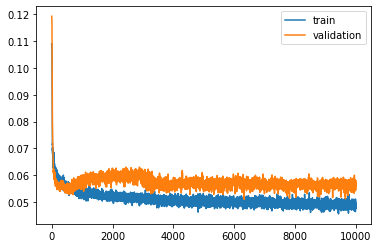

In [178]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

#model.add(LSTM(units=50, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
#10000 72
history = model.fit(train_X, train_y, epochs=10000, batch_size=100, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

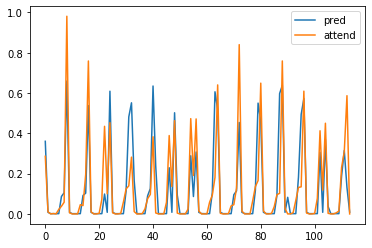

Test RMSE: 0.132
Test MSE: 0.017


In [179]:
yhat = model.predict(test_X)
pyplot.plot(yhat, label='pred')
pyplot.plot(test_y, label='attend')

pyplot.legend()
pyplot.show()

rmse = np.sqrt(mean_squared_error(test_y, yhat))
mse = mean_squared_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)

In [78]:
df_fs=df_scal.drop(['KPI'], axis=1)

In [79]:
# split into train and test sets
values = df_fs.values
n_train_3hours =  int(delta.days * 8 * 0.9)
train_val = values[:n_train_3hours, :]
test = values[n_train_3hours:, :]

n_validate_3hours = int(n_train_3hours * 0.9)
train = train_val[:n_validate_3hours, :]
val = train_val[n_validate_3hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(855, 1, 6) (855,) (95, 1, 6) (95,) (114, 1, 6) (114,)


Train on 855 samples, validate on 95 samples
Epoch 1/10000
 - 1s - loss: 0.1087 - val_loss: 0.1191
Epoch 2/10000
 - 0s - loss: 0.1083 - val_loss: 0.1190
Epoch 3/10000
 - 0s - loss: 0.1083 - val_loss: 0.1190
Epoch 4/10000
 - 0s - loss: 0.1082 - val_loss: 0.1190
Epoch 5/10000
 - 0s - loss: 0.1082 - val_loss: 0.1189
Epoch 6/10000
 - 0s - loss: 0.1080 - val_loss: 0.1187
Epoch 7/10000
 - 0s - loss: 0.1079 - val_loss: 0.1185
Epoch 8/10000
 - 0s - loss: 0.1078 - val_loss: 0.1183
Epoch 9/10000
 - 0s - loss: 0.1074 - val_loss: 0.1178
Epoch 10/10000
 - 0s - loss: 0.1069 - val_loss: 0.1170
Epoch 11/10000
 - 0s - loss: 0.1061 - val_loss: 0.1157
Epoch 12/10000
 - 0s - loss: 0.1048 - val_loss: 0.1136
Epoch 13/10000
 - 0s - loss: 0.1031 - val_loss: 0.1103
Epoch 14/10000
 - 0s - loss: 0.0998 - val_loss: 0.1053
Epoch 15/10000
 - 0s - loss: 0.0967 - val_loss: 0.0983
Epoch 16/10000
 - 0s - loss: 0.0915 - val_loss: 0.0911
Epoch 17/10000
 - 0s - loss: 0.0887 - val_loss: 0.0862
Epoch 18/10000
 - 0s - loss: 

Epoch 149/10000
 - 0s - loss: 0.0654 - val_loss: 0.0546
Epoch 150/10000
 - 0s - loss: 0.0645 - val_loss: 0.0559
Epoch 151/10000
 - 0s - loss: 0.0668 - val_loss: 0.0583
Epoch 152/10000
 - 0s - loss: 0.0655 - val_loss: 0.0557
Epoch 153/10000
 - 0s - loss: 0.0661 - val_loss: 0.0549
Epoch 154/10000
 - 0s - loss: 0.0663 - val_loss: 0.0554
Epoch 155/10000
 - 0s - loss: 0.0667 - val_loss: 0.0566
Epoch 156/10000
 - 0s - loss: 0.0666 - val_loss: 0.0549
Epoch 157/10000
 - 0s - loss: 0.0675 - val_loss: 0.0549
Epoch 158/10000
 - 0s - loss: 0.0674 - val_loss: 0.0544
Epoch 159/10000
 - 0s - loss: 0.0688 - val_loss: 0.0549
Epoch 160/10000
 - 0s - loss: 0.0638 - val_loss: 0.0546
Epoch 161/10000
 - 0s - loss: 0.0638 - val_loss: 0.0563
Epoch 162/10000
 - 0s - loss: 0.0658 - val_loss: 0.0546
Epoch 163/10000
 - 0s - loss: 0.0667 - val_loss: 0.0542
Epoch 164/10000
 - 0s - loss: 0.0656 - val_loss: 0.0551
Epoch 165/10000
 - 0s - loss: 0.0656 - val_loss: 0.0547
Epoch 166/10000
 - 0s - loss: 0.0652 - val_loss:

Epoch 296/10000
 - 0s - loss: 0.0620 - val_loss: 0.0527
Epoch 297/10000
 - 0s - loss: 0.0645 - val_loss: 0.0533
Epoch 298/10000
 - 0s - loss: 0.0622 - val_loss: 0.0537
Epoch 299/10000
 - 0s - loss: 0.0631 - val_loss: 0.0530
Epoch 300/10000
 - 0s - loss: 0.0638 - val_loss: 0.0538
Epoch 301/10000
 - 0s - loss: 0.0648 - val_loss: 0.0538
Epoch 302/10000
 - 0s - loss: 0.0645 - val_loss: 0.0534
Epoch 303/10000
 - 0s - loss: 0.0630 - val_loss: 0.0550
Epoch 304/10000
 - 0s - loss: 0.0648 - val_loss: 0.0532
Epoch 305/10000
 - 0s - loss: 0.0650 - val_loss: 0.0510
Epoch 306/10000
 - 0s - loss: 0.0626 - val_loss: 0.0513
Epoch 307/10000
 - 0s - loss: 0.0642 - val_loss: 0.0514
Epoch 308/10000
 - 0s - loss: 0.0641 - val_loss: 0.0536
Epoch 309/10000
 - 0s - loss: 0.0641 - val_loss: 0.0532
Epoch 310/10000
 - 0s - loss: 0.0642 - val_loss: 0.0518
Epoch 311/10000
 - 0s - loss: 0.0630 - val_loss: 0.0530
Epoch 312/10000
 - 0s - loss: 0.0640 - val_loss: 0.0537
Epoch 313/10000
 - 0s - loss: 0.0641 - val_loss:

Epoch 443/10000
 - 0s - loss: 0.0621 - val_loss: 0.0536
Epoch 444/10000
 - 0s - loss: 0.0623 - val_loss: 0.0533
Epoch 445/10000
 - 0s - loss: 0.0602 - val_loss: 0.0517
Epoch 446/10000
 - 0s - loss: 0.0601 - val_loss: 0.0508
Epoch 447/10000
 - 0s - loss: 0.0630 - val_loss: 0.0518
Epoch 448/10000
 - 0s - loss: 0.0626 - val_loss: 0.0534
Epoch 449/10000
 - 0s - loss: 0.0604 - val_loss: 0.0552
Epoch 450/10000
 - 0s - loss: 0.0626 - val_loss: 0.0548
Epoch 451/10000
 - 0s - loss: 0.0635 - val_loss: 0.0532
Epoch 452/10000
 - 0s - loss: 0.0624 - val_loss: 0.0525
Epoch 453/10000
 - 0s - loss: 0.0612 - val_loss: 0.0537
Epoch 454/10000
 - 0s - loss: 0.0616 - val_loss: 0.0539
Epoch 455/10000
 - 0s - loss: 0.0611 - val_loss: 0.0531
Epoch 456/10000
 - 0s - loss: 0.0636 - val_loss: 0.0543
Epoch 457/10000
 - 0s - loss: 0.0611 - val_loss: 0.0528
Epoch 458/10000
 - 0s - loss: 0.0628 - val_loss: 0.0542
Epoch 459/10000
 - 0s - loss: 0.0621 - val_loss: 0.0540
Epoch 460/10000
 - 0s - loss: 0.0615 - val_loss:

Epoch 590/10000
 - 0s - loss: 0.0618 - val_loss: 0.0561
Epoch 591/10000
 - 0s - loss: 0.0614 - val_loss: 0.0534
Epoch 592/10000
 - 0s - loss: 0.0626 - val_loss: 0.0528
Epoch 593/10000
 - 0s - loss: 0.0618 - val_loss: 0.0534
Epoch 594/10000
 - 0s - loss: 0.0619 - val_loss: 0.0552
Epoch 595/10000
 - 0s - loss: 0.0614 - val_loss: 0.0545
Epoch 596/10000
 - 0s - loss: 0.0621 - val_loss: 0.0544
Epoch 597/10000
 - 0s - loss: 0.0606 - val_loss: 0.0523
Epoch 598/10000
 - 0s - loss: 0.0604 - val_loss: 0.0529
Epoch 599/10000
 - 0s - loss: 0.0616 - val_loss: 0.0531
Epoch 600/10000
 - 0s - loss: 0.0611 - val_loss: 0.0527
Epoch 601/10000
 - 0s - loss: 0.0617 - val_loss: 0.0545
Epoch 602/10000
 - 0s - loss: 0.0616 - val_loss: 0.0538
Epoch 603/10000
 - 0s - loss: 0.0600 - val_loss: 0.0519
Epoch 604/10000
 - 0s - loss: 0.0623 - val_loss: 0.0537
Epoch 605/10000
 - 0s - loss: 0.0611 - val_loss: 0.0554
Epoch 606/10000
 - 0s - loss: 0.0630 - val_loss: 0.0532
Epoch 607/10000
 - 0s - loss: 0.0631 - val_loss:

Epoch 737/10000
 - 0s - loss: 0.0610 - val_loss: 0.0559
Epoch 738/10000
 - 0s - loss: 0.0590 - val_loss: 0.0552
Epoch 739/10000
 - 0s - loss: 0.0626 - val_loss: 0.0549
Epoch 740/10000
 - 0s - loss: 0.0600 - val_loss: 0.0556
Epoch 741/10000
 - 0s - loss: 0.0613 - val_loss: 0.0568
Epoch 742/10000
 - 0s - loss: 0.0608 - val_loss: 0.0562
Epoch 743/10000
 - 0s - loss: 0.0632 - val_loss: 0.0523
Epoch 744/10000
 - 0s - loss: 0.0621 - val_loss: 0.0550
Epoch 745/10000
 - 0s - loss: 0.0593 - val_loss: 0.0561
Epoch 746/10000
 - 0s - loss: 0.0619 - val_loss: 0.0564
Epoch 747/10000
 - 0s - loss: 0.0614 - val_loss: 0.0553
Epoch 748/10000
 - 0s - loss: 0.0607 - val_loss: 0.0542
Epoch 749/10000
 - 0s - loss: 0.0614 - val_loss: 0.0558
Epoch 750/10000
 - 0s - loss: 0.0602 - val_loss: 0.0561
Epoch 751/10000
 - 0s - loss: 0.0598 - val_loss: 0.0551
Epoch 752/10000
 - 0s - loss: 0.0603 - val_loss: 0.0543
Epoch 753/10000
 - 0s - loss: 0.0628 - val_loss: 0.0558
Epoch 754/10000
 - 0s - loss: 0.0611 - val_loss:

Epoch 884/10000
 - 0s - loss: 0.0601 - val_loss: 0.0537
Epoch 885/10000
 - 0s - loss: 0.0605 - val_loss: 0.0544
Epoch 886/10000
 - 0s - loss: 0.0614 - val_loss: 0.0556
Epoch 887/10000
 - 0s - loss: 0.0604 - val_loss: 0.0536
Epoch 888/10000
 - 0s - loss: 0.0608 - val_loss: 0.0551
Epoch 889/10000
 - 0s - loss: 0.0624 - val_loss: 0.0563
Epoch 890/10000
 - 0s - loss: 0.0622 - val_loss: 0.0557
Epoch 891/10000
 - 0s - loss: 0.0591 - val_loss: 0.0555
Epoch 892/10000
 - 0s - loss: 0.0609 - val_loss: 0.0548
Epoch 893/10000
 - 0s - loss: 0.0613 - val_loss: 0.0546
Epoch 894/10000
 - 0s - loss: 0.0589 - val_loss: 0.0559
Epoch 895/10000
 - 0s - loss: 0.0603 - val_loss: 0.0568
Epoch 896/10000
 - 0s - loss: 0.0593 - val_loss: 0.0570
Epoch 897/10000
 - 0s - loss: 0.0611 - val_loss: 0.0569
Epoch 898/10000
 - 0s - loss: 0.0604 - val_loss: 0.0553
Epoch 899/10000
 - 0s - loss: 0.0616 - val_loss: 0.0534
Epoch 900/10000
 - 0s - loss: 0.0609 - val_loss: 0.0544
Epoch 901/10000
 - 0s - loss: 0.0597 - val_loss:

Epoch 1030/10000
 - 0s - loss: 0.0602 - val_loss: 0.0553
Epoch 1031/10000
 - 0s - loss: 0.0594 - val_loss: 0.0554
Epoch 1032/10000
 - 0s - loss: 0.0596 - val_loss: 0.0566
Epoch 1033/10000
 - 0s - loss: 0.0612 - val_loss: 0.0574
Epoch 1034/10000
 - 0s - loss: 0.0613 - val_loss: 0.0578
Epoch 1035/10000
 - 0s - loss: 0.0607 - val_loss: 0.0527
Epoch 1036/10000
 - 0s - loss: 0.0611 - val_loss: 0.0532
Epoch 1037/10000
 - 0s - loss: 0.0611 - val_loss: 0.0561
Epoch 1038/10000
 - 0s - loss: 0.0613 - val_loss: 0.0561
Epoch 1039/10000
 - 0s - loss: 0.0623 - val_loss: 0.0546
Epoch 1040/10000
 - 0s - loss: 0.0600 - val_loss: 0.0554
Epoch 1041/10000
 - 0s - loss: 0.0600 - val_loss: 0.0573
Epoch 1042/10000
 - 0s - loss: 0.0614 - val_loss: 0.0579
Epoch 1043/10000
 - 0s - loss: 0.0617 - val_loss: 0.0546
Epoch 1044/10000
 - 0s - loss: 0.0600 - val_loss: 0.0547
Epoch 1045/10000
 - 0s - loss: 0.0620 - val_loss: 0.0555
Epoch 1046/10000
 - 0s - loss: 0.0594 - val_loss: 0.0574
Epoch 1047/10000
 - 0s - loss: 

Epoch 1174/10000
 - 0s - loss: 0.0608 - val_loss: 0.0559
Epoch 1175/10000
 - 0s - loss: 0.0611 - val_loss: 0.0562
Epoch 1176/10000
 - 0s - loss: 0.0591 - val_loss: 0.0552
Epoch 1177/10000
 - 0s - loss: 0.0592 - val_loss: 0.0556
Epoch 1178/10000
 - 0s - loss: 0.0614 - val_loss: 0.0562
Epoch 1179/10000
 - 0s - loss: 0.0598 - val_loss: 0.0566
Epoch 1180/10000
 - 0s - loss: 0.0611 - val_loss: 0.0570
Epoch 1181/10000
 - 0s - loss: 0.0595 - val_loss: 0.0561
Epoch 1182/10000
 - 0s - loss: 0.0592 - val_loss: 0.0564
Epoch 1183/10000
 - 0s - loss: 0.0584 - val_loss: 0.0559
Epoch 1184/10000
 - 0s - loss: 0.0614 - val_loss: 0.0562
Epoch 1185/10000
 - 0s - loss: 0.0602 - val_loss: 0.0576
Epoch 1186/10000
 - 0s - loss: 0.0586 - val_loss: 0.0564
Epoch 1187/10000
 - 0s - loss: 0.0605 - val_loss: 0.0568
Epoch 1188/10000
 - 0s - loss: 0.0597 - val_loss: 0.0575
Epoch 1189/10000
 - 0s - loss: 0.0600 - val_loss: 0.0557
Epoch 1190/10000
 - 0s - loss: 0.0610 - val_loss: 0.0546
Epoch 1191/10000
 - 0s - loss: 

Epoch 1318/10000
 - 0s - loss: 0.0608 - val_loss: 0.0565
Epoch 1319/10000
 - 0s - loss: 0.0599 - val_loss: 0.0551
Epoch 1320/10000
 - 0s - loss: 0.0572 - val_loss: 0.0554
Epoch 1321/10000
 - 0s - loss: 0.0600 - val_loss: 0.0562
Epoch 1322/10000
 - 0s - loss: 0.0598 - val_loss: 0.0580
Epoch 1323/10000
 - 0s - loss: 0.0604 - val_loss: 0.0582
Epoch 1324/10000
 - 0s - loss: 0.0579 - val_loss: 0.0567
Epoch 1325/10000
 - 0s - loss: 0.0587 - val_loss: 0.0561
Epoch 1326/10000
 - 0s - loss: 0.0587 - val_loss: 0.0556
Epoch 1327/10000
 - 0s - loss: 0.0603 - val_loss: 0.0569
Epoch 1328/10000
 - 0s - loss: 0.0602 - val_loss: 0.0568
Epoch 1329/10000
 - 0s - loss: 0.0602 - val_loss: 0.0561
Epoch 1330/10000
 - 0s - loss: 0.0610 - val_loss: 0.0543
Epoch 1331/10000
 - 0s - loss: 0.0606 - val_loss: 0.0543
Epoch 1332/10000
 - 0s - loss: 0.0620 - val_loss: 0.0547
Epoch 1333/10000
 - 0s - loss: 0.0594 - val_loss: 0.0576
Epoch 1334/10000
 - 0s - loss: 0.0588 - val_loss: 0.0584
Epoch 1335/10000
 - 0s - loss: 

Epoch 1462/10000
 - 0s - loss: 0.0604 - val_loss: 0.0556
Epoch 1463/10000
 - 0s - loss: 0.0590 - val_loss: 0.0573
Epoch 1464/10000
 - 0s - loss: 0.0598 - val_loss: 0.0583
Epoch 1465/10000
 - 0s - loss: 0.0600 - val_loss: 0.0568
Epoch 1466/10000
 - 0s - loss: 0.0606 - val_loss: 0.0563
Epoch 1467/10000
 - 0s - loss: 0.0596 - val_loss: 0.0570
Epoch 1468/10000
 - 0s - loss: 0.0609 - val_loss: 0.0580
Epoch 1469/10000
 - 0s - loss: 0.0597 - val_loss: 0.0571
Epoch 1470/10000
 - 0s - loss: 0.0577 - val_loss: 0.0577
Epoch 1471/10000
 - 0s - loss: 0.0593 - val_loss: 0.0573
Epoch 1472/10000
 - 0s - loss: 0.0599 - val_loss: 0.0563
Epoch 1473/10000
 - 0s - loss: 0.0612 - val_loss: 0.0573
Epoch 1474/10000
 - 0s - loss: 0.0590 - val_loss: 0.0568
Epoch 1475/10000
 - 0s - loss: 0.0603 - val_loss: 0.0558
Epoch 1476/10000
 - 0s - loss: 0.0607 - val_loss: 0.0575
Epoch 1477/10000
 - 0s - loss: 0.0600 - val_loss: 0.0570
Epoch 1478/10000
 - 0s - loss: 0.0594 - val_loss: 0.0555
Epoch 1479/10000
 - 0s - loss: 

Epoch 1606/10000
 - 0s - loss: 0.0605 - val_loss: 0.0546
Epoch 1607/10000
 - 0s - loss: 0.0605 - val_loss: 0.0545
Epoch 1608/10000
 - 0s - loss: 0.0595 - val_loss: 0.0575
Epoch 1609/10000
 - 0s - loss: 0.0591 - val_loss: 0.0583
Epoch 1610/10000
 - 0s - loss: 0.0592 - val_loss: 0.0593
Epoch 1611/10000
 - 0s - loss: 0.0595 - val_loss: 0.0574
Epoch 1612/10000
 - 0s - loss: 0.0583 - val_loss: 0.0581
Epoch 1613/10000
 - 0s - loss: 0.0597 - val_loss: 0.0584
Epoch 1614/10000
 - 0s - loss: 0.0597 - val_loss: 0.0571
Epoch 1615/10000
 - 0s - loss: 0.0594 - val_loss: 0.0580
Epoch 1616/10000
 - 0s - loss: 0.0602 - val_loss: 0.0571
Epoch 1617/10000
 - 0s - loss: 0.0596 - val_loss: 0.0564
Epoch 1618/10000
 - 0s - loss: 0.0589 - val_loss: 0.0564
Epoch 1619/10000
 - 0s - loss: 0.0598 - val_loss: 0.0573
Epoch 1620/10000
 - 0s - loss: 0.0603 - val_loss: 0.0568
Epoch 1621/10000
 - 0s - loss: 0.0590 - val_loss: 0.0533
Epoch 1622/10000
 - 0s - loss: 0.0581 - val_loss: 0.0578
Epoch 1623/10000
 - 0s - loss: 

Epoch 1750/10000
 - 0s - loss: 0.0602 - val_loss: 0.0567
Epoch 1751/10000
 - 0s - loss: 0.0577 - val_loss: 0.0567
Epoch 1752/10000
 - 0s - loss: 0.0583 - val_loss: 0.0553
Epoch 1753/10000
 - 0s - loss: 0.0591 - val_loss: 0.0552
Epoch 1754/10000
 - 0s - loss: 0.0594 - val_loss: 0.0573
Epoch 1755/10000
 - 0s - loss: 0.0594 - val_loss: 0.0570
Epoch 1756/10000
 - 0s - loss: 0.0600 - val_loss: 0.0560
Epoch 1757/10000
 - 0s - loss: 0.0585 - val_loss: 0.0573
Epoch 1758/10000
 - 0s - loss: 0.0601 - val_loss: 0.0567
Epoch 1759/10000
 - 0s - loss: 0.0585 - val_loss: 0.0556
Epoch 1760/10000
 - 0s - loss: 0.0589 - val_loss: 0.0536
Epoch 1761/10000
 - 0s - loss: 0.0586 - val_loss: 0.0565
Epoch 1762/10000
 - 0s - loss: 0.0579 - val_loss: 0.0576
Epoch 1763/10000
 - 0s - loss: 0.0584 - val_loss: 0.0577
Epoch 1764/10000
 - 0s - loss: 0.0593 - val_loss: 0.0552
Epoch 1765/10000
 - 0s - loss: 0.0589 - val_loss: 0.0559
Epoch 1766/10000
 - 0s - loss: 0.0591 - val_loss: 0.0550
Epoch 1767/10000
 - 0s - loss: 

Epoch 1894/10000
 - 0s - loss: 0.0599 - val_loss: 0.0573
Epoch 1895/10000
 - 0s - loss: 0.0590 - val_loss: 0.0562
Epoch 1896/10000
 - 0s - loss: 0.0606 - val_loss: 0.0561
Epoch 1897/10000
 - 0s - loss: 0.0571 - val_loss: 0.0583
Epoch 1898/10000
 - 0s - loss: 0.0585 - val_loss: 0.0572
Epoch 1899/10000
 - 0s - loss: 0.0595 - val_loss: 0.0561
Epoch 1900/10000
 - 0s - loss: 0.0582 - val_loss: 0.0564
Epoch 1901/10000
 - 0s - loss: 0.0586 - val_loss: 0.0566
Epoch 1902/10000
 - 0s - loss: 0.0593 - val_loss: 0.0562
Epoch 1903/10000
 - 0s - loss: 0.0600 - val_loss: 0.0561
Epoch 1904/10000
 - 0s - loss: 0.0583 - val_loss: 0.0573
Epoch 1905/10000
 - 0s - loss: 0.0579 - val_loss: 0.0575
Epoch 1906/10000
 - 0s - loss: 0.0574 - val_loss: 0.0549
Epoch 1907/10000
 - 0s - loss: 0.0586 - val_loss: 0.0548
Epoch 1908/10000
 - 0s - loss: 0.0587 - val_loss: 0.0574
Epoch 1909/10000
 - 0s - loss: 0.0583 - val_loss: 0.0571
Epoch 1910/10000
 - 0s - loss: 0.0579 - val_loss: 0.0572
Epoch 1911/10000
 - 0s - loss: 

Epoch 2038/10000
 - 0s - loss: 0.0606 - val_loss: 0.0560
Epoch 2039/10000
 - 0s - loss: 0.0600 - val_loss: 0.0569
Epoch 2040/10000
 - 0s - loss: 0.0590 - val_loss: 0.0578
Epoch 2041/10000
 - 0s - loss: 0.0592 - val_loss: 0.0578
Epoch 2042/10000
 - 0s - loss: 0.0584 - val_loss: 0.0582
Epoch 2043/10000
 - 0s - loss: 0.0589 - val_loss: 0.0574
Epoch 2044/10000
 - 0s - loss: 0.0602 - val_loss: 0.0581
Epoch 2045/10000
 - 0s - loss: 0.0581 - val_loss: 0.0591
Epoch 2046/10000
 - 0s - loss: 0.0586 - val_loss: 0.0581
Epoch 2047/10000
 - 0s - loss: 0.0588 - val_loss: 0.0577
Epoch 2048/10000
 - 0s - loss: 0.0580 - val_loss: 0.0589
Epoch 2049/10000
 - 0s - loss: 0.0587 - val_loss: 0.0576
Epoch 2050/10000
 - 0s - loss: 0.0588 - val_loss: 0.0543
Epoch 2051/10000
 - 0s - loss: 0.0577 - val_loss: 0.0578
Epoch 2052/10000
 - 0s - loss: 0.0593 - val_loss: 0.0568
Epoch 2053/10000
 - 0s - loss: 0.0592 - val_loss: 0.0563
Epoch 2054/10000
 - 0s - loss: 0.0581 - val_loss: 0.0600
Epoch 2055/10000
 - 0s - loss: 

Epoch 2182/10000
 - 0s - loss: 0.0590 - val_loss: 0.0574
Epoch 2183/10000
 - 0s - loss: 0.0603 - val_loss: 0.0567
Epoch 2184/10000
 - 0s - loss: 0.0587 - val_loss: 0.0568
Epoch 2185/10000
 - 0s - loss: 0.0585 - val_loss: 0.0571
Epoch 2186/10000
 - 0s - loss: 0.0572 - val_loss: 0.0587
Epoch 2187/10000
 - 0s - loss: 0.0590 - val_loss: 0.0584
Epoch 2188/10000
 - 0s - loss: 0.0578 - val_loss: 0.0583
Epoch 2189/10000
 - 0s - loss: 0.0599 - val_loss: 0.0555
Epoch 2190/10000
 - 0s - loss: 0.0573 - val_loss: 0.0547
Epoch 2191/10000
 - 0s - loss: 0.0583 - val_loss: 0.0561
Epoch 2192/10000
 - 0s - loss: 0.0591 - val_loss: 0.0566
Epoch 2193/10000
 - 0s - loss: 0.0592 - val_loss: 0.0545
Epoch 2194/10000
 - 0s - loss: 0.0585 - val_loss: 0.0563
Epoch 2195/10000
 - 0s - loss: 0.0587 - val_loss: 0.0595
Epoch 2196/10000
 - 0s - loss: 0.0580 - val_loss: 0.0578
Epoch 2197/10000
 - 0s - loss: 0.0581 - val_loss: 0.0555
Epoch 2198/10000
 - 0s - loss: 0.0574 - val_loss: 0.0556
Epoch 2199/10000
 - 0s - loss: 

Epoch 2326/10000
 - 0s - loss: 0.0596 - val_loss: 0.0564
Epoch 2327/10000
 - 0s - loss: 0.0572 - val_loss: 0.0563
Epoch 2328/10000
 - 0s - loss: 0.0592 - val_loss: 0.0538
Epoch 2329/10000
 - 0s - loss: 0.0577 - val_loss: 0.0573
Epoch 2330/10000
 - 0s - loss: 0.0586 - val_loss: 0.0585
Epoch 2331/10000
 - 0s - loss: 0.0593 - val_loss: 0.0571
Epoch 2332/10000
 - 0s - loss: 0.0593 - val_loss: 0.0555
Epoch 2333/10000
 - 0s - loss: 0.0599 - val_loss: 0.0591
Epoch 2334/10000
 - 0s - loss: 0.0578 - val_loss: 0.0589
Epoch 2335/10000
 - 0s - loss: 0.0583 - val_loss: 0.0588
Epoch 2336/10000
 - 0s - loss: 0.0593 - val_loss: 0.0585
Epoch 2337/10000
 - 0s - loss: 0.0591 - val_loss: 0.0592
Epoch 2338/10000
 - 0s - loss: 0.0596 - val_loss: 0.0580
Epoch 2339/10000
 - 0s - loss: 0.0573 - val_loss: 0.0583
Epoch 2340/10000
 - 0s - loss: 0.0583 - val_loss: 0.0583
Epoch 2341/10000
 - 0s - loss: 0.0574 - val_loss: 0.0555
Epoch 2342/10000
 - 0s - loss: 0.0589 - val_loss: 0.0561
Epoch 2343/10000
 - 0s - loss: 

Epoch 2470/10000
 - 0s - loss: 0.0586 - val_loss: 0.0572
Epoch 2471/10000
 - 0s - loss: 0.0585 - val_loss: 0.0553
Epoch 2472/10000
 - 0s - loss: 0.0585 - val_loss: 0.0582
Epoch 2473/10000
 - 0s - loss: 0.0586 - val_loss: 0.0600
Epoch 2474/10000
 - 0s - loss: 0.0581 - val_loss: 0.0600
Epoch 2475/10000
 - 0s - loss: 0.0591 - val_loss: 0.0599
Epoch 2476/10000
 - 0s - loss: 0.0574 - val_loss: 0.0572
Epoch 2477/10000
 - 0s - loss: 0.0571 - val_loss: 0.0561
Epoch 2478/10000
 - 0s - loss: 0.0582 - val_loss: 0.0563
Epoch 2479/10000
 - 0s - loss: 0.0583 - val_loss: 0.0562
Epoch 2480/10000
 - 0s - loss: 0.0578 - val_loss: 0.0577
Epoch 2481/10000
 - 0s - loss: 0.0584 - val_loss: 0.0589
Epoch 2482/10000
 - 0s - loss: 0.0571 - val_loss: 0.0576
Epoch 2483/10000
 - 0s - loss: 0.0584 - val_loss: 0.0573
Epoch 2484/10000
 - 0s - loss: 0.0583 - val_loss: 0.0582
Epoch 2485/10000
 - 0s - loss: 0.0589 - val_loss: 0.0588
Epoch 2486/10000
 - 0s - loss: 0.0582 - val_loss: 0.0589
Epoch 2487/10000
 - 0s - loss: 

Epoch 2614/10000
 - 0s - loss: 0.0571 - val_loss: 0.0593
Epoch 2615/10000
 - 0s - loss: 0.0585 - val_loss: 0.0596
Epoch 2616/10000
 - 0s - loss: 0.0572 - val_loss: 0.0593
Epoch 2617/10000
 - 0s - loss: 0.0588 - val_loss: 0.0591
Epoch 2618/10000
 - 0s - loss: 0.0581 - val_loss: 0.0578
Epoch 2619/10000
 - 0s - loss: 0.0573 - val_loss: 0.0580
Epoch 2620/10000
 - 0s - loss: 0.0581 - val_loss: 0.0605
Epoch 2621/10000
 - 0s - loss: 0.0591 - val_loss: 0.0614
Epoch 2622/10000
 - 0s - loss: 0.0598 - val_loss: 0.0551
Epoch 2623/10000
 - 0s - loss: 0.0599 - val_loss: 0.0573
Epoch 2624/10000
 - 0s - loss: 0.0580 - val_loss: 0.0596
Epoch 2625/10000
 - 0s - loss: 0.0590 - val_loss: 0.0576
Epoch 2626/10000
 - 0s - loss: 0.0575 - val_loss: 0.0582
Epoch 2627/10000
 - 0s - loss: 0.0586 - val_loss: 0.0589
Epoch 2628/10000
 - 0s - loss: 0.0583 - val_loss: 0.0599
Epoch 2629/10000
 - 0s - loss: 0.0576 - val_loss: 0.0557
Epoch 2630/10000
 - 0s - loss: 0.0576 - val_loss: 0.0596
Epoch 2631/10000
 - 0s - loss: 

Epoch 2758/10000
 - 0s - loss: 0.0572 - val_loss: 0.0602
Epoch 2759/10000
 - 0s - loss: 0.0594 - val_loss: 0.0590
Epoch 2760/10000
 - 0s - loss: 0.0592 - val_loss: 0.0594
Epoch 2761/10000
 - 0s - loss: 0.0599 - val_loss: 0.0598
Epoch 2762/10000
 - 0s - loss: 0.0588 - val_loss: 0.0583
Epoch 2763/10000
 - 0s - loss: 0.0583 - val_loss: 0.0578
Epoch 2764/10000
 - 0s - loss: 0.0590 - val_loss: 0.0575
Epoch 2765/10000
 - 0s - loss: 0.0583 - val_loss: 0.0596
Epoch 2766/10000
 - 0s - loss: 0.0577 - val_loss: 0.0586
Epoch 2767/10000
 - 0s - loss: 0.0603 - val_loss: 0.0565
Epoch 2768/10000
 - 0s - loss: 0.0572 - val_loss: 0.0567
Epoch 2769/10000
 - 0s - loss: 0.0570 - val_loss: 0.0573
Epoch 2770/10000
 - 0s - loss: 0.0589 - val_loss: 0.0586
Epoch 2771/10000
 - 0s - loss: 0.0601 - val_loss: 0.0577
Epoch 2772/10000
 - 0s - loss: 0.0592 - val_loss: 0.0576
Epoch 2773/10000
 - 0s - loss: 0.0574 - val_loss: 0.0583
Epoch 2774/10000
 - 0s - loss: 0.0574 - val_loss: 0.0594
Epoch 2775/10000
 - 0s - loss: 

Epoch 2902/10000
 - 0s - loss: 0.0582 - val_loss: 0.0601
Epoch 2903/10000
 - 0s - loss: 0.0585 - val_loss: 0.0566
Epoch 2904/10000
 - 0s - loss: 0.0580 - val_loss: 0.0576
Epoch 2905/10000
 - 0s - loss: 0.0573 - val_loss: 0.0579
Epoch 2906/10000
 - 0s - loss: 0.0580 - val_loss: 0.0590
Epoch 2907/10000
 - 0s - loss: 0.0572 - val_loss: 0.0569
Epoch 2908/10000
 - 0s - loss: 0.0559 - val_loss: 0.0605
Epoch 2909/10000
 - 0s - loss: 0.0580 - val_loss: 0.0596
Epoch 2910/10000
 - 0s - loss: 0.0576 - val_loss: 0.0592
Epoch 2911/10000
 - 0s - loss: 0.0597 - val_loss: 0.0597
Epoch 2912/10000
 - 0s - loss: 0.0570 - val_loss: 0.0588
Epoch 2913/10000
 - 0s - loss: 0.0564 - val_loss: 0.0564
Epoch 2914/10000
 - 0s - loss: 0.0590 - val_loss: 0.0564
Epoch 2915/10000
 - 0s - loss: 0.0580 - val_loss: 0.0575
Epoch 2916/10000
 - 0s - loss: 0.0585 - val_loss: 0.0584
Epoch 2917/10000
 - 0s - loss: 0.0579 - val_loss: 0.0587
Epoch 2918/10000
 - 0s - loss: 0.0581 - val_loss: 0.0600
Epoch 2919/10000
 - 0s - loss: 

Epoch 3046/10000
 - 0s - loss: 0.0574 - val_loss: 0.0569
Epoch 3047/10000
 - 0s - loss: 0.0571 - val_loss: 0.0575
Epoch 3048/10000
 - 0s - loss: 0.0581 - val_loss: 0.0576
Epoch 3049/10000
 - 0s - loss: 0.0588 - val_loss: 0.0563
Epoch 3050/10000
 - 0s - loss: 0.0588 - val_loss: 0.0566
Epoch 3051/10000
 - 0s - loss: 0.0578 - val_loss: 0.0591
Epoch 3052/10000
 - 0s - loss: 0.0579 - val_loss: 0.0595
Epoch 3053/10000
 - 0s - loss: 0.0574 - val_loss: 0.0587
Epoch 3054/10000
 - 0s - loss: 0.0587 - val_loss: 0.0587
Epoch 3055/10000
 - 0s - loss: 0.0569 - val_loss: 0.0578
Epoch 3056/10000
 - 0s - loss: 0.0574 - val_loss: 0.0587
Epoch 3057/10000
 - 0s - loss: 0.0576 - val_loss: 0.0585
Epoch 3058/10000
 - 0s - loss: 0.0578 - val_loss: 0.0576
Epoch 3059/10000
 - 0s - loss: 0.0574 - val_loss: 0.0584
Epoch 3060/10000
 - 0s - loss: 0.0582 - val_loss: 0.0586
Epoch 3061/10000
 - 0s - loss: 0.0576 - val_loss: 0.0593
Epoch 3062/10000
 - 0s - loss: 0.0592 - val_loss: 0.0583
Epoch 3063/10000
 - 0s - loss: 

Epoch 3190/10000
 - 0s - loss: 0.0562 - val_loss: 0.0602
Epoch 3191/10000
 - 0s - loss: 0.0594 - val_loss: 0.0580
Epoch 3192/10000
 - 0s - loss: 0.0574 - val_loss: 0.0572
Epoch 3193/10000
 - 0s - loss: 0.0562 - val_loss: 0.0586
Epoch 3194/10000
 - 0s - loss: 0.0578 - val_loss: 0.0594
Epoch 3195/10000
 - 0s - loss: 0.0580 - val_loss: 0.0595
Epoch 3196/10000
 - 0s - loss: 0.0570 - val_loss: 0.0588
Epoch 3197/10000
 - 0s - loss: 0.0549 - val_loss: 0.0604
Epoch 3198/10000
 - 0s - loss: 0.0584 - val_loss: 0.0593
Epoch 3199/10000
 - 0s - loss: 0.0581 - val_loss: 0.0591
Epoch 3200/10000
 - 0s - loss: 0.0573 - val_loss: 0.0608
Epoch 3201/10000
 - 0s - loss: 0.0581 - val_loss: 0.0613
Epoch 3202/10000
 - 0s - loss: 0.0577 - val_loss: 0.0600
Epoch 3203/10000
 - 0s - loss: 0.0570 - val_loss: 0.0584
Epoch 3204/10000
 - 0s - loss: 0.0575 - val_loss: 0.0563
Epoch 3205/10000
 - 0s - loss: 0.0570 - val_loss: 0.0585
Epoch 3206/10000
 - 0s - loss: 0.0567 - val_loss: 0.0588
Epoch 3207/10000
 - 0s - loss: 

Epoch 3334/10000
 - 0s - loss: 0.0573 - val_loss: 0.0579
Epoch 3335/10000
 - 0s - loss: 0.0589 - val_loss: 0.0580
Epoch 3336/10000
 - 0s - loss: 0.0575 - val_loss: 0.0579
Epoch 3337/10000
 - 0s - loss: 0.0601 - val_loss: 0.0575
Epoch 3338/10000
 - 0s - loss: 0.0570 - val_loss: 0.0573
Epoch 3339/10000
 - 0s - loss: 0.0563 - val_loss: 0.0569
Epoch 3340/10000
 - 0s - loss: 0.0576 - val_loss: 0.0578
Epoch 3341/10000
 - 0s - loss: 0.0582 - val_loss: 0.0550
Epoch 3342/10000
 - 0s - loss: 0.0588 - val_loss: 0.0569
Epoch 3343/10000
 - 0s - loss: 0.0572 - val_loss: 0.0586
Epoch 3344/10000
 - 0s - loss: 0.0565 - val_loss: 0.0588
Epoch 3345/10000
 - 0s - loss: 0.0569 - val_loss: 0.0595
Epoch 3346/10000
 - 0s - loss: 0.0564 - val_loss: 0.0592
Epoch 3347/10000
 - 0s - loss: 0.0579 - val_loss: 0.0598
Epoch 3348/10000
 - 0s - loss: 0.0568 - val_loss: 0.0587
Epoch 3349/10000
 - 0s - loss: 0.0577 - val_loss: 0.0568
Epoch 3350/10000
 - 0s - loss: 0.0556 - val_loss: 0.0597
Epoch 3351/10000
 - 0s - loss: 

Epoch 3478/10000
 - 0s - loss: 0.0577 - val_loss: 0.0586
Epoch 3479/10000
 - 0s - loss: 0.0580 - val_loss: 0.0583
Epoch 3480/10000
 - 0s - loss: 0.0579 - val_loss: 0.0570
Epoch 3481/10000
 - 0s - loss: 0.0570 - val_loss: 0.0598
Epoch 3482/10000
 - 0s - loss: 0.0572 - val_loss: 0.0602
Epoch 3483/10000
 - 0s - loss: 0.0576 - val_loss: 0.0600
Epoch 3484/10000
 - 0s - loss: 0.0575 - val_loss: 0.0573
Epoch 3485/10000
 - 0s - loss: 0.0568 - val_loss: 0.0597
Epoch 3486/10000
 - 0s - loss: 0.0576 - val_loss: 0.0604
Epoch 3487/10000
 - 0s - loss: 0.0573 - val_loss: 0.0559
Epoch 3488/10000
 - 0s - loss: 0.0563 - val_loss: 0.0559
Epoch 3489/10000
 - 0s - loss: 0.0584 - val_loss: 0.0581
Epoch 3490/10000
 - 0s - loss: 0.0566 - val_loss: 0.0589
Epoch 3491/10000
 - 0s - loss: 0.0585 - val_loss: 0.0593
Epoch 3492/10000
 - 0s - loss: 0.0582 - val_loss: 0.0573
Epoch 3493/10000
 - 0s - loss: 0.0598 - val_loss: 0.0585
Epoch 3494/10000
 - 0s - loss: 0.0575 - val_loss: 0.0607
Epoch 3495/10000
 - 0s - loss: 

Epoch 3622/10000
 - 0s - loss: 0.0573 - val_loss: 0.0584
Epoch 3623/10000
 - 0s - loss: 0.0573 - val_loss: 0.0589
Epoch 3624/10000
 - 0s - loss: 0.0574 - val_loss: 0.0586
Epoch 3625/10000
 - 0s - loss: 0.0564 - val_loss: 0.0550
Epoch 3626/10000
 - 0s - loss: 0.0606 - val_loss: 0.0553
Epoch 3627/10000
 - 0s - loss: 0.0563 - val_loss: 0.0549
Epoch 3628/10000
 - 0s - loss: 0.0583 - val_loss: 0.0548
Epoch 3629/10000
 - 0s - loss: 0.0571 - val_loss: 0.0570
Epoch 3630/10000
 - 0s - loss: 0.0580 - val_loss: 0.0595
Epoch 3631/10000
 - 0s - loss: 0.0588 - val_loss: 0.0608
Epoch 3632/10000
 - 0s - loss: 0.0575 - val_loss: 0.0590
Epoch 3633/10000
 - 0s - loss: 0.0584 - val_loss: 0.0567
Epoch 3634/10000
 - 0s - loss: 0.0576 - val_loss: 0.0574
Epoch 3635/10000
 - 0s - loss: 0.0562 - val_loss: 0.0586
Epoch 3636/10000
 - 0s - loss: 0.0568 - val_loss: 0.0584
Epoch 3637/10000
 - 0s - loss: 0.0572 - val_loss: 0.0569
Epoch 3638/10000
 - 0s - loss: 0.0574 - val_loss: 0.0563
Epoch 3639/10000
 - 0s - loss: 

Epoch 3766/10000
 - 0s - loss: 0.0570 - val_loss: 0.0596
Epoch 3767/10000
 - 0s - loss: 0.0585 - val_loss: 0.0587
Epoch 3768/10000
 - 0s - loss: 0.0568 - val_loss: 0.0600
Epoch 3769/10000
 - 0s - loss: 0.0568 - val_loss: 0.0602
Epoch 3770/10000
 - 0s - loss: 0.0576 - val_loss: 0.0592
Epoch 3771/10000
 - 0s - loss: 0.0561 - val_loss: 0.0591
Epoch 3772/10000
 - 0s - loss: 0.0581 - val_loss: 0.0603
Epoch 3773/10000
 - 0s - loss: 0.0575 - val_loss: 0.0585
Epoch 3774/10000
 - 0s - loss: 0.0577 - val_loss: 0.0583
Epoch 3775/10000
 - 0s - loss: 0.0548 - val_loss: 0.0593
Epoch 3776/10000
 - 0s - loss: 0.0575 - val_loss: 0.0571
Epoch 3777/10000
 - 0s - loss: 0.0592 - val_loss: 0.0593
Epoch 3778/10000
 - 0s - loss: 0.0569 - val_loss: 0.0596
Epoch 3779/10000
 - 0s - loss: 0.0586 - val_loss: 0.0596
Epoch 3780/10000
 - 0s - loss: 0.0568 - val_loss: 0.0584
Epoch 3781/10000
 - 0s - loss: 0.0585 - val_loss: 0.0547
Epoch 3782/10000
 - 0s - loss: 0.0575 - val_loss: 0.0567
Epoch 3783/10000
 - 0s - loss: 

Epoch 3910/10000
 - 0s - loss: 0.0582 - val_loss: 0.0598
Epoch 3911/10000
 - 0s - loss: 0.0573 - val_loss: 0.0594
Epoch 3912/10000
 - 0s - loss: 0.0591 - val_loss: 0.0595
Epoch 3913/10000
 - 0s - loss: 0.0574 - val_loss: 0.0594
Epoch 3914/10000
 - 0s - loss: 0.0568 - val_loss: 0.0580
Epoch 3915/10000
 - 0s - loss: 0.0559 - val_loss: 0.0563
Epoch 3916/10000
 - 0s - loss: 0.0588 - val_loss: 0.0575
Epoch 3917/10000
 - 0s - loss: 0.0558 - val_loss: 0.0585
Epoch 3918/10000
 - 0s - loss: 0.0575 - val_loss: 0.0590
Epoch 3919/10000
 - 0s - loss: 0.0581 - val_loss: 0.0603
Epoch 3920/10000
 - 0s - loss: 0.0560 - val_loss: 0.0594
Epoch 3921/10000
 - 0s - loss: 0.0575 - val_loss: 0.0581
Epoch 3922/10000
 - 0s - loss: 0.0585 - val_loss: 0.0569
Epoch 3923/10000
 - 0s - loss: 0.0583 - val_loss: 0.0580
Epoch 3924/10000
 - 0s - loss: 0.0584 - val_loss: 0.0568
Epoch 3925/10000
 - 0s - loss: 0.0561 - val_loss: 0.0540
Epoch 3926/10000
 - 0s - loss: 0.0551 - val_loss: 0.0548
Epoch 3927/10000
 - 0s - loss: 

Epoch 4054/10000
 - 0s - loss: 0.0570 - val_loss: 0.0567
Epoch 4055/10000
 - 0s - loss: 0.0571 - val_loss: 0.0555
Epoch 4056/10000
 - 0s - loss: 0.0575 - val_loss: 0.0553
Epoch 4057/10000
 - 0s - loss: 0.0570 - val_loss: 0.0592
Epoch 4058/10000
 - 0s - loss: 0.0566 - val_loss: 0.0599
Epoch 4059/10000
 - 0s - loss: 0.0580 - val_loss: 0.0601
Epoch 4060/10000
 - 0s - loss: 0.0585 - val_loss: 0.0585
Epoch 4061/10000
 - 0s - loss: 0.0568 - val_loss: 0.0595
Epoch 4062/10000
 - 0s - loss: 0.0569 - val_loss: 0.0599
Epoch 4063/10000
 - 0s - loss: 0.0564 - val_loss: 0.0558
Epoch 4064/10000
 - 0s - loss: 0.0563 - val_loss: 0.0552
Epoch 4065/10000
 - 0s - loss: 0.0581 - val_loss: 0.0565
Epoch 4066/10000
 - 0s - loss: 0.0570 - val_loss: 0.0583
Epoch 4067/10000
 - 0s - loss: 0.0571 - val_loss: 0.0578
Epoch 4068/10000
 - 0s - loss: 0.0574 - val_loss: 0.0583
Epoch 4069/10000
 - 0s - loss: 0.0570 - val_loss: 0.0576
Epoch 4070/10000
 - 0s - loss: 0.0558 - val_loss: 0.0587
Epoch 4071/10000
 - 0s - loss: 

Epoch 4198/10000
 - 0s - loss: 0.0570 - val_loss: 0.0594
Epoch 4199/10000
 - 0s - loss: 0.0555 - val_loss: 0.0600
Epoch 4200/10000
 - 0s - loss: 0.0561 - val_loss: 0.0599
Epoch 4201/10000
 - 0s - loss: 0.0567 - val_loss: 0.0584
Epoch 4202/10000
 - 0s - loss: 0.0563 - val_loss: 0.0587
Epoch 4203/10000
 - 0s - loss: 0.0579 - val_loss: 0.0556
Epoch 4204/10000
 - 0s - loss: 0.0594 - val_loss: 0.0558
Epoch 4205/10000
 - 0s - loss: 0.0583 - val_loss: 0.0566
Epoch 4206/10000
 - 0s - loss: 0.0584 - val_loss: 0.0573
Epoch 4207/10000
 - 0s - loss: 0.0570 - val_loss: 0.0584
Epoch 4208/10000
 - 0s - loss: 0.0576 - val_loss: 0.0600
Epoch 4209/10000
 - 0s - loss: 0.0562 - val_loss: 0.0596
Epoch 4210/10000
 - 0s - loss: 0.0575 - val_loss: 0.0612
Epoch 4211/10000
 - 0s - loss: 0.0570 - val_loss: 0.0620
Epoch 4212/10000
 - 0s - loss: 0.0573 - val_loss: 0.0607
Epoch 4213/10000
 - 0s - loss: 0.0568 - val_loss: 0.0602
Epoch 4214/10000
 - 0s - loss: 0.0557 - val_loss: 0.0599
Epoch 4215/10000
 - 0s - loss: 

Epoch 4342/10000
 - 0s - loss: 0.0575 - val_loss: 0.0593
Epoch 4343/10000
 - 0s - loss: 0.0564 - val_loss: 0.0584
Epoch 4344/10000
 - 0s - loss: 0.0567 - val_loss: 0.0578
Epoch 4345/10000
 - 0s - loss: 0.0577 - val_loss: 0.0596
Epoch 4346/10000
 - 0s - loss: 0.0574 - val_loss: 0.0604
Epoch 4347/10000
 - 0s - loss: 0.0562 - val_loss: 0.0616
Epoch 4348/10000
 - 0s - loss: 0.0575 - val_loss: 0.0610
Epoch 4349/10000
 - 0s - loss: 0.0572 - val_loss: 0.0608
Epoch 4350/10000
 - 0s - loss: 0.0565 - val_loss: 0.0592
Epoch 4351/10000
 - 0s - loss: 0.0589 - val_loss: 0.0578
Epoch 4352/10000
 - 0s - loss: 0.0571 - val_loss: 0.0570
Epoch 4353/10000
 - 0s - loss: 0.0568 - val_loss: 0.0566
Epoch 4354/10000
 - 0s - loss: 0.0562 - val_loss: 0.0552
Epoch 4355/10000
 - 0s - loss: 0.0559 - val_loss: 0.0569
Epoch 4356/10000
 - 0s - loss: 0.0561 - val_loss: 0.0570
Epoch 4357/10000
 - 0s - loss: 0.0573 - val_loss: 0.0573
Epoch 4358/10000
 - 0s - loss: 0.0596 - val_loss: 0.0584
Epoch 4359/10000
 - 0s - loss: 

Epoch 4486/10000
 - 0s - loss: 0.0565 - val_loss: 0.0600
Epoch 4487/10000
 - 0s - loss: 0.0556 - val_loss: 0.0610
Epoch 4488/10000
 - 0s - loss: 0.0582 - val_loss: 0.0588
Epoch 4489/10000
 - 0s - loss: 0.0576 - val_loss: 0.0581
Epoch 4490/10000
 - 0s - loss: 0.0577 - val_loss: 0.0593
Epoch 4491/10000
 - 0s - loss: 0.0574 - val_loss: 0.0609
Epoch 4492/10000
 - 0s - loss: 0.0573 - val_loss: 0.0597
Epoch 4493/10000
 - 0s - loss: 0.0584 - val_loss: 0.0570
Epoch 4494/10000
 - 0s - loss: 0.0562 - val_loss: 0.0601
Epoch 4495/10000
 - 0s - loss: 0.0574 - val_loss: 0.0618
Epoch 4496/10000
 - 0s - loss: 0.0564 - val_loss: 0.0610
Epoch 4497/10000
 - 0s - loss: 0.0565 - val_loss: 0.0601
Epoch 4498/10000
 - 0s - loss: 0.0569 - val_loss: 0.0580
Epoch 4499/10000
 - 0s - loss: 0.0571 - val_loss: 0.0589
Epoch 4500/10000
 - 0s - loss: 0.0566 - val_loss: 0.0609
Epoch 4501/10000
 - 0s - loss: 0.0557 - val_loss: 0.0618
Epoch 4502/10000
 - 0s - loss: 0.0552 - val_loss: 0.0611
Epoch 4503/10000
 - 0s - loss: 

Epoch 4630/10000
 - 0s - loss: 0.0579 - val_loss: 0.0581
Epoch 4631/10000
 - 0s - loss: 0.0586 - val_loss: 0.0592
Epoch 4632/10000
 - 0s - loss: 0.0582 - val_loss: 0.0598
Epoch 4633/10000
 - 0s - loss: 0.0561 - val_loss: 0.0593
Epoch 4634/10000
 - 0s - loss: 0.0576 - val_loss: 0.0599
Epoch 4635/10000
 - 0s - loss: 0.0580 - val_loss: 0.0599
Epoch 4636/10000
 - 0s - loss: 0.0557 - val_loss: 0.0607
Epoch 4637/10000
 - 0s - loss: 0.0583 - val_loss: 0.0578
Epoch 4638/10000
 - 0s - loss: 0.0570 - val_loss: 0.0580
Epoch 4639/10000
 - 0s - loss: 0.0595 - val_loss: 0.0599
Epoch 4640/10000
 - 0s - loss: 0.0556 - val_loss: 0.0595
Epoch 4641/10000
 - 0s - loss: 0.0570 - val_loss: 0.0591
Epoch 4642/10000
 - 0s - loss: 0.0562 - val_loss: 0.0587
Epoch 4643/10000
 - 0s - loss: 0.0578 - val_loss: 0.0611
Epoch 4644/10000
 - 0s - loss: 0.0564 - val_loss: 0.0620
Epoch 4645/10000
 - 0s - loss: 0.0574 - val_loss: 0.0598
Epoch 4646/10000
 - 0s - loss: 0.0574 - val_loss: 0.0592
Epoch 4647/10000
 - 0s - loss: 

Epoch 4774/10000
 - 0s - loss: 0.0575 - val_loss: 0.0614
Epoch 4775/10000
 - 0s - loss: 0.0570 - val_loss: 0.0613
Epoch 4776/10000
 - 0s - loss: 0.0565 - val_loss: 0.0603
Epoch 4777/10000
 - 0s - loss: 0.0568 - val_loss: 0.0608
Epoch 4778/10000
 - 0s - loss: 0.0565 - val_loss: 0.0608
Epoch 4779/10000
 - 0s - loss: 0.0562 - val_loss: 0.0598
Epoch 4780/10000
 - 0s - loss: 0.0553 - val_loss: 0.0590
Epoch 4781/10000
 - 0s - loss: 0.0571 - val_loss: 0.0592
Epoch 4782/10000
 - 0s - loss: 0.0589 - val_loss: 0.0589
Epoch 4783/10000
 - 0s - loss: 0.0574 - val_loss: 0.0600
Epoch 4784/10000
 - 0s - loss: 0.0585 - val_loss: 0.0600
Epoch 4785/10000
 - 0s - loss: 0.0572 - val_loss: 0.0581
Epoch 4786/10000
 - 0s - loss: 0.0581 - val_loss: 0.0564
Epoch 4787/10000
 - 0s - loss: 0.0568 - val_loss: 0.0557
Epoch 4788/10000
 - 0s - loss: 0.0580 - val_loss: 0.0567
Epoch 4789/10000
 - 0s - loss: 0.0562 - val_loss: 0.0592
Epoch 4790/10000
 - 0s - loss: 0.0543 - val_loss: 0.0606
Epoch 4791/10000
 - 0s - loss: 

Epoch 4918/10000
 - 0s - loss: 0.0560 - val_loss: 0.0586
Epoch 4919/10000
 - 0s - loss: 0.0563 - val_loss: 0.0608
Epoch 4920/10000
 - 0s - loss: 0.0569 - val_loss: 0.0598
Epoch 4921/10000
 - 0s - loss: 0.0566 - val_loss: 0.0604
Epoch 4922/10000
 - 0s - loss: 0.0577 - val_loss: 0.0601
Epoch 4923/10000
 - 0s - loss: 0.0564 - val_loss: 0.0591
Epoch 4924/10000
 - 0s - loss: 0.0548 - val_loss: 0.0592
Epoch 4925/10000
 - 0s - loss: 0.0554 - val_loss: 0.0602
Epoch 4926/10000
 - 0s - loss: 0.0582 - val_loss: 0.0596
Epoch 4927/10000
 - 0s - loss: 0.0561 - val_loss: 0.0576
Epoch 4928/10000
 - 0s - loss: 0.0563 - val_loss: 0.0591
Epoch 4929/10000
 - 0s - loss: 0.0571 - val_loss: 0.0601
Epoch 4930/10000
 - 0s - loss: 0.0559 - val_loss: 0.0591
Epoch 4931/10000
 - 0s - loss: 0.0563 - val_loss: 0.0593
Epoch 4932/10000
 - 0s - loss: 0.0563 - val_loss: 0.0594
Epoch 4933/10000
 - 0s - loss: 0.0565 - val_loss: 0.0608
Epoch 4934/10000
 - 0s - loss: 0.0577 - val_loss: 0.0604
Epoch 4935/10000
 - 0s - loss: 

Epoch 5062/10000
 - 0s - loss: 0.0576 - val_loss: 0.0528
Epoch 5063/10000
 - 0s - loss: 0.0583 - val_loss: 0.0566
Epoch 5064/10000
 - 0s - loss: 0.0563 - val_loss: 0.0574
Epoch 5065/10000
 - 0s - loss: 0.0578 - val_loss: 0.0583
Epoch 5066/10000
 - 0s - loss: 0.0569 - val_loss: 0.0574
Epoch 5067/10000
 - 0s - loss: 0.0568 - val_loss: 0.0581
Epoch 5068/10000
 - 0s - loss: 0.0574 - val_loss: 0.0589
Epoch 5069/10000
 - 0s - loss: 0.0582 - val_loss: 0.0596
Epoch 5070/10000
 - 0s - loss: 0.0564 - val_loss: 0.0596
Epoch 5071/10000
 - 0s - loss: 0.0576 - val_loss: 0.0595
Epoch 5072/10000
 - 0s - loss: 0.0551 - val_loss: 0.0580
Epoch 5073/10000
 - 0s - loss: 0.0575 - val_loss: 0.0562
Epoch 5074/10000
 - 0s - loss: 0.0576 - val_loss: 0.0569
Epoch 5075/10000
 - 0s - loss: 0.0568 - val_loss: 0.0569
Epoch 5076/10000
 - 0s - loss: 0.0577 - val_loss: 0.0572
Epoch 5077/10000
 - 0s - loss: 0.0552 - val_loss: 0.0592
Epoch 5078/10000
 - 0s - loss: 0.0569 - val_loss: 0.0599
Epoch 5079/10000
 - 0s - loss: 

Epoch 5206/10000
 - 0s - loss: 0.0584 - val_loss: 0.0602
Epoch 5207/10000
 - 0s - loss: 0.0585 - val_loss: 0.0605
Epoch 5208/10000
 - 0s - loss: 0.0563 - val_loss: 0.0551
Epoch 5209/10000
 - 0s - loss: 0.0582 - val_loss: 0.0546
Epoch 5210/10000
 - 0s - loss: 0.0552 - val_loss: 0.0573
Epoch 5211/10000
 - 0s - loss: 0.0563 - val_loss: 0.0597
Epoch 5212/10000
 - 0s - loss: 0.0560 - val_loss: 0.0575
Epoch 5213/10000
 - 0s - loss: 0.0568 - val_loss: 0.0574
Epoch 5214/10000
 - 0s - loss: 0.0579 - val_loss: 0.0615
Epoch 5215/10000
 - 0s - loss: 0.0556 - val_loss: 0.0607
Epoch 5216/10000
 - 0s - loss: 0.0574 - val_loss: 0.0617
Epoch 5217/10000
 - 0s - loss: 0.0569 - val_loss: 0.0602
Epoch 5218/10000
 - 0s - loss: 0.0563 - val_loss: 0.0604
Epoch 5219/10000
 - 0s - loss: 0.0536 - val_loss: 0.0601
Epoch 5220/10000
 - 0s - loss: 0.0560 - val_loss: 0.0618
Epoch 5221/10000
 - 0s - loss: 0.0582 - val_loss: 0.0632
Epoch 5222/10000
 - 0s - loss: 0.0569 - val_loss: 0.0620
Epoch 5223/10000
 - 0s - loss: 

Epoch 5350/10000
 - 0s - loss: 0.0556 - val_loss: 0.0612
Epoch 5351/10000
 - 0s - loss: 0.0584 - val_loss: 0.0612
Epoch 5352/10000
 - 0s - loss: 0.0555 - val_loss: 0.0621
Epoch 5353/10000
 - 0s - loss: 0.0556 - val_loss: 0.0595
Epoch 5354/10000
 - 0s - loss: 0.0569 - val_loss: 0.0620
Epoch 5355/10000
 - 0s - loss: 0.0580 - val_loss: 0.0637
Epoch 5356/10000
 - 0s - loss: 0.0574 - val_loss: 0.0595
Epoch 5357/10000
 - 0s - loss: 0.0555 - val_loss: 0.0585
Epoch 5358/10000
 - 0s - loss: 0.0569 - val_loss: 0.0587
Epoch 5359/10000
 - 0s - loss: 0.0555 - val_loss: 0.0582
Epoch 5360/10000
 - 0s - loss: 0.0567 - val_loss: 0.0584
Epoch 5361/10000
 - 0s - loss: 0.0594 - val_loss: 0.0593
Epoch 5362/10000
 - 0s - loss: 0.0555 - val_loss: 0.0593
Epoch 5363/10000
 - 0s - loss: 0.0563 - val_loss: 0.0584
Epoch 5364/10000
 - 0s - loss: 0.0567 - val_loss: 0.0583
Epoch 5365/10000
 - 0s - loss: 0.0587 - val_loss: 0.0603
Epoch 5366/10000
 - 0s - loss: 0.0568 - val_loss: 0.0622
Epoch 5367/10000
 - 0s - loss: 

Epoch 5494/10000
 - 0s - loss: 0.0564 - val_loss: 0.0594
Epoch 5495/10000
 - 0s - loss: 0.0538 - val_loss: 0.0594
Epoch 5496/10000
 - 0s - loss: 0.0556 - val_loss: 0.0590
Epoch 5497/10000
 - 0s - loss: 0.0573 - val_loss: 0.0584
Epoch 5498/10000
 - 0s - loss: 0.0564 - val_loss: 0.0579
Epoch 5499/10000
 - 0s - loss: 0.0537 - val_loss: 0.0579
Epoch 5500/10000
 - 0s - loss: 0.0561 - val_loss: 0.0588
Epoch 5501/10000
 - 0s - loss: 0.0544 - val_loss: 0.0602
Epoch 5502/10000
 - 0s - loss: 0.0571 - val_loss: 0.0588
Epoch 5503/10000
 - 0s - loss: 0.0571 - val_loss: 0.0598
Epoch 5504/10000
 - 0s - loss: 0.0560 - val_loss: 0.0595
Epoch 5505/10000
 - 0s - loss: 0.0570 - val_loss: 0.0592
Epoch 5506/10000
 - 0s - loss: 0.0569 - val_loss: 0.0588
Epoch 5507/10000
 - 0s - loss: 0.0561 - val_loss: 0.0593
Epoch 5508/10000
 - 0s - loss: 0.0557 - val_loss: 0.0593
Epoch 5509/10000
 - 0s - loss: 0.0578 - val_loss: 0.0593
Epoch 5510/10000
 - 0s - loss: 0.0584 - val_loss: 0.0601
Epoch 5511/10000
 - 0s - loss: 

Epoch 5638/10000
 - 0s - loss: 0.0579 - val_loss: 0.0605
Epoch 5639/10000
 - 0s - loss: 0.0565 - val_loss: 0.0617
Epoch 5640/10000
 - 0s - loss: 0.0561 - val_loss: 0.0610
Epoch 5641/10000
 - 0s - loss: 0.0550 - val_loss: 0.0588
Epoch 5642/10000
 - 0s - loss: 0.0564 - val_loss: 0.0577
Epoch 5643/10000
 - 0s - loss: 0.0570 - val_loss: 0.0588
Epoch 5644/10000
 - 0s - loss: 0.0543 - val_loss: 0.0581
Epoch 5645/10000
 - 0s - loss: 0.0560 - val_loss: 0.0579
Epoch 5646/10000
 - 0s - loss: 0.0568 - val_loss: 0.0565
Epoch 5647/10000
 - 0s - loss: 0.0571 - val_loss: 0.0554
Epoch 5648/10000
 - 0s - loss: 0.0557 - val_loss: 0.0545
Epoch 5649/10000
 - 0s - loss: 0.0569 - val_loss: 0.0542
Epoch 5650/10000
 - 0s - loss: 0.0575 - val_loss: 0.0565
Epoch 5651/10000
 - 0s - loss: 0.0573 - val_loss: 0.0582
Epoch 5652/10000
 - 0s - loss: 0.0564 - val_loss: 0.0626
Epoch 5653/10000
 - 0s - loss: 0.0572 - val_loss: 0.0617
Epoch 5654/10000
 - 0s - loss: 0.0561 - val_loss: 0.0608
Epoch 5655/10000
 - 0s - loss: 

Epoch 5782/10000
 - 0s - loss: 0.0549 - val_loss: 0.0563
Epoch 5783/10000
 - 0s - loss: 0.0560 - val_loss: 0.0565
Epoch 5784/10000
 - 0s - loss: 0.0566 - val_loss: 0.0576
Epoch 5785/10000
 - 0s - loss: 0.0560 - val_loss: 0.0559
Epoch 5786/10000
 - 0s - loss: 0.0547 - val_loss: 0.0574
Epoch 5787/10000
 - 0s - loss: 0.0553 - val_loss: 0.0565
Epoch 5788/10000
 - 0s - loss: 0.0572 - val_loss: 0.0558
Epoch 5789/10000
 - 0s - loss: 0.0561 - val_loss: 0.0536
Epoch 5790/10000
 - 0s - loss: 0.0582 - val_loss: 0.0542
Epoch 5791/10000
 - 0s - loss: 0.0574 - val_loss: 0.0554
Epoch 5792/10000
 - 0s - loss: 0.0572 - val_loss: 0.0568
Epoch 5793/10000
 - 0s - loss: 0.0564 - val_loss: 0.0556
Epoch 5794/10000
 - 0s - loss: 0.0555 - val_loss: 0.0597
Epoch 5795/10000
 - 0s - loss: 0.0545 - val_loss: 0.0604
Epoch 5796/10000
 - 0s - loss: 0.0563 - val_loss: 0.0583
Epoch 5797/10000
 - 0s - loss: 0.0586 - val_loss: 0.0580
Epoch 5798/10000
 - 0s - loss: 0.0571 - val_loss: 0.0589
Epoch 5799/10000
 - 0s - loss: 

Epoch 5926/10000
 - 0s - loss: 0.0547 - val_loss: 0.0583
Epoch 5927/10000
 - 0s - loss: 0.0565 - val_loss: 0.0593
Epoch 5928/10000
 - 0s - loss: 0.0578 - val_loss: 0.0616
Epoch 5929/10000
 - 0s - loss: 0.0569 - val_loss: 0.0613
Epoch 5930/10000
 - 0s - loss: 0.0567 - val_loss: 0.0570
Epoch 5931/10000
 - 0s - loss: 0.0565 - val_loss: 0.0553
Epoch 5932/10000
 - 0s - loss: 0.0559 - val_loss: 0.0572
Epoch 5933/10000
 - 0s - loss: 0.0552 - val_loss: 0.0562
Epoch 5934/10000
 - 0s - loss: 0.0555 - val_loss: 0.0561
Epoch 5935/10000
 - 0s - loss: 0.0554 - val_loss: 0.0562
Epoch 5936/10000
 - 0s - loss: 0.0577 - val_loss: 0.0566
Epoch 5937/10000
 - 0s - loss: 0.0560 - val_loss: 0.0587
Epoch 5938/10000
 - 0s - loss: 0.0545 - val_loss: 0.0583
Epoch 5939/10000
 - 0s - loss: 0.0569 - val_loss: 0.0581
Epoch 5940/10000
 - 0s - loss: 0.0565 - val_loss: 0.0580
Epoch 5941/10000
 - 0s - loss: 0.0591 - val_loss: 0.0591
Epoch 5942/10000
 - 0s - loss: 0.0579 - val_loss: 0.0570
Epoch 5943/10000
 - 0s - loss: 

Epoch 6070/10000
 - 0s - loss: 0.0552 - val_loss: 0.0604
Epoch 6071/10000
 - 0s - loss: 0.0568 - val_loss: 0.0588
Epoch 6072/10000
 - 0s - loss: 0.0552 - val_loss: 0.0578
Epoch 6073/10000
 - 0s - loss: 0.0561 - val_loss: 0.0571
Epoch 6074/10000
 - 0s - loss: 0.0555 - val_loss: 0.0599
Epoch 6075/10000
 - 0s - loss: 0.0555 - val_loss: 0.0604
Epoch 6076/10000
 - 0s - loss: 0.0562 - val_loss: 0.0604
Epoch 6077/10000
 - 0s - loss: 0.0573 - val_loss: 0.0605
Epoch 6078/10000
 - 0s - loss: 0.0568 - val_loss: 0.0599
Epoch 6079/10000
 - 0s - loss: 0.0558 - val_loss: 0.0572
Epoch 6080/10000
 - 0s - loss: 0.0577 - val_loss: 0.0583
Epoch 6081/10000
 - 0s - loss: 0.0577 - val_loss: 0.0573
Epoch 6082/10000
 - 0s - loss: 0.0574 - val_loss: 0.0572
Epoch 6083/10000
 - 0s - loss: 0.0582 - val_loss: 0.0573
Epoch 6084/10000
 - 0s - loss: 0.0562 - val_loss: 0.0600
Epoch 6085/10000
 - 0s - loss: 0.0545 - val_loss: 0.0590
Epoch 6086/10000
 - 0s - loss: 0.0569 - val_loss: 0.0595
Epoch 6087/10000
 - 0s - loss: 

Epoch 6214/10000
 - 0s - loss: 0.0549 - val_loss: 0.0601
Epoch 6215/10000
 - 0s - loss: 0.0549 - val_loss: 0.0595
Epoch 6216/10000
 - 0s - loss: 0.0563 - val_loss: 0.0594
Epoch 6217/10000
 - 0s - loss: 0.0542 - val_loss: 0.0593
Epoch 6218/10000
 - 0s - loss: 0.0552 - val_loss: 0.0604
Epoch 6219/10000
 - 0s - loss: 0.0557 - val_loss: 0.0612
Epoch 6220/10000
 - 0s - loss: 0.0559 - val_loss: 0.0592
Epoch 6221/10000
 - 0s - loss: 0.0552 - val_loss: 0.0568
Epoch 6222/10000
 - 0s - loss: 0.0564 - val_loss: 0.0566
Epoch 6223/10000
 - 0s - loss: 0.0568 - val_loss: 0.0570
Epoch 6224/10000
 - 0s - loss: 0.0562 - val_loss: 0.0586
Epoch 6225/10000
 - 0s - loss: 0.0559 - val_loss: 0.0579
Epoch 6226/10000
 - 0s - loss: 0.0559 - val_loss: 0.0587
Epoch 6227/10000
 - 0s - loss: 0.0561 - val_loss: 0.0572
Epoch 6228/10000
 - 0s - loss: 0.0553 - val_loss: 0.0597
Epoch 6229/10000
 - 0s - loss: 0.0559 - val_loss: 0.0591
Epoch 6230/10000
 - 0s - loss: 0.0551 - val_loss: 0.0575
Epoch 6231/10000
 - 0s - loss: 

Epoch 6358/10000
 - 0s - loss: 0.0572 - val_loss: 0.0594
Epoch 6359/10000
 - 0s - loss: 0.0541 - val_loss: 0.0595
Epoch 6360/10000
 - 0s - loss: 0.0571 - val_loss: 0.0590
Epoch 6361/10000
 - 0s - loss: 0.0573 - val_loss: 0.0577
Epoch 6362/10000
 - 0s - loss: 0.0564 - val_loss: 0.0580
Epoch 6363/10000
 - 0s - loss: 0.0571 - val_loss: 0.0591
Epoch 6364/10000
 - 0s - loss: 0.0545 - val_loss: 0.0584
Epoch 6365/10000
 - 0s - loss: 0.0542 - val_loss: 0.0598
Epoch 6366/10000
 - 0s - loss: 0.0559 - val_loss: 0.0586
Epoch 6367/10000
 - 0s - loss: 0.0564 - val_loss: 0.0547
Epoch 6368/10000
 - 0s - loss: 0.0553 - val_loss: 0.0560
Epoch 6369/10000
 - 0s - loss: 0.0557 - val_loss: 0.0566
Epoch 6370/10000
 - 0s - loss: 0.0560 - val_loss: 0.0559
Epoch 6371/10000
 - 0s - loss: 0.0560 - val_loss: 0.0567
Epoch 6372/10000
 - 0s - loss: 0.0545 - val_loss: 0.0592
Epoch 6373/10000
 - 0s - loss: 0.0573 - val_loss: 0.0584
Epoch 6374/10000
 - 0s - loss: 0.0575 - val_loss: 0.0560
Epoch 6375/10000
 - 0s - loss: 

Epoch 6502/10000
 - 0s - loss: 0.0564 - val_loss: 0.0595
Epoch 6503/10000
 - 0s - loss: 0.0567 - val_loss: 0.0572
Epoch 6504/10000
 - 0s - loss: 0.0560 - val_loss: 0.0564
Epoch 6505/10000
 - 0s - loss: 0.0562 - val_loss: 0.0584
Epoch 6506/10000
 - 0s - loss: 0.0534 - val_loss: 0.0584
Epoch 6507/10000
 - 0s - loss: 0.0559 - val_loss: 0.0581
Epoch 6508/10000
 - 0s - loss: 0.0562 - val_loss: 0.0585
Epoch 6509/10000
 - 0s - loss: 0.0552 - val_loss: 0.0583
Epoch 6510/10000
 - 0s - loss: 0.0576 - val_loss: 0.0566
Epoch 6511/10000
 - 0s - loss: 0.0566 - val_loss: 0.0576
Epoch 6512/10000
 - 0s - loss: 0.0565 - val_loss: 0.0593
Epoch 6513/10000
 - 0s - loss: 0.0561 - val_loss: 0.0596
Epoch 6514/10000
 - 0s - loss: 0.0554 - val_loss: 0.0603
Epoch 6515/10000
 - 0s - loss: 0.0561 - val_loss: 0.0551
Epoch 6516/10000
 - 0s - loss: 0.0569 - val_loss: 0.0556
Epoch 6517/10000
 - 0s - loss: 0.0563 - val_loss: 0.0576
Epoch 6518/10000
 - 0s - loss: 0.0537 - val_loss: 0.0587
Epoch 6519/10000
 - 0s - loss: 

Epoch 6646/10000
 - 0s - loss: 0.0559 - val_loss: 0.0589
Epoch 6647/10000
 - 0s - loss: 0.0568 - val_loss: 0.0594
Epoch 6648/10000
 - 0s - loss: 0.0561 - val_loss: 0.0588
Epoch 6649/10000
 - 0s - loss: 0.0553 - val_loss: 0.0590
Epoch 6650/10000
 - 0s - loss: 0.0552 - val_loss: 0.0593
Epoch 6651/10000
 - 0s - loss: 0.0550 - val_loss: 0.0608
Epoch 6652/10000
 - 0s - loss: 0.0555 - val_loss: 0.0567
Epoch 6653/10000
 - 0s - loss: 0.0560 - val_loss: 0.0534
Epoch 6654/10000
 - 0s - loss: 0.0537 - val_loss: 0.0557
Epoch 6655/10000
 - 0s - loss: 0.0561 - val_loss: 0.0578
Epoch 6656/10000
 - 0s - loss: 0.0542 - val_loss: 0.0571
Epoch 6657/10000
 - 0s - loss: 0.0561 - val_loss: 0.0569
Epoch 6658/10000
 - 0s - loss: 0.0549 - val_loss: 0.0568
Epoch 6659/10000
 - 0s - loss: 0.0560 - val_loss: 0.0581
Epoch 6660/10000
 - 0s - loss: 0.0580 - val_loss: 0.0598
Epoch 6661/10000
 - 0s - loss: 0.0550 - val_loss: 0.0590
Epoch 6662/10000
 - 0s - loss: 0.0566 - val_loss: 0.0577
Epoch 6663/10000
 - 0s - loss: 

Epoch 6790/10000
 - 0s - loss: 0.0553 - val_loss: 0.0573
Epoch 6791/10000
 - 0s - loss: 0.0565 - val_loss: 0.0575
Epoch 6792/10000
 - 0s - loss: 0.0559 - val_loss: 0.0583
Epoch 6793/10000
 - 0s - loss: 0.0557 - val_loss: 0.0597
Epoch 6794/10000
 - 0s - loss: 0.0563 - val_loss: 0.0607
Epoch 6795/10000
 - 0s - loss: 0.0551 - val_loss: 0.0606
Epoch 6796/10000
 - 0s - loss: 0.0553 - val_loss: 0.0613
Epoch 6797/10000
 - 0s - loss: 0.0547 - val_loss: 0.0616
Epoch 6798/10000
 - 0s - loss: 0.0563 - val_loss: 0.0609
Epoch 6799/10000
 - 0s - loss: 0.0544 - val_loss: 0.0597
Epoch 6800/10000
 - 0s - loss: 0.0552 - val_loss: 0.0624
Epoch 6801/10000
 - 0s - loss: 0.0550 - val_loss: 0.0621
Epoch 6802/10000
 - 0s - loss: 0.0558 - val_loss: 0.0626
Epoch 6803/10000
 - 0s - loss: 0.0557 - val_loss: 0.0621
Epoch 6804/10000
 - 0s - loss: 0.0585 - val_loss: 0.0603
Epoch 6805/10000
 - 0s - loss: 0.0562 - val_loss: 0.0595
Epoch 6806/10000
 - 0s - loss: 0.0570 - val_loss: 0.0551
Epoch 6807/10000
 - 0s - loss: 

Epoch 6934/10000
 - 0s - loss: 0.0564 - val_loss: 0.0603
Epoch 6935/10000
 - 0s - loss: 0.0582 - val_loss: 0.0597
Epoch 6936/10000
 - 0s - loss: 0.0580 - val_loss: 0.0587
Epoch 6937/10000
 - 0s - loss: 0.0567 - val_loss: 0.0594
Epoch 6938/10000
 - 0s - loss: 0.0562 - val_loss: 0.0604
Epoch 6939/10000
 - 0s - loss: 0.0541 - val_loss: 0.0606
Epoch 6940/10000
 - 0s - loss: 0.0559 - val_loss: 0.0583
Epoch 6941/10000
 - 0s - loss: 0.0556 - val_loss: 0.0597
Epoch 6942/10000
 - 0s - loss: 0.0590 - val_loss: 0.0610
Epoch 6943/10000
 - 0s - loss: 0.0558 - val_loss: 0.0610
Epoch 6944/10000
 - 0s - loss: 0.0552 - val_loss: 0.0616
Epoch 6945/10000
 - 0s - loss: 0.0569 - val_loss: 0.0615
Epoch 6946/10000
 - 0s - loss: 0.0558 - val_loss: 0.0580
Epoch 6947/10000
 - 0s - loss: 0.0560 - val_loss: 0.0584
Epoch 6948/10000
 - 0s - loss: 0.0572 - val_loss: 0.0600
Epoch 6949/10000
 - 0s - loss: 0.0562 - val_loss: 0.0615
Epoch 6950/10000
 - 0s - loss: 0.0560 - val_loss: 0.0603
Epoch 6951/10000
 - 0s - loss: 

Epoch 7078/10000
 - 0s - loss: 0.0556 - val_loss: 0.0557
Epoch 7079/10000
 - 0s - loss: 0.0553 - val_loss: 0.0578
Epoch 7080/10000
 - 0s - loss: 0.0555 - val_loss: 0.0592
Epoch 7081/10000
 - 0s - loss: 0.0567 - val_loss: 0.0603
Epoch 7082/10000
 - 0s - loss: 0.0551 - val_loss: 0.0600
Epoch 7083/10000
 - 0s - loss: 0.0568 - val_loss: 0.0573
Epoch 7084/10000
 - 0s - loss: 0.0557 - val_loss: 0.0580
Epoch 7085/10000
 - 0s - loss: 0.0554 - val_loss: 0.0598
Epoch 7086/10000
 - 0s - loss: 0.0554 - val_loss: 0.0578
Epoch 7087/10000
 - 0s - loss: 0.0555 - val_loss: 0.0592
Epoch 7088/10000
 - 0s - loss: 0.0565 - val_loss: 0.0587
Epoch 7089/10000
 - 0s - loss: 0.0557 - val_loss: 0.0600
Epoch 7090/10000
 - 0s - loss: 0.0558 - val_loss: 0.0597
Epoch 7091/10000
 - 0s - loss: 0.0552 - val_loss: 0.0572
Epoch 7092/10000
 - 0s - loss: 0.0557 - val_loss: 0.0580
Epoch 7093/10000
 - 0s - loss: 0.0554 - val_loss: 0.0578
Epoch 7094/10000
 - 0s - loss: 0.0544 - val_loss: 0.0582
Epoch 7095/10000
 - 0s - loss: 

Epoch 7222/10000
 - 0s - loss: 0.0557 - val_loss: 0.0579
Epoch 7223/10000
 - 0s - loss: 0.0562 - val_loss: 0.0573
Epoch 7224/10000
 - 0s - loss: 0.0550 - val_loss: 0.0587
Epoch 7225/10000
 - 0s - loss: 0.0556 - val_loss: 0.0591
Epoch 7226/10000
 - 0s - loss: 0.0567 - val_loss: 0.0615
Epoch 7227/10000
 - 0s - loss: 0.0560 - val_loss: 0.0608
Epoch 7228/10000
 - 0s - loss: 0.0561 - val_loss: 0.0584
Epoch 7229/10000
 - 0s - loss: 0.0544 - val_loss: 0.0590
Epoch 7230/10000
 - 0s - loss: 0.0578 - val_loss: 0.0603
Epoch 7231/10000
 - 0s - loss: 0.0566 - val_loss: 0.0603
Epoch 7232/10000
 - 0s - loss: 0.0570 - val_loss: 0.0626
Epoch 7233/10000
 - 0s - loss: 0.0565 - val_loss: 0.0611
Epoch 7234/10000
 - 0s - loss: 0.0580 - val_loss: 0.0560
Epoch 7235/10000
 - 0s - loss: 0.0562 - val_loss: 0.0580
Epoch 7236/10000
 - 0s - loss: 0.0570 - val_loss: 0.0576
Epoch 7237/10000
 - 0s - loss: 0.0561 - val_loss: 0.0588
Epoch 7238/10000
 - 0s - loss: 0.0555 - val_loss: 0.0585
Epoch 7239/10000
 - 0s - loss: 

Epoch 7366/10000
 - 0s - loss: 0.0538 - val_loss: 0.0545
Epoch 7367/10000
 - 0s - loss: 0.0556 - val_loss: 0.0552
Epoch 7368/10000
 - 0s - loss: 0.0538 - val_loss: 0.0551
Epoch 7369/10000
 - 0s - loss: 0.0548 - val_loss: 0.0546
Epoch 7370/10000
 - 0s - loss: 0.0563 - val_loss: 0.0568
Epoch 7371/10000
 - 0s - loss: 0.0555 - val_loss: 0.0568
Epoch 7372/10000
 - 0s - loss: 0.0550 - val_loss: 0.0573
Epoch 7373/10000
 - 0s - loss: 0.0580 - val_loss: 0.0599
Epoch 7374/10000
 - 0s - loss: 0.0571 - val_loss: 0.0612
Epoch 7375/10000
 - 0s - loss: 0.0543 - val_loss: 0.0605
Epoch 7376/10000
 - 0s - loss: 0.0549 - val_loss: 0.0592
Epoch 7377/10000
 - 0s - loss: 0.0558 - val_loss: 0.0589
Epoch 7378/10000
 - 0s - loss: 0.0561 - val_loss: 0.0592
Epoch 7379/10000
 - 0s - loss: 0.0582 - val_loss: 0.0586
Epoch 7380/10000
 - 0s - loss: 0.0564 - val_loss: 0.0597
Epoch 7381/10000
 - 0s - loss: 0.0550 - val_loss: 0.0602
Epoch 7382/10000
 - 0s - loss: 0.0546 - val_loss: 0.0592
Epoch 7383/10000
 - 0s - loss: 

Epoch 7510/10000
 - 0s - loss: 0.0560 - val_loss: 0.0583
Epoch 7511/10000
 - 0s - loss: 0.0545 - val_loss: 0.0577
Epoch 7512/10000
 - 0s - loss: 0.0554 - val_loss: 0.0584
Epoch 7513/10000
 - 0s - loss: 0.0518 - val_loss: 0.0593
Epoch 7514/10000
 - 0s - loss: 0.0538 - val_loss: 0.0583
Epoch 7515/10000
 - 0s - loss: 0.0553 - val_loss: 0.0587
Epoch 7516/10000
 - 0s - loss: 0.0565 - val_loss: 0.0580
Epoch 7517/10000
 - 0s - loss: 0.0541 - val_loss: 0.0564
Epoch 7518/10000
 - 0s - loss: 0.0551 - val_loss: 0.0559
Epoch 7519/10000
 - 0s - loss: 0.0555 - val_loss: 0.0569
Epoch 7520/10000
 - 0s - loss: 0.0553 - val_loss: 0.0569
Epoch 7521/10000
 - 0s - loss: 0.0552 - val_loss: 0.0580
Epoch 7522/10000
 - 0s - loss: 0.0549 - val_loss: 0.0586
Epoch 7523/10000
 - 0s - loss: 0.0572 - val_loss: 0.0592
Epoch 7524/10000
 - 0s - loss: 0.0552 - val_loss: 0.0560
Epoch 7525/10000
 - 0s - loss: 0.0565 - val_loss: 0.0577
Epoch 7526/10000
 - 0s - loss: 0.0554 - val_loss: 0.0581
Epoch 7527/10000
 - 0s - loss: 

Epoch 7654/10000
 - 0s - loss: 0.0562 - val_loss: 0.0590
Epoch 7655/10000
 - 0s - loss: 0.0556 - val_loss: 0.0597
Epoch 7656/10000
 - 0s - loss: 0.0554 - val_loss: 0.0584
Epoch 7657/10000
 - 0s - loss: 0.0568 - val_loss: 0.0579
Epoch 7658/10000
 - 0s - loss: 0.0546 - val_loss: 0.0589
Epoch 7659/10000
 - 0s - loss: 0.0566 - val_loss: 0.0610
Epoch 7660/10000
 - 0s - loss: 0.0547 - val_loss: 0.0604
Epoch 7661/10000
 - 0s - loss: 0.0568 - val_loss: 0.0595
Epoch 7662/10000
 - 0s - loss: 0.0563 - val_loss: 0.0605
Epoch 7663/10000
 - 0s - loss: 0.0563 - val_loss: 0.0594
Epoch 7664/10000
 - 0s - loss: 0.0556 - val_loss: 0.0579
Epoch 7665/10000
 - 0s - loss: 0.0539 - val_loss: 0.0599
Epoch 7666/10000
 - 0s - loss: 0.0561 - val_loss: 0.0582
Epoch 7667/10000
 - 0s - loss: 0.0542 - val_loss: 0.0602
Epoch 7668/10000
 - 0s - loss: 0.0548 - val_loss: 0.0618
Epoch 7669/10000
 - 0s - loss: 0.0562 - val_loss: 0.0611
Epoch 7670/10000
 - 0s - loss: 0.0556 - val_loss: 0.0591
Epoch 7671/10000
 - 0s - loss: 

Epoch 7798/10000
 - 0s - loss: 0.0565 - val_loss: 0.0541
Epoch 7799/10000
 - 0s - loss: 0.0560 - val_loss: 0.0554
Epoch 7800/10000
 - 0s - loss: 0.0573 - val_loss: 0.0565
Epoch 7801/10000
 - 0s - loss: 0.0563 - val_loss: 0.0561
Epoch 7802/10000
 - 0s - loss: 0.0552 - val_loss: 0.0551
Epoch 7803/10000
 - 0s - loss: 0.0569 - val_loss: 0.0580
Epoch 7804/10000
 - 0s - loss: 0.0554 - val_loss: 0.0595
Epoch 7805/10000
 - 0s - loss: 0.0557 - val_loss: 0.0591
Epoch 7806/10000
 - 0s - loss: 0.0557 - val_loss: 0.0593
Epoch 7807/10000
 - 0s - loss: 0.0555 - val_loss: 0.0588
Epoch 7808/10000
 - 0s - loss: 0.0568 - val_loss: 0.0568
Epoch 7809/10000
 - 0s - loss: 0.0557 - val_loss: 0.0577
Epoch 7810/10000
 - 0s - loss: 0.0570 - val_loss: 0.0555
Epoch 7811/10000
 - 0s - loss: 0.0561 - val_loss: 0.0555
Epoch 7812/10000
 - 0s - loss: 0.0561 - val_loss: 0.0577
Epoch 7813/10000
 - 0s - loss: 0.0553 - val_loss: 0.0593
Epoch 7814/10000
 - 0s - loss: 0.0550 - val_loss: 0.0612
Epoch 7815/10000
 - 0s - loss: 

Epoch 7942/10000
 - 0s - loss: 0.0539 - val_loss: 0.0607
Epoch 7943/10000
 - 0s - loss: 0.0537 - val_loss: 0.0607
Epoch 7944/10000
 - 0s - loss: 0.0556 - val_loss: 0.0608
Epoch 7945/10000
 - 0s - loss: 0.0544 - val_loss: 0.0610
Epoch 7946/10000
 - 0s - loss: 0.0539 - val_loss: 0.0608
Epoch 7947/10000
 - 0s - loss: 0.0537 - val_loss: 0.0605
Epoch 7948/10000
 - 0s - loss: 0.0553 - val_loss: 0.0622
Epoch 7949/10000
 - 0s - loss: 0.0563 - val_loss: 0.0620
Epoch 7950/10000
 - 0s - loss: 0.0550 - val_loss: 0.0613
Epoch 7951/10000
 - 0s - loss: 0.0552 - val_loss: 0.0609
Epoch 7952/10000
 - 0s - loss: 0.0558 - val_loss: 0.0605
Epoch 7953/10000
 - 0s - loss: 0.0566 - val_loss: 0.0610
Epoch 7954/10000
 - 0s - loss: 0.0546 - val_loss: 0.0597
Epoch 7955/10000
 - 0s - loss: 0.0554 - val_loss: 0.0597
Epoch 7956/10000
 - 0s - loss: 0.0544 - val_loss: 0.0604
Epoch 7957/10000
 - 0s - loss: 0.0556 - val_loss: 0.0582
Epoch 7958/10000
 - 0s - loss: 0.0563 - val_loss: 0.0547
Epoch 7959/10000
 - 0s - loss: 

Epoch 8086/10000
 - 0s - loss: 0.0546 - val_loss: 0.0610
Epoch 8087/10000
 - 0s - loss: 0.0556 - val_loss: 0.0593
Epoch 8088/10000
 - 0s - loss: 0.0566 - val_loss: 0.0571
Epoch 8089/10000
 - 0s - loss: 0.0556 - val_loss: 0.0580
Epoch 8090/10000
 - 0s - loss: 0.0560 - val_loss: 0.0592
Epoch 8091/10000
 - 0s - loss: 0.0555 - val_loss: 0.0581
Epoch 8092/10000
 - 0s - loss: 0.0562 - val_loss: 0.0569
Epoch 8093/10000
 - 0s - loss: 0.0564 - val_loss: 0.0582
Epoch 8094/10000
 - 0s - loss: 0.0552 - val_loss: 0.0568
Epoch 8095/10000
 - 0s - loss: 0.0573 - val_loss: 0.0557
Epoch 8096/10000
 - 0s - loss: 0.0571 - val_loss: 0.0572
Epoch 8097/10000
 - 0s - loss: 0.0545 - val_loss: 0.0574
Epoch 8098/10000
 - 0s - loss: 0.0556 - val_loss: 0.0581
Epoch 8099/10000
 - 0s - loss: 0.0562 - val_loss: 0.0582
Epoch 8100/10000
 - 0s - loss: 0.0548 - val_loss: 0.0590
Epoch 8101/10000
 - 0s - loss: 0.0559 - val_loss: 0.0603
Epoch 8102/10000
 - 0s - loss: 0.0550 - val_loss: 0.0604
Epoch 8103/10000
 - 0s - loss: 

Epoch 8230/10000
 - 0s - loss: 0.0570 - val_loss: 0.0594
Epoch 8231/10000
 - 0s - loss: 0.0551 - val_loss: 0.0598
Epoch 8232/10000
 - 0s - loss: 0.0557 - val_loss: 0.0609
Epoch 8233/10000
 - 0s - loss: 0.0550 - val_loss: 0.0601
Epoch 8234/10000
 - 0s - loss: 0.0546 - val_loss: 0.0585
Epoch 8235/10000
 - 0s - loss: 0.0556 - val_loss: 0.0587
Epoch 8236/10000
 - 0s - loss: 0.0548 - val_loss: 0.0602
Epoch 8237/10000
 - 0s - loss: 0.0538 - val_loss: 0.0594
Epoch 8238/10000
 - 0s - loss: 0.0545 - val_loss: 0.0617
Epoch 8239/10000
 - 0s - loss: 0.0538 - val_loss: 0.0606
Epoch 8240/10000
 - 0s - loss: 0.0561 - val_loss: 0.0584
Epoch 8241/10000
 - 0s - loss: 0.0547 - val_loss: 0.0597
Epoch 8242/10000
 - 0s - loss: 0.0558 - val_loss: 0.0595
Epoch 8243/10000
 - 0s - loss: 0.0560 - val_loss: 0.0597
Epoch 8244/10000
 - 0s - loss: 0.0546 - val_loss: 0.0600
Epoch 8245/10000
 - 0s - loss: 0.0555 - val_loss: 0.0603
Epoch 8246/10000
 - 0s - loss: 0.0537 - val_loss: 0.0595
Epoch 8247/10000
 - 0s - loss: 

Epoch 8374/10000
 - 0s - loss: 0.0550 - val_loss: 0.0598
Epoch 8375/10000
 - 0s - loss: 0.0535 - val_loss: 0.0597
Epoch 8376/10000
 - 0s - loss: 0.0536 - val_loss: 0.0594
Epoch 8377/10000
 - 0s - loss: 0.0554 - val_loss: 0.0601
Epoch 8378/10000
 - 0s - loss: 0.0548 - val_loss: 0.0609
Epoch 8379/10000
 - 0s - loss: 0.0569 - val_loss: 0.0617
Epoch 8380/10000
 - 0s - loss: 0.0549 - val_loss: 0.0580
Epoch 8381/10000
 - 0s - loss: 0.0538 - val_loss: 0.0589
Epoch 8382/10000
 - 0s - loss: 0.0545 - val_loss: 0.0586
Epoch 8383/10000
 - 0s - loss: 0.0539 - val_loss: 0.0578
Epoch 8384/10000
 - 0s - loss: 0.0546 - val_loss: 0.0585
Epoch 8385/10000
 - 0s - loss: 0.0556 - val_loss: 0.0584
Epoch 8386/10000
 - 0s - loss: 0.0564 - val_loss: 0.0594
Epoch 8387/10000
 - 0s - loss: 0.0550 - val_loss: 0.0596
Epoch 8388/10000
 - 0s - loss: 0.0529 - val_loss: 0.0597
Epoch 8389/10000
 - 0s - loss: 0.0569 - val_loss: 0.0595
Epoch 8390/10000
 - 0s - loss: 0.0548 - val_loss: 0.0595
Epoch 8391/10000
 - 0s - loss: 

Epoch 8518/10000
 - 0s - loss: 0.0543 - val_loss: 0.0593
Epoch 8519/10000
 - 0s - loss: 0.0564 - val_loss: 0.0571
Epoch 8520/10000
 - 0s - loss: 0.0546 - val_loss: 0.0587
Epoch 8521/10000
 - 0s - loss: 0.0568 - val_loss: 0.0601
Epoch 8522/10000
 - 0s - loss: 0.0560 - val_loss: 0.0609
Epoch 8523/10000
 - 0s - loss: 0.0577 - val_loss: 0.0602
Epoch 8524/10000
 - 0s - loss: 0.0547 - val_loss: 0.0591
Epoch 8525/10000
 - 0s - loss: 0.0560 - val_loss: 0.0583
Epoch 8526/10000
 - 0s - loss: 0.0558 - val_loss: 0.0598
Epoch 8527/10000
 - 0s - loss: 0.0551 - val_loss: 0.0610
Epoch 8528/10000
 - 0s - loss: 0.0574 - val_loss: 0.0606
Epoch 8529/10000
 - 0s - loss: 0.0557 - val_loss: 0.0607
Epoch 8530/10000
 - 0s - loss: 0.0554 - val_loss: 0.0590
Epoch 8531/10000
 - 0s - loss: 0.0545 - val_loss: 0.0579
Epoch 8532/10000
 - 0s - loss: 0.0553 - val_loss: 0.0580
Epoch 8533/10000
 - 0s - loss: 0.0556 - val_loss: 0.0586
Epoch 8534/10000
 - 0s - loss: 0.0546 - val_loss: 0.0597
Epoch 8535/10000
 - 0s - loss: 

Epoch 8662/10000
 - 0s - loss: 0.0567 - val_loss: 0.0574
Epoch 8663/10000
 - 0s - loss: 0.0554 - val_loss: 0.0583
Epoch 8664/10000
 - 0s - loss: 0.0548 - val_loss: 0.0569
Epoch 8665/10000
 - 0s - loss: 0.0551 - val_loss: 0.0571
Epoch 8666/10000
 - 0s - loss: 0.0574 - val_loss: 0.0586
Epoch 8667/10000
 - 0s - loss: 0.0570 - val_loss: 0.0592
Epoch 8668/10000
 - 0s - loss: 0.0538 - val_loss: 0.0598
Epoch 8669/10000
 - 0s - loss: 0.0576 - val_loss: 0.0571
Epoch 8670/10000
 - 0s - loss: 0.0545 - val_loss: 0.0544
Epoch 8671/10000
 - 0s - loss: 0.0556 - val_loss: 0.0579
Epoch 8672/10000
 - 0s - loss: 0.0562 - val_loss: 0.0590
Epoch 8673/10000
 - 0s - loss: 0.0548 - val_loss: 0.0605
Epoch 8674/10000
 - 0s - loss: 0.0562 - val_loss: 0.0599
Epoch 8675/10000
 - 0s - loss: 0.0554 - val_loss: 0.0597
Epoch 8676/10000
 - 0s - loss: 0.0532 - val_loss: 0.0609
Epoch 8677/10000
 - 0s - loss: 0.0548 - val_loss: 0.0606
Epoch 8678/10000
 - 0s - loss: 0.0541 - val_loss: 0.0607
Epoch 8679/10000
 - 0s - loss: 

Epoch 8806/10000
 - 0s - loss: 0.0556 - val_loss: 0.0583
Epoch 8807/10000
 - 0s - loss: 0.0551 - val_loss: 0.0591
Epoch 8808/10000
 - 0s - loss: 0.0563 - val_loss: 0.0592
Epoch 8809/10000
 - 0s - loss: 0.0556 - val_loss: 0.0565
Epoch 8810/10000
 - 0s - loss: 0.0534 - val_loss: 0.0575
Epoch 8811/10000
 - 0s - loss: 0.0554 - val_loss: 0.0576
Epoch 8812/10000
 - 0s - loss: 0.0538 - val_loss: 0.0582
Epoch 8813/10000
 - 0s - loss: 0.0542 - val_loss: 0.0583
Epoch 8814/10000
 - 0s - loss: 0.0562 - val_loss: 0.0590
Epoch 8815/10000
 - 0s - loss: 0.0548 - val_loss: 0.0592
Epoch 8816/10000
 - 0s - loss: 0.0545 - val_loss: 0.0579
Epoch 8817/10000
 - 0s - loss: 0.0553 - val_loss: 0.0585
Epoch 8818/10000
 - 0s - loss: 0.0558 - val_loss: 0.0581
Epoch 8819/10000
 - 0s - loss: 0.0550 - val_loss: 0.0596
Epoch 8820/10000
 - 0s - loss: 0.0555 - val_loss: 0.0604
Epoch 8821/10000
 - 0s - loss: 0.0561 - val_loss: 0.0603
Epoch 8822/10000
 - 0s - loss: 0.0535 - val_loss: 0.0595
Epoch 8823/10000
 - 0s - loss: 

Epoch 8950/10000
 - 0s - loss: 0.0562 - val_loss: 0.0607
Epoch 8951/10000
 - 0s - loss: 0.0549 - val_loss: 0.0571
Epoch 8952/10000
 - 0s - loss: 0.0555 - val_loss: 0.0542
Epoch 8953/10000
 - 0s - loss: 0.0559 - val_loss: 0.0575
Epoch 8954/10000
 - 0s - loss: 0.0547 - val_loss: 0.0572
Epoch 8955/10000
 - 0s - loss: 0.0549 - val_loss: 0.0585
Epoch 8956/10000
 - 0s - loss: 0.0545 - val_loss: 0.0583
Epoch 8957/10000
 - 0s - loss: 0.0542 - val_loss: 0.0577
Epoch 8958/10000
 - 0s - loss: 0.0566 - val_loss: 0.0590
Epoch 8959/10000
 - 0s - loss: 0.0558 - val_loss: 0.0595
Epoch 8960/10000
 - 0s - loss: 0.0555 - val_loss: 0.0593
Epoch 8961/10000
 - 0s - loss: 0.0568 - val_loss: 0.0600
Epoch 8962/10000
 - 0s - loss: 0.0545 - val_loss: 0.0597
Epoch 8963/10000
 - 0s - loss: 0.0553 - val_loss: 0.0610
Epoch 8964/10000
 - 0s - loss: 0.0541 - val_loss: 0.0603
Epoch 8965/10000
 - 0s - loss: 0.0542 - val_loss: 0.0605
Epoch 8966/10000
 - 0s - loss: 0.0547 - val_loss: 0.0596
Epoch 8967/10000
 - 0s - loss: 

Epoch 9094/10000
 - 0s - loss: 0.0543 - val_loss: 0.0566
Epoch 9095/10000
 - 0s - loss: 0.0579 - val_loss: 0.0582
Epoch 9096/10000
 - 0s - loss: 0.0535 - val_loss: 0.0594
Epoch 9097/10000
 - 0s - loss: 0.0537 - val_loss: 0.0591
Epoch 9098/10000
 - 0s - loss: 0.0543 - val_loss: 0.0590
Epoch 9099/10000
 - 0s - loss: 0.0567 - val_loss: 0.0595
Epoch 9100/10000
 - 0s - loss: 0.0561 - val_loss: 0.0589
Epoch 9101/10000
 - 0s - loss: 0.0546 - val_loss: 0.0574
Epoch 9102/10000
 - 0s - loss: 0.0533 - val_loss: 0.0580
Epoch 9103/10000
 - 0s - loss: 0.0555 - val_loss: 0.0590
Epoch 9104/10000
 - 0s - loss: 0.0542 - val_loss: 0.0585
Epoch 9105/10000
 - 0s - loss: 0.0560 - val_loss: 0.0562
Epoch 9106/10000
 - 0s - loss: 0.0555 - val_loss: 0.0558
Epoch 9107/10000
 - 0s - loss: 0.0552 - val_loss: 0.0590
Epoch 9108/10000
 - 0s - loss: 0.0547 - val_loss: 0.0601
Epoch 9109/10000
 - 0s - loss: 0.0570 - val_loss: 0.0609
Epoch 9110/10000
 - 0s - loss: 0.0564 - val_loss: 0.0597
Epoch 9111/10000
 - 0s - loss: 

Epoch 9238/10000
 - 0s - loss: 0.0561 - val_loss: 0.0602
Epoch 9239/10000
 - 0s - loss: 0.0545 - val_loss: 0.0591
Epoch 9240/10000
 - 0s - loss: 0.0555 - val_loss: 0.0610
Epoch 9241/10000
 - 0s - loss: 0.0530 - val_loss: 0.0605
Epoch 9242/10000
 - 0s - loss: 0.0553 - val_loss: 0.0603
Epoch 9243/10000
 - 0s - loss: 0.0549 - val_loss: 0.0595
Epoch 9244/10000
 - 0s - loss: 0.0543 - val_loss: 0.0584
Epoch 9245/10000
 - 0s - loss: 0.0569 - val_loss: 0.0603
Epoch 9246/10000
 - 0s - loss: 0.0554 - val_loss: 0.0600
Epoch 9247/10000
 - 0s - loss: 0.0539 - val_loss: 0.0611
Epoch 9248/10000
 - 0s - loss: 0.0539 - val_loss: 0.0611
Epoch 9249/10000
 - 0s - loss: 0.0534 - val_loss: 0.0610
Epoch 9250/10000
 - 0s - loss: 0.0553 - val_loss: 0.0602
Epoch 9251/10000
 - 0s - loss: 0.0544 - val_loss: 0.0608
Epoch 9252/10000
 - 0s - loss: 0.0526 - val_loss: 0.0603
Epoch 9253/10000
 - 0s - loss: 0.0574 - val_loss: 0.0598
Epoch 9254/10000
 - 0s - loss: 0.0566 - val_loss: 0.0590
Epoch 9255/10000
 - 0s - loss: 

Epoch 9382/10000
 - 0s - loss: 0.0554 - val_loss: 0.0575
Epoch 9383/10000
 - 0s - loss: 0.0534 - val_loss: 0.0586
Epoch 9384/10000
 - 0s - loss: 0.0560 - val_loss: 0.0613
Epoch 9385/10000
 - 0s - loss: 0.0536 - val_loss: 0.0611
Epoch 9386/10000
 - 0s - loss: 0.0529 - val_loss: 0.0608
Epoch 9387/10000
 - 0s - loss: 0.0563 - val_loss: 0.0554
Epoch 9388/10000
 - 0s - loss: 0.0542 - val_loss: 0.0559
Epoch 9389/10000
 - 0s - loss: 0.0568 - val_loss: 0.0562
Epoch 9390/10000
 - 0s - loss: 0.0559 - val_loss: 0.0567
Epoch 9391/10000
 - 0s - loss: 0.0564 - val_loss: 0.0577
Epoch 9392/10000
 - 0s - loss: 0.0529 - val_loss: 0.0589
Epoch 9393/10000
 - 0s - loss: 0.0549 - val_loss: 0.0595
Epoch 9394/10000
 - 0s - loss: 0.0560 - val_loss: 0.0593
Epoch 9395/10000
 - 0s - loss: 0.0551 - val_loss: 0.0584
Epoch 9396/10000
 - 0s - loss: 0.0538 - val_loss: 0.0572
Epoch 9397/10000
 - 0s - loss: 0.0554 - val_loss: 0.0576
Epoch 9398/10000
 - 0s - loss: 0.0564 - val_loss: 0.0570
Epoch 9399/10000
 - 0s - loss: 

Epoch 9526/10000
 - 0s - loss: 0.0562 - val_loss: 0.0589
Epoch 9527/10000
 - 0s - loss: 0.0559 - val_loss: 0.0591
Epoch 9528/10000
 - 0s - loss: 0.0565 - val_loss: 0.0609
Epoch 9529/10000
 - 0s - loss: 0.0550 - val_loss: 0.0611
Epoch 9530/10000
 - 0s - loss: 0.0546 - val_loss: 0.0608
Epoch 9531/10000
 - 0s - loss: 0.0576 - val_loss: 0.0600
Epoch 9532/10000
 - 0s - loss: 0.0564 - val_loss: 0.0607
Epoch 9533/10000
 - 0s - loss: 0.0548 - val_loss: 0.0619
Epoch 9534/10000
 - 0s - loss: 0.0540 - val_loss: 0.0607
Epoch 9535/10000
 - 0s - loss: 0.0551 - val_loss: 0.0574
Epoch 9536/10000
 - 0s - loss: 0.0555 - val_loss: 0.0599
Epoch 9537/10000
 - 0s - loss: 0.0551 - val_loss: 0.0605
Epoch 9538/10000
 - 0s - loss: 0.0546 - val_loss: 0.0621
Epoch 9539/10000
 - 0s - loss: 0.0541 - val_loss: 0.0602
Epoch 9540/10000
 - 0s - loss: 0.0539 - val_loss: 0.0592
Epoch 9541/10000
 - 0s - loss: 0.0543 - val_loss: 0.0587
Epoch 9542/10000
 - 0s - loss: 0.0538 - val_loss: 0.0575
Epoch 9543/10000
 - 0s - loss: 

Epoch 9670/10000
 - 0s - loss: 0.0558 - val_loss: 0.0596
Epoch 9671/10000
 - 0s - loss: 0.0536 - val_loss: 0.0599
Epoch 9672/10000
 - 0s - loss: 0.0551 - val_loss: 0.0576
Epoch 9673/10000
 - 0s - loss: 0.0551 - val_loss: 0.0586
Epoch 9674/10000
 - 0s - loss: 0.0583 - val_loss: 0.0570
Epoch 9675/10000
 - 0s - loss: 0.0540 - val_loss: 0.0557
Epoch 9676/10000
 - 0s - loss: 0.0554 - val_loss: 0.0565
Epoch 9677/10000
 - 0s - loss: 0.0537 - val_loss: 0.0575
Epoch 9678/10000
 - 0s - loss: 0.0550 - val_loss: 0.0570
Epoch 9679/10000
 - 0s - loss: 0.0540 - val_loss: 0.0585
Epoch 9680/10000
 - 0s - loss: 0.0555 - val_loss: 0.0580
Epoch 9681/10000
 - 0s - loss: 0.0555 - val_loss: 0.0569
Epoch 9682/10000
 - 0s - loss: 0.0573 - val_loss: 0.0565
Epoch 9683/10000
 - 0s - loss: 0.0561 - val_loss: 0.0559
Epoch 9684/10000
 - 0s - loss: 0.0535 - val_loss: 0.0565
Epoch 9685/10000
 - 0s - loss: 0.0558 - val_loss: 0.0578
Epoch 9686/10000
 - 0s - loss: 0.0548 - val_loss: 0.0579
Epoch 9687/10000
 - 0s - loss: 

Epoch 9814/10000
 - 0s - loss: 0.0573 - val_loss: 0.0619
Epoch 9815/10000
 - 0s - loss: 0.0546 - val_loss: 0.0607
Epoch 9816/10000
 - 0s - loss: 0.0562 - val_loss: 0.0604
Epoch 9817/10000
 - 0s - loss: 0.0548 - val_loss: 0.0610
Epoch 9818/10000
 - 0s - loss: 0.0578 - val_loss: 0.0601
Epoch 9819/10000
 - 0s - loss: 0.0572 - val_loss: 0.0595
Epoch 9820/10000
 - 0s - loss: 0.0559 - val_loss: 0.0600
Epoch 9821/10000
 - 0s - loss: 0.0574 - val_loss: 0.0603
Epoch 9822/10000
 - 0s - loss: 0.0559 - val_loss: 0.0606
Epoch 9823/10000
 - 0s - loss: 0.0551 - val_loss: 0.0583
Epoch 9824/10000
 - 0s - loss: 0.0568 - val_loss: 0.0565
Epoch 9825/10000
 - 0s - loss: 0.0555 - val_loss: 0.0565
Epoch 9826/10000
 - 0s - loss: 0.0554 - val_loss: 0.0547
Epoch 9827/10000
 - 0s - loss: 0.0548 - val_loss: 0.0559
Epoch 9828/10000
 - 0s - loss: 0.0568 - val_loss: 0.0560
Epoch 9829/10000
 - 0s - loss: 0.0550 - val_loss: 0.0572
Epoch 9830/10000
 - 0s - loss: 0.0548 - val_loss: 0.0594
Epoch 9831/10000
 - 0s - loss: 

Epoch 9958/10000
 - 0s - loss: 0.0549 - val_loss: 0.0603
Epoch 9959/10000
 - 0s - loss: 0.0567 - val_loss: 0.0611
Epoch 9960/10000
 - 0s - loss: 0.0559 - val_loss: 0.0609
Epoch 9961/10000
 - 0s - loss: 0.0552 - val_loss: 0.0593
Epoch 9962/10000
 - 0s - loss: 0.0546 - val_loss: 0.0579
Epoch 9963/10000
 - 0s - loss: 0.0560 - val_loss: 0.0571
Epoch 9964/10000
 - 0s - loss: 0.0557 - val_loss: 0.0578
Epoch 9965/10000
 - 0s - loss: 0.0541 - val_loss: 0.0606
Epoch 9966/10000
 - 0s - loss: 0.0561 - val_loss: 0.0608
Epoch 9967/10000
 - 0s - loss: 0.0547 - val_loss: 0.0596
Epoch 9968/10000
 - 0s - loss: 0.0550 - val_loss: 0.0607
Epoch 9969/10000
 - 0s - loss: 0.0556 - val_loss: 0.0623
Epoch 9970/10000
 - 0s - loss: 0.0543 - val_loss: 0.0620
Epoch 9971/10000
 - 0s - loss: 0.0539 - val_loss: 0.0604
Epoch 9972/10000
 - 0s - loss: 0.0565 - val_loss: 0.0594
Epoch 9973/10000
 - 0s - loss: 0.0559 - val_loss: 0.0592
Epoch 9974/10000
 - 0s - loss: 0.0565 - val_loss: 0.0587
Epoch 9975/10000
 - 0s - loss: 

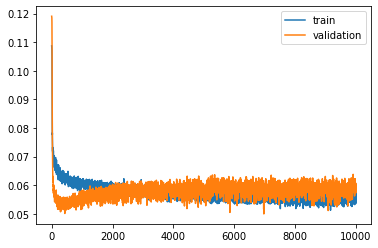

In [80]:
model2 = Sequential()
model2.add(LSTM(50,activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))

model2.add(LSTM(units=50,activation='relu', return_sequences=True))
model2.add(Dropout(0.2))

#model2.add(LSTM(units=50, return_sequences=True))
#model2.add(Dropout(0.2))

#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))

model2.add(LSTM(units=50,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
#10000 72
history2 = model2.fit(train_X, train_y, epochs=10000, batch_size=100, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

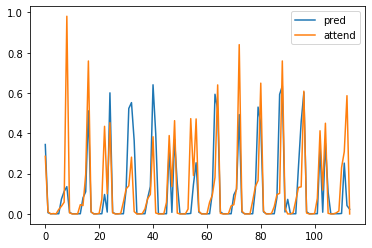

Test RMSE: 0.148
Test MSE: 0.022


In [81]:
yhat2 = model2.predict(test_X)
pyplot.plot(yhat2, label='pred')
pyplot.plot(test_y, label='attend')

pyplot.legend()
pyplot.show()

rmse = np.sqrt(mean_squared_error(test_y, yhat))
mse = mean_squared_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)

In [180]:
test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
yhat_df = pd.DataFrame(yhat, index=test_indexs, columns=['VALUE'])

trace1 = go.Scatter(x = test_y_df.index, y = test_y_df.VALUE, name = "Atteso", line = dict(color = '#17BECF'), opacity = 0.8)
trace2 = go.Scatter(x = yhat_df.index ,y = yhat_df.VALUE, name = "Predetto", line = dict(color = '#7F7F7F'), opacity = 0.8)

fig = tools.make_subplots(rows=1, cols=1, specs=[[{}]], shared_xaxes=True,  shared_yaxes=True)

fig.append_trace(trace1, 1,1)
fig.append_trace(trace2, 1,1)

fig['layout'].update( height=900,title='Time Series Atteso / Predetto con KPI', showlegend=True)

fig.show()

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [82]:
test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
yhat_df = pd.DataFrame(yhat2, index=test_indexs, columns=['VALUE'])

trace1 = go.Scatter(x = test_y_df.index, y = test_y_df.VALUE, name = "Atteso", line = dict(color = '#17BECF'), opacity = 0.8)
trace2 = go.Scatter(x = yhat_df.index ,y = yhat_df.VALUE, name = "Predetto", line = dict(color = '#7F7F7F'), opacity = 0.8)

fig = tools.make_subplots(rows=1, cols=1, specs=[[{}]], shared_xaxes=True,  shared_yaxes=True)

fig.append_trace(trace1, 1,1)
fig.append_trace(trace2, 1,1)

fig['layout'].update( height=900,title='Time Series Atteso / Predetto senza KPI', showlegend=True)
    
fig.show()

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

